In [1]:
!pip install pycona
import pandas as pd
from pycona import *


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### PyConA - Python-based open-source library for Constraint Acquisition
- Based on the well-known CPMpy Constraint Programming and Modeling library (https://github.com/CPMpy/cpmpy)
- Includes various algorithms and methods, and models several commonly used CA benchmarks
    - Currently only interactive CA methods
- Easy interface to run CA methods, also directed to be extendable for research purposes


# A first look at **PyConA**

- ProblemInstance class to encaptulate the information for CA instances
- Core the CA algorithms
    - Interactive CA algorithms subclassing the AlgorithmCAInteractive class
- CAEnv class: the environment of CA systems
    - Subclassed by ActiveCAEnv for interactive CA systems.
    - Include the configurable options of CA systems


### Preparing the problem instances

Vocubulary: The variables of our problem with their domains

Create any type of variable supported in CPMpy

In [2]:
import cpmpy as cp

# Define the variables
int_vars = cp.intvar(1, 4, shape=(4,4), name="var")  # lower bound, upper bound, shape, variable names
print(int_vars)

[[var[0,0] var[0,1] var[0,2] var[0,3]]
 [var[1,0] var[1,1] var[1,2] var[1,3]]
 [var[2,0] var[2,1] var[2,2] var[2,3]]
 [var[3,0] var[3,1] var[3,2] var[3,3]]]


Creating the language, i.e. what relations we expect to be in our problem:
- need to define abstract relations, 
- **PyConA** defines abstract variables for that

In [3]:
AV = absvar(2)  # create abstract vars - as many as maximum arity

# create abstract relations using the abstract vars
language = [AV[0] == AV[1], 
            AV[0] != AV[1], 
            AV[0] < AV[1], 
            AV[0] > AV[1], 
            AV[0] >= AV[1], 
            AV[0] <= AV[1]]
print(language)

[(AV4) == (AV5), (AV4) != (AV5), (AV4) < (AV5), (AV4) > (AV5), (AV4) >= (AV5), (AV4) <= (AV5)]


#### Using the *ProblemInstance* class for modeling a problem: Example with nurse rostering:

In [4]:
import cpmpy as cp

def construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift):

    # Define the variables
    roster_matrix = cp.intvar(1, num_nurses, shape=(num_days, shifts_per_day, nurses_per_shift), 
                              name="shifts")


    # Create the language:
    AV = absvar(2)  # create abstract vars - as many as maximum arity
    # create abstract relations using the abstract vars
    lang = [AV[0] == AV[1], AV[0] != AV[1], AV[0] < AV[1], AV[0] > AV[1], AV[0] >= AV[1], AV[0] <= AV[1]]

    instance = ProblemInstance(variables=roster_matrix, language=lang)

    return instance

Constructing a small nurse rostering instance:

In [5]:
instance= construct_nurse_rostering(3, 2, 8, 2)
print(instance)

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Language: [(AV6) == (AV7), (AV6) != (AV7), (AV6) < (AV7), (AV6) > (AV7), (AV6) >= (AV7), (AV6) <= (AV7)].


##### Active CA: Simulating the oracle

- Default oracle: human user
- We can create our oracle to automate the process
- E.g.: ConstraintOracle for using the set of constraints to simulate the answers.

Lets adjust our `construct_nurse_rostering()` function to also return an oracle:

In [6]:
def construct_nurse_rostering_with_oracle(shifts_per_day, num_days, num_nurses, nurses_per_shift):
    
    inst = construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift)
    
    # Create an oracle for simulation, by defining the ground truth problem
    ## Define the variables
    roster_matrix = inst.variables
    
    ## Define the list of (fixed-arity/decomposed) constraints
    C_T = []

    ## Constraint: Each shift in a day must be assigned to a different nurse
    for day in range(num_days):
        C_T += cp.AllDifferent(roster_matrix[day, ...]).decompose()   # ... means all remaining dimensions
    ## Constraint: The last shift of a day cannot have the same nurse as the first shift of the next day
    for day in range(num_days - 1):
        C_T += cp.AllDifferent(roster_matrix[day, shifts_per_day - 1], roster_matrix[day + 1, 0]).decompose()

    oracle = ConstraintOracle(C_T)

    return inst, oracle

## Interactive Constraint Acquisition System 

Core: the AlgorithmCAInteractive class. Subclassed with different algorithms from the literature. 

CA environment to configure the exact settings of CA systems (and offer common functionality)

ActiveCAEnv for interactive CA systems, configuring the 3 main subcomponents of interactive CA systems:

- qgen: (for query generation) An instance of QGenBase, default is PQGen.
- find_scope: (for finding the scope) An instance of FindScopeBase, default is FindScope2.
- findc: (for finding the exact constraints) An instance of FindCBase, default is FindC.

For each of the subcomponents various methods are implemented from the litarature.

In [7]:
# Create the instance
instance, oracle = construct_nurse_rostering_with_oracle(3, 2, 8, 2)

# create the interactive CA system of choice with the default settings
qa = QuAcq()
learned_instance = qa.learn(instance, oracle=oracle, verbose=1)

......L.......L......L.......L........L........L.....L.........L.....L......L........L..........L........L.......L.....L.........L........L........L.....L...L......L..........L...L....L.........L............L..........L.......L.........L......L.....L....L..L....L...
Learned 34 constraints in 232 queries.


In [8]:
# Creating a custom environment, change find_scope to basic FindScope
env = ActiveCAEnv(find_scope=FindScope())

# create the interactive CA system of choice
qa_fs1 = QuAcq(env)
learned_instance = qa_fs1.learn(instance, oracle=oracle, verbose=1)


........L.........L........L...........L.........L......L.........L............L..........L...........L........L..........L.........L...........L............L........L........L...........L..........L.......L............L.............L........L........L..........L..............L...........L...........L.........L.........L..........L.............L.......L........L...
Learned 34 constraints in 333 queries.


In [9]:
# we can compare the detailed statistics:
pd.concat([qa.env.metrics.short_statistics, 
           qa_fs1.env.metrics.short_statistics], keys=["QuAcq findscope2", "QuAcq findscope"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  \
QuAcq findscope2 0  34    232         38    155     39      6.0690   
QuAcq findscope  0  34    333         37    274     22      5.7508   

                    avg_gen_time   avg_t   max_t    tot_t  conv  
QuAcq findscope2 0        0.9254  0.1723  1.4490  39.9743     1  
QuAcq findscope  0        0.9213  0.1107  1.5447  36.8765     1

In [10]:
# increase verbosity for closer look of the learning process
learned_instance = qa.learn(instance, oracle=oracle, verbose=3)

Size of CL:  0
Size of B:  396
Number of Queries:  0
Query0: is this a solution?
[[[1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]]]
Answer:  No
Query1: is this a solution?
[[[1 1]
  [1 1]
  [1 1]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  No
Query2: is this a solution?
[[[1 1]
  [1 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  No
Query3: is this a solution?
[[[1 1]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  No
Query4: is this a solution?
[[[2 1]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,0,1])]
Query5: is this a solution?
[[[6 8]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,0,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,0,1])]
Size of CL:  1
Size of B:  393
Number of Queries:  6
Query6: is this a solution?
[[[2 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]]]
Answer:  No
Query7

Query106: is this a solution?
[[[2 8]
  [1 5]
  [2 1]]

 [[1 5]
  [2 3]
  [2 2]]]
Answer:  No
Query107: is this a solution?
[[[0 8]
  [1 5]
  [2 0]]

 [[1 5]
  [0 3]
  [2 2]]]
Answer:  No
Query108: is this a solution?
[[[0 8]
  [1 5]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query109: is this a solution?
[[[0 0]
  [1 5]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query110: is this a solution?
[[[0 0]
  [0 0]
  [2 0]]

 [[1 5]
  [0 0]
  [0 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) != (shifts[1,2,1]), (shifts[1,0,0]) >= (shifts[1,2,1])]
Query111: is this a solution?
[[[0 0]
  [1 0]
  [2 0]]

 [[1 5]
  [0 0]
  [0 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[1,2,1]), (shifts[0,1,0]) >= (shifts[1,2,1])]
Query112: is this a solution?
[[[0 0]
  [1 0]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query113: is this a solution?
[[[0 0]
  [0 0]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query114:

Query155: is this a solution?
[[[1 3]
  [4 1]
  [2 1]]

 [[4 1]
  [2 3]
  [7 3]]]
Answer:  No
Query156: is this a solution?
[[[0 3]
  [4 1]
  [2 0]]

 [[4 1]
  [0 3]
  [7 3]]]
Answer:  No
Query157: is this a solution?
[[[0 3]
  [4 1]
  [2 0]]

 [[4 1]
  [0 3]
  [7 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,1,1])]
Query158: is this a solution?
[[[0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 3]
  [0 3]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,1])]
Size of CL:  20
Size of B:  152
Number of Queries:  159
Query159: is this a solution?
[[[4 2]
  [5 3]
  [4 4]]

 [[1 2]
  [4 3]
  [5 4]]]
Answer:  No
Query160: is this a solution?
[[[0 2]
  [5 3]
  [4 0]]

 [[1 2]
  [0 3]
  [5 4]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,1,1])]
Query161: is this a solution?
[[[4 2]
  [5 3]
  [4 0]]

 [[1 2]
  [0 3]
  [5 4]]]
Answer:  No
Query162: is this a solution?
[[[4 0]
  

Query203: is this a solution?
[[[2 3]
  [4 6]
  [1 4]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query204: is this a solution?
[[[2 3]
  [4 6]
  [1 0]]

 [[3 4]
  [0 5]
  [6 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,2,1])]
Query205: is this a solution?
[[[2 3]
  [4 6]
  [1 0]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query206: is this a solution?
[[[0 3]
  [4 6]
  [1 0]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query207: is this a solution?
[[[0 0]
  [4 6]
  [1 0]]

 [[3 4]
  [2 0]
  [6 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) == (shifts[1,1,0]), (shifts[0,1,1]) < (shifts[1,1,0]), (shifts[1,1,0]) >= (shifts[1,2,0]), (shifts[0,2,0]) > (shifts[1,1,0]), (shifts[0,2,0]) >= (shifts[1,1,0]), (shifts[1,1,0]) > (shifts[1,2,0]), (shifts[0,1,0]) < (shifts[1,1,0]), (shifts[1,1,0]) == (shifts[1,2,0]), (shifts[1,0,0]) == (shifts[1,1,0]), (shifts[0,1,0]) == (shifts[1,1,0]), (shifts[0,1,1]) <= (shifts[1,1,0]), (shift

Query253: is this a solution?
[[[6 0]
  [0 0]
  [0 8]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,1])]
Size of CL:  34
Size of B:  8
Number of Queries:  254
Query254: is this a solution?
[[[2 1]
  [0 0]
  [0 6]]

 [[0 0]
  [1 6]
  [0 5]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) <= (shifts[1,1,0]), (shifts[0,0,0]) < (shifts[1,1,0]), (shifts[0,0,0]) >= (shifts[0,2,1]), (shifts[0,2,1]) != (shifts[1,1,1]), (shifts[0,2,1]) <= (shifts[1,2,1]), (shifts[0,0,1]) != (shifts[1,1,0])]
Size of CL:  34
Size of B:  2
Number of Queries:  255
Query255: is this a solution?
[[[2 0]
  [0 0]
  [0 1]]

 [[0 0]
  [1 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,1,0])]
Size of CL:  34
Size of B:  1
Number of Queries:  256
Query256: is this a solution?
[[[1 0]
  [0 0]
  

### Learned instance

In [11]:
print(learned_instance) # see the instance with the learned constraints :

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Constraints: [(shifts[0,0,0]) != (shifts[0,0,1]), (shifts[0,0,1]) != (shifts[0,1,0]), (shifts[0,0,0]) != (shifts[0,1,0]), (shifts[0,1,0]) != (shifts[0,1,1]), (shifts[0,0,1]) != (shifts[0,1,1]), (shifts[0,0,0]) != (shifts[0,1,1]), (shifts[0,1,0]) != (shifts[0,2,0]), (shifts[0,0,0]) != (shifts[0,2,0]), (shifts[0,1,1]) != (shifts[0,2,0]), (shifts[0,0,1]) != (shifts[0,2,0]), (shifts[0,1,1]) != (shifts[0,2,1]), (shifts[1,0,1]) != (shifts[1,1,0]), (shifts[1,2,0]) != (shifts[1,2,1]), (shifts[0,2,0]) != (shifts[0,2,1]), (shifts[0,0,0]) != (shifts[0,2,1]), (shifts[0,1,0]) != (shifts[0,2,1]), (shifts[0,0,1]) != (shifts[0,2,1]), (shifts[0,2,0]) != (shifts[1,0,0]), (shifts[1,0,0]) != (shifts[1,0,1]), (shifts[0,2,0]) != (shifts[1,0,1]), (shifts[0,2,1]) != (shifts[1,0,0]), (s

### Solving the learned model

In [30]:
m = learned_instance.get_cpmpy_model() # get the cpmpy model
m.solve()

print(learned_instance.variables.value()) # see the solution

[[[3 4]
  [2 1]
  [8 7]]

 [[6 5]
  [4 3]
  [2 1]]]


### Visualizing the solutions and queries

In [36]:

import matplotlib.pyplot as plt


def visualize_nurse_rostering(shifts):
    num_days, shifts_per_day, nurses_per_shift = shifts.shape
    num_nurses = shifts.max()  # Assuming nurse IDs are from 1 to num_nurses

    # Create an empty DataFrame with nurses as rows and days as columns
    columns = [f'Day {j} Shift {k}' for j in range(num_days) for k in range(shifts_per_day)]
    df = pd.DataFrame(index=[f'Nurse {i+1}' for i in range(num_nurses)], columns=columns)

    # Fill the DataFrame with shift information
    for day in range(num_days):
        for shift in range(shifts_per_day):
            for nurse in range(nurses_per_shift):
                nurse_id = shifts[day, shift, nurse]
                if nurse_id != 0:
                    df.at[f'Nurse {nurse_id}', f'Day {day} Shift {shift}'] = 'Assigned'
                
    # Fill 'Not Assigned' for nurses who are not assigned to a shift
    df = df.fillna('Not Assigned')

    # Create a color map to highlight assigned shifts
    cmap = {'Assigned': 'lightgreen', 'Not Assigned': 'white'}

    # Create a new DataFrame to store colors
    df_colors = df.applymap(lambda x: cmap[x])

    # Calculate figure size dynamically
    fig_width = max(12, num_days * shifts_per_day * 1.5)  # Adjust width scaling factor as needed
    fig_height = max(2, num_nurses * 0.2)  # Adjust height scaling factor as needed

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create a table plot
    table = ax.table(cellText=df.values, cellColours=df_colors.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    ax.axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)  # Adjust the subplot parameters

    plt.show()


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


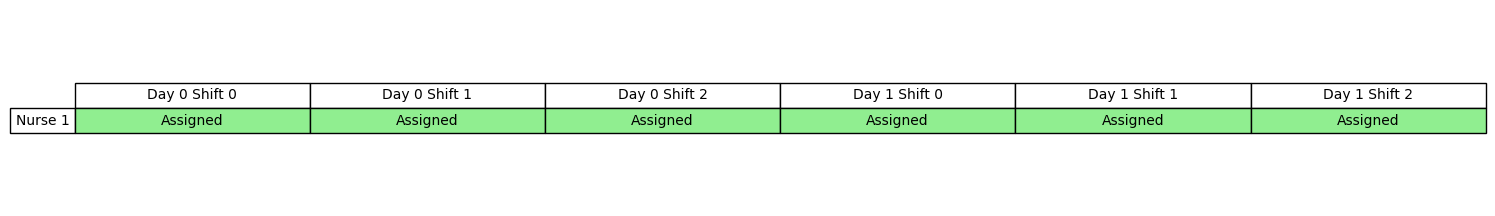

In [37]:
visualize_nurse_rostering(instance.variables.value())

### Using the visualization in the queries

In [38]:
instance.visualize = visualize_nurse_rostering

Size of CL:  0
Size of B:  396
Number of Queries:  0
Query0: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


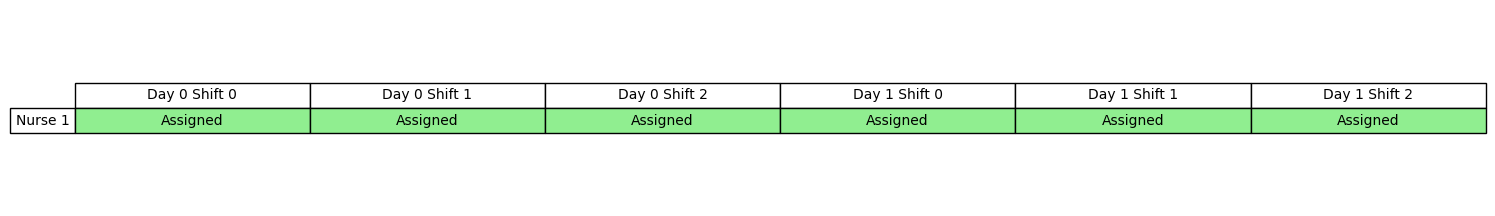

Answer:  No
Query1: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


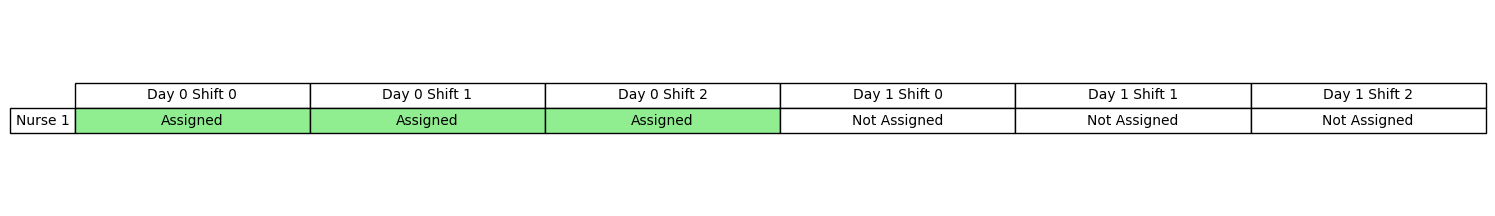

Answer:  No
Query2: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


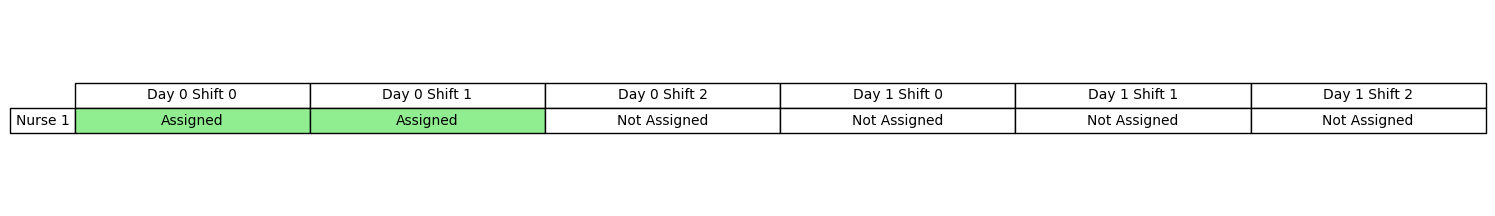

Answer:  No
Query3: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


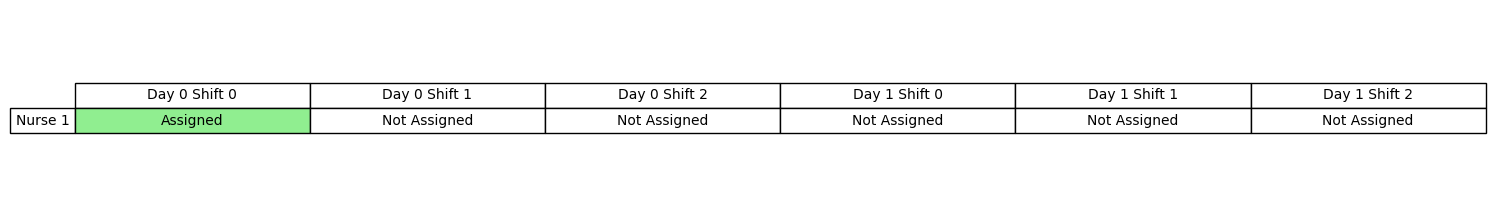

Answer:  No
Query4: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


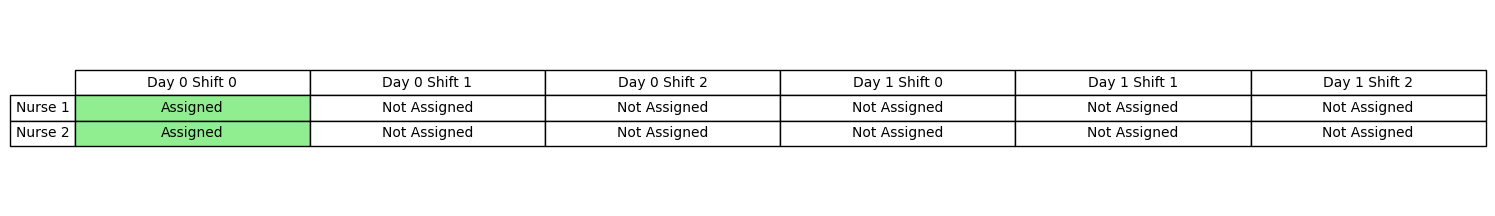

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,0,1])]
Query5: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


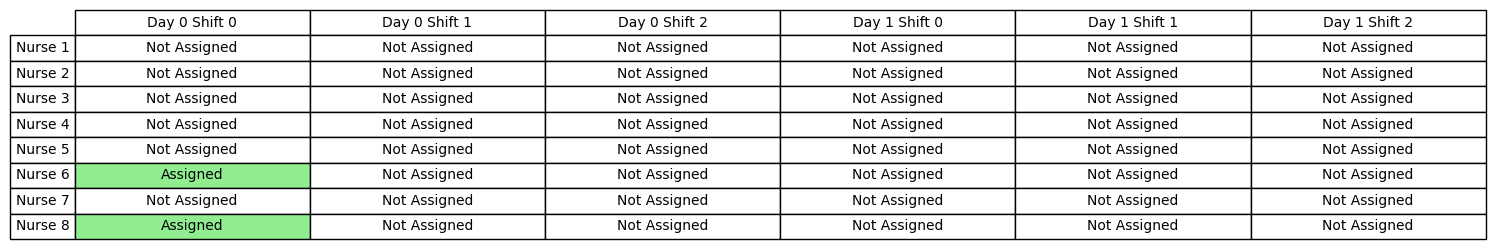

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,0,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,0,1])]
Size of CL:  1
Size of B:  393
Number of Queries:  6
Query6: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


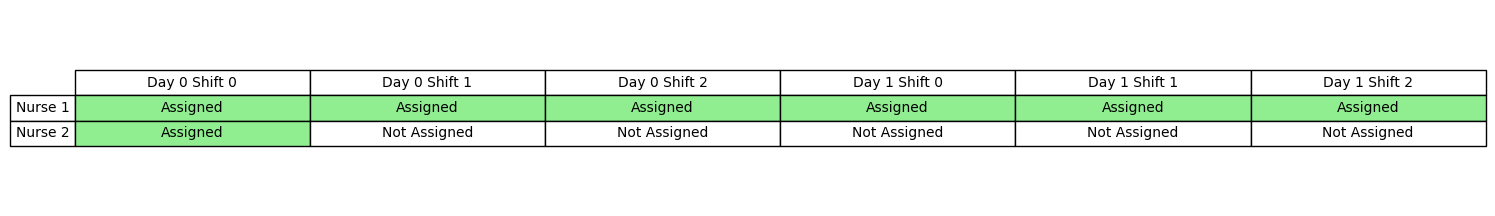

Answer:  No
Query7: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


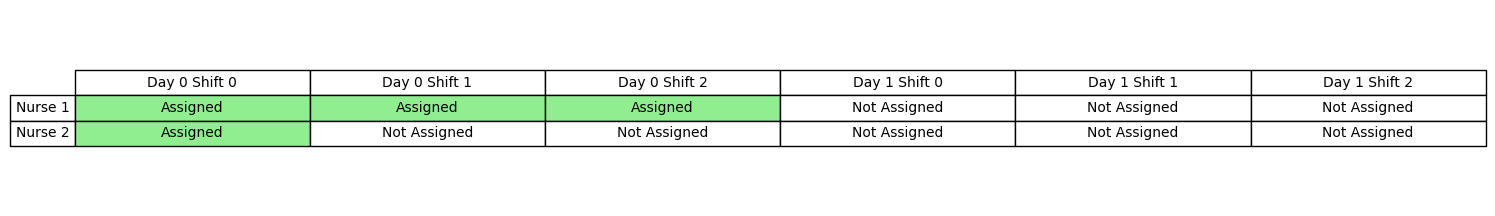

Answer:  No
Query8: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


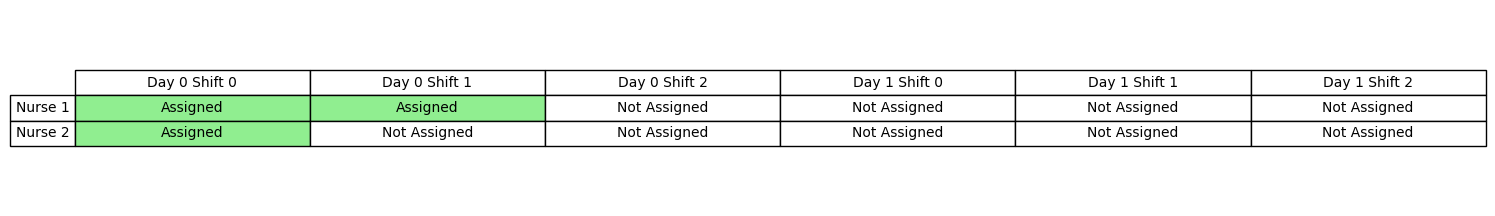

Answer:  No
Query9: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


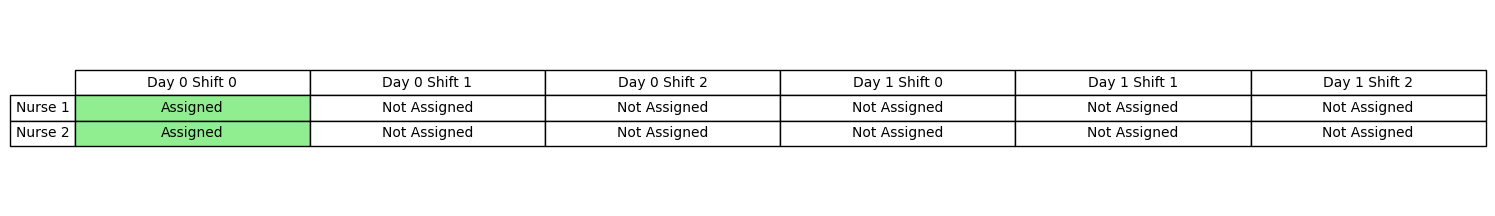

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) == (shifts[0,0,1]), (shifts[0,0,0]) <= (shifts[0,0,1])]
Query10: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


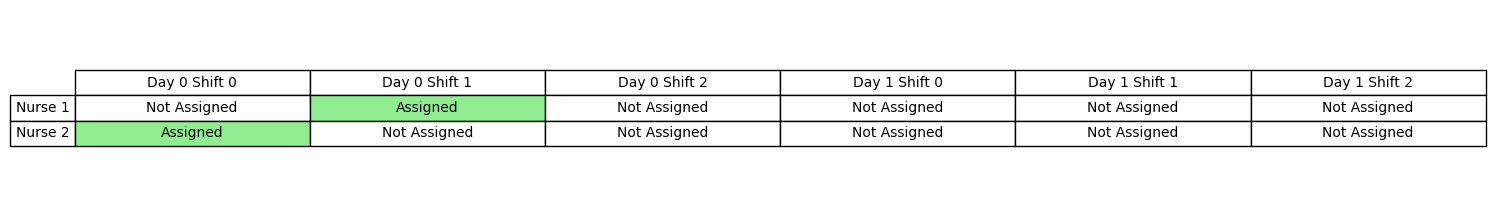

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) == (shifts[0,1,0]), (shifts[0,0,0]) < (shifts[0,1,0]), (shifts[0,0,0]) <= (shifts[0,1,0])]
Query11: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


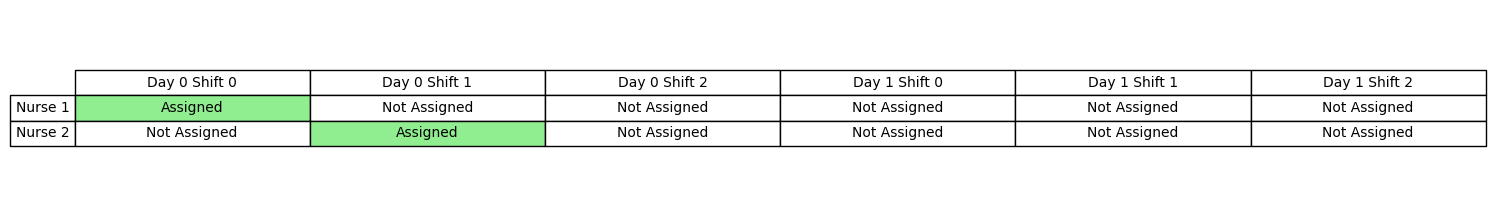

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) > (shifts[0,1,0])]
Query12: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


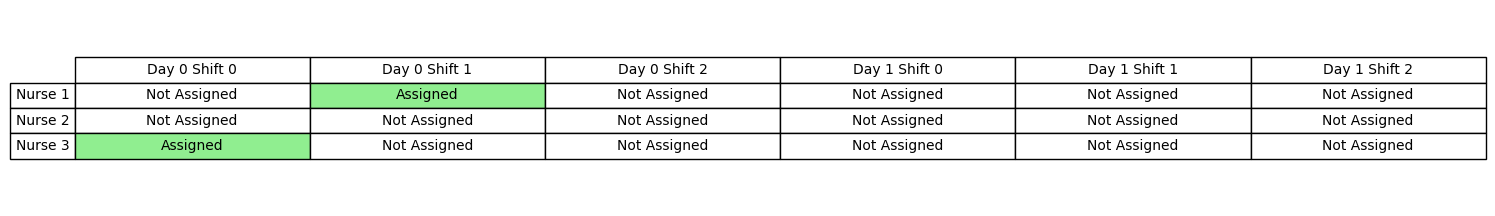

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) < (shifts[0,1,0])]
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,1,0])]
Size of CL:  2
Size of B:  385
Number of Queries:  13
Query13: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


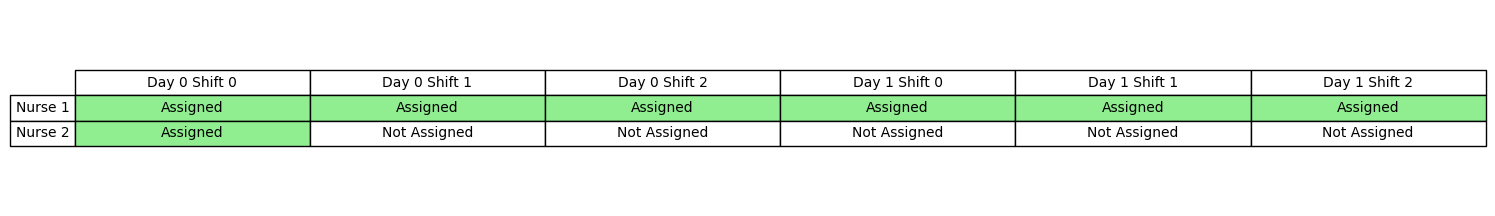

Answer:  No
Query14: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


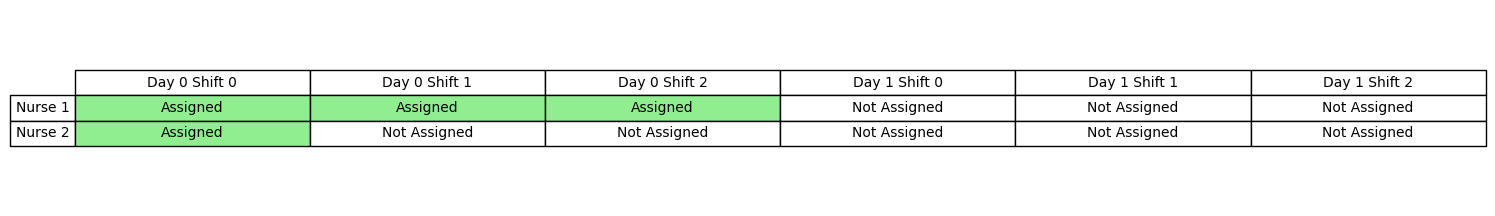

Answer:  No
Query15: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


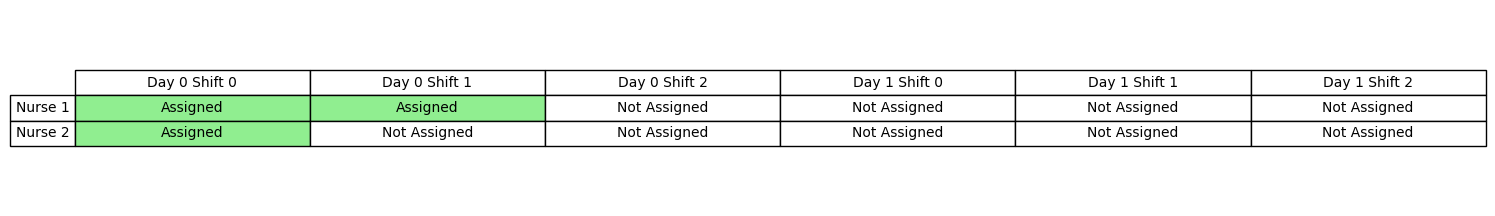

Answer:  No
Query16: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


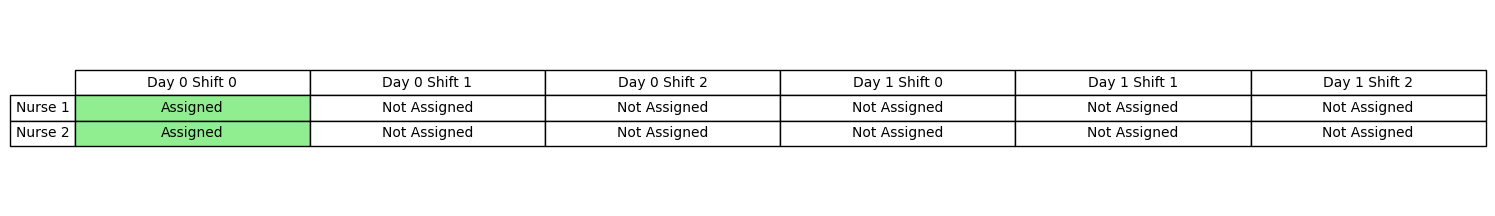

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) >= (shifts[0,0,1])]
Query17: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


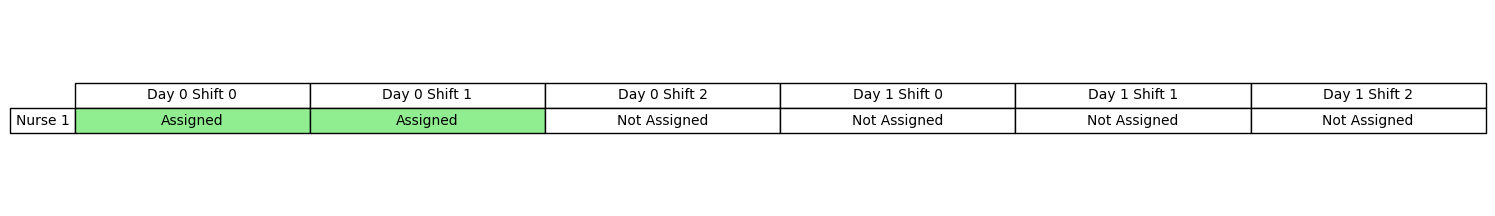

Answer:  No
Query18: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


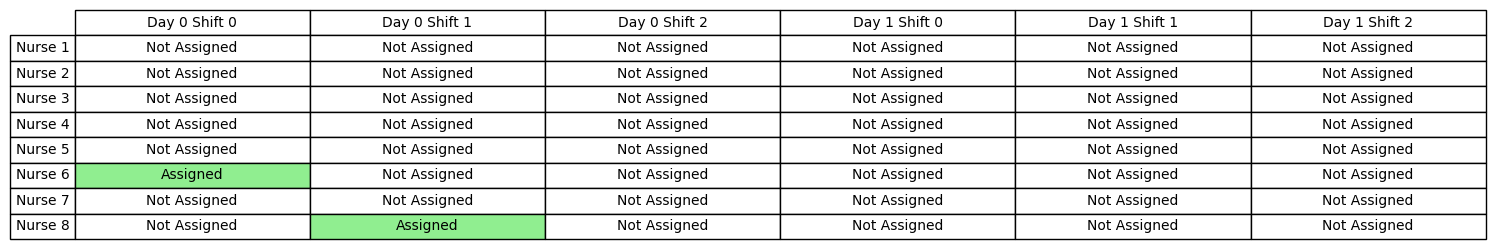

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,1,0])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,1,0])]
Size of CL:  3
Size of B:  382
Number of Queries:  19
Query19: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


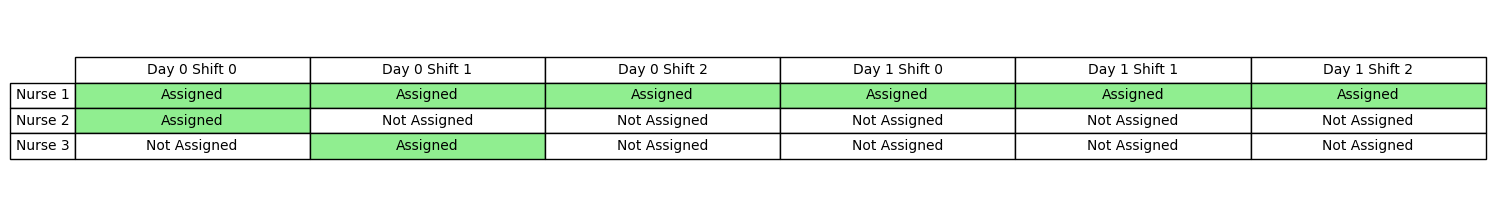

Answer:  No
Query20: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


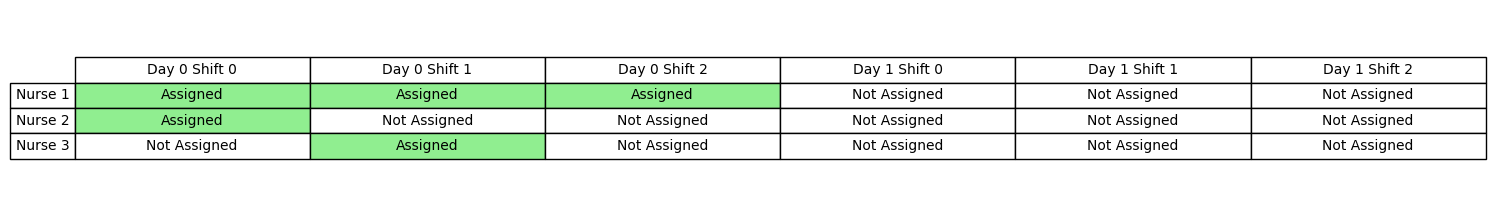

Answer:  No
Query21: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


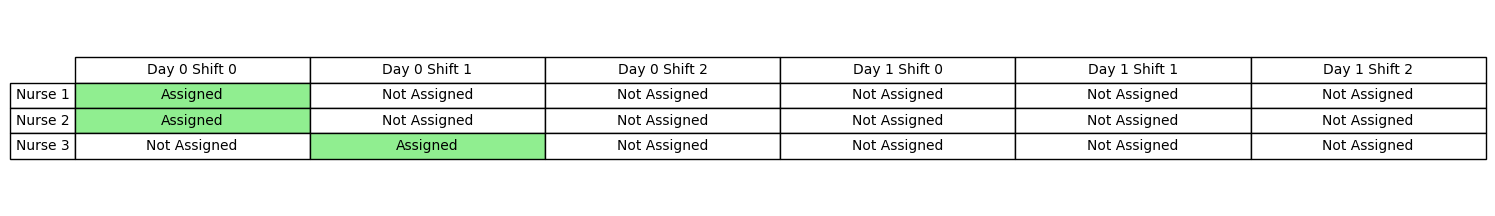

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) >= (shifts[0,1,0]), (shifts[0,0,1]) == (shifts[0,1,0]), (shifts[0,0,1]) >= (shifts[0,1,0])]
Query22: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


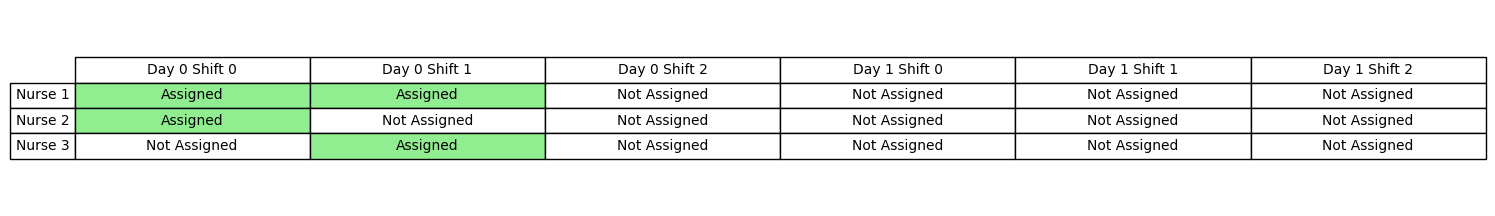

Answer:  No
Query23: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


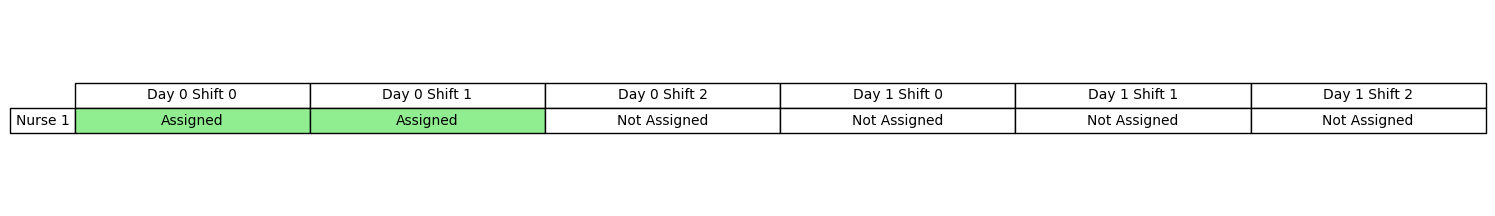

Answer:  No
Query24: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


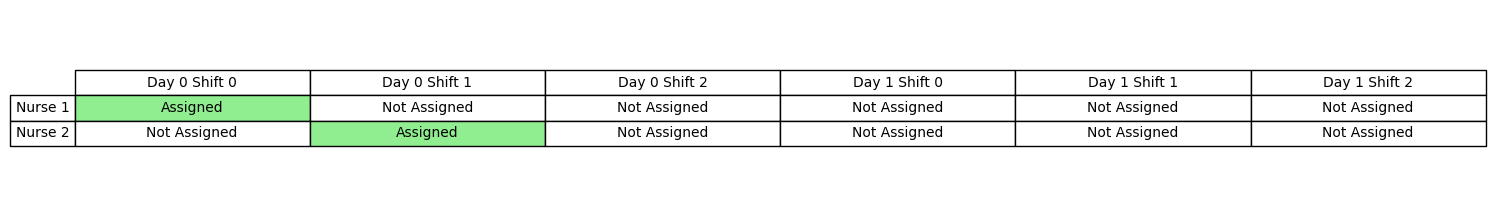

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,1,1])]
Query25: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


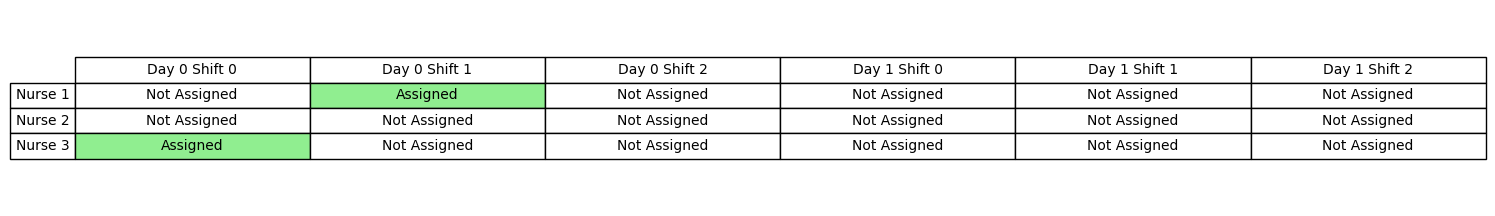

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,1,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,1,1])]
Size of CL:  4
Size of B:  376
Number of Queries:  26
Query26: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


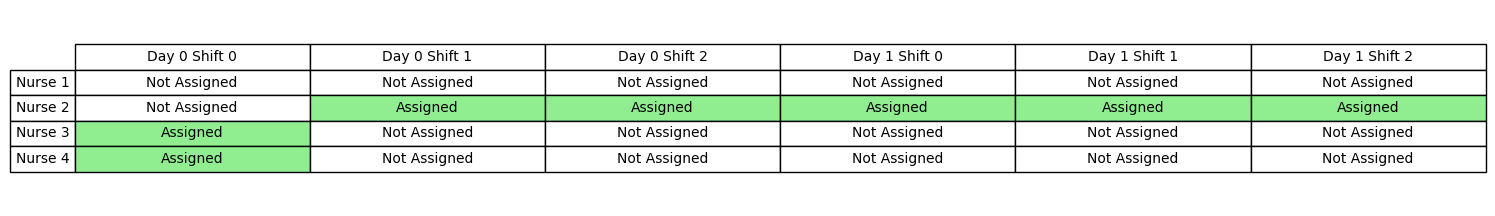

Answer:  No
Query27: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


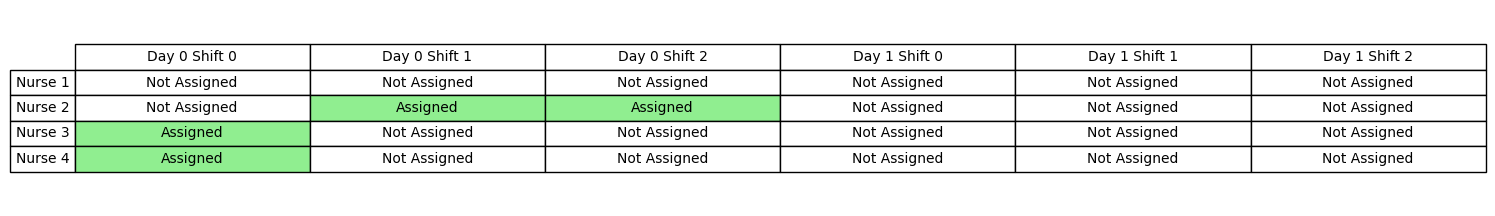

Answer:  No
Query28: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


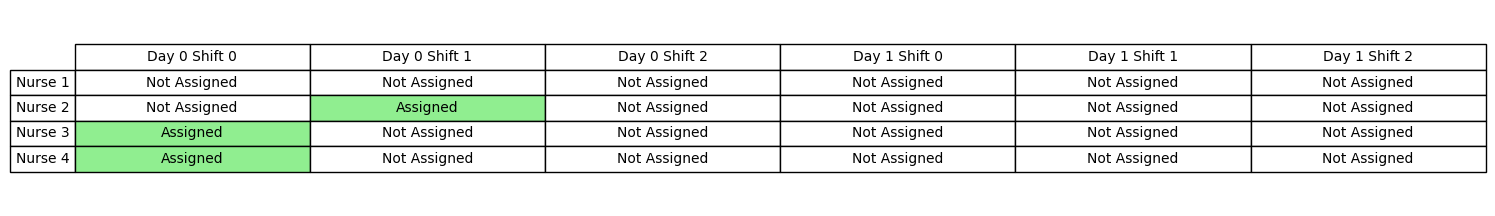

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) <= (shifts[0,1,0])]
Query29: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


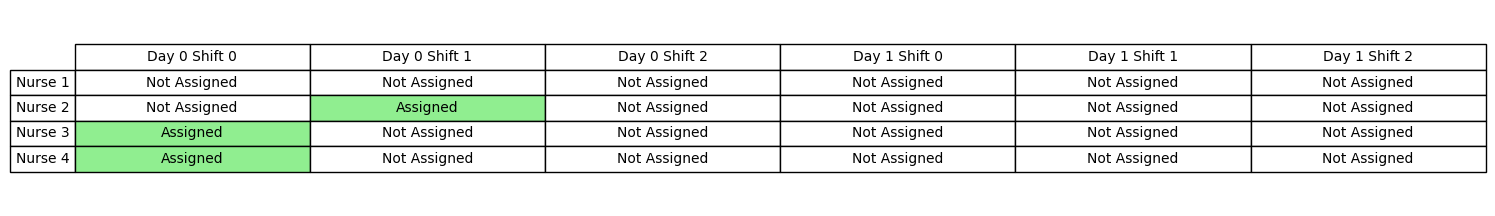

Answer:  No
Query30: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


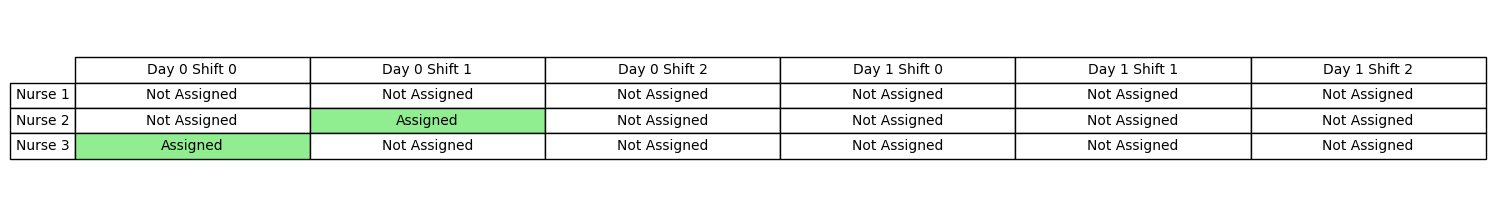

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) <= (shifts[0,1,1]), (shifts[0,0,0]) == (shifts[0,1,1])]
Query31: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


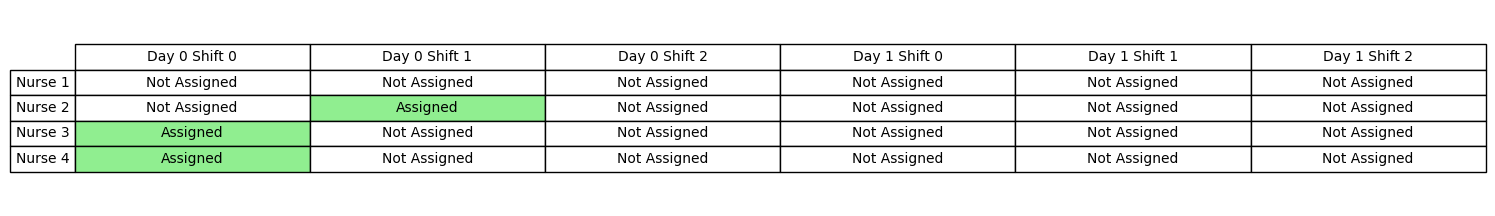

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) <= (shifts[0,1,1]), (shifts[0,0,1]) == (shifts[0,1,1]), (shifts[0,0,1]) < (shifts[0,1,1])]
Query32: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


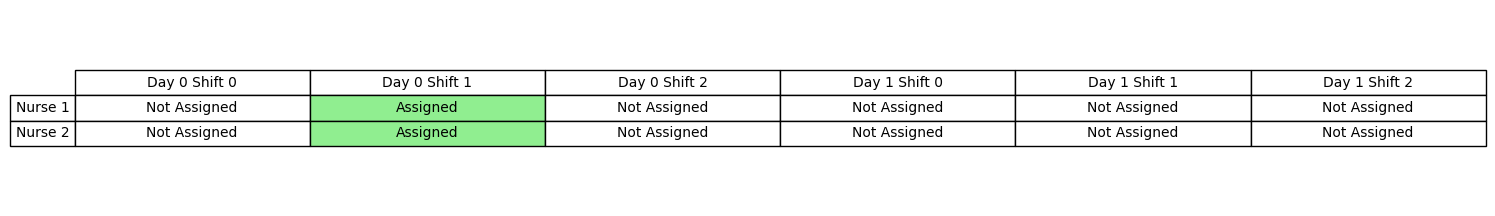

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[0,1,1])]
Query33: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


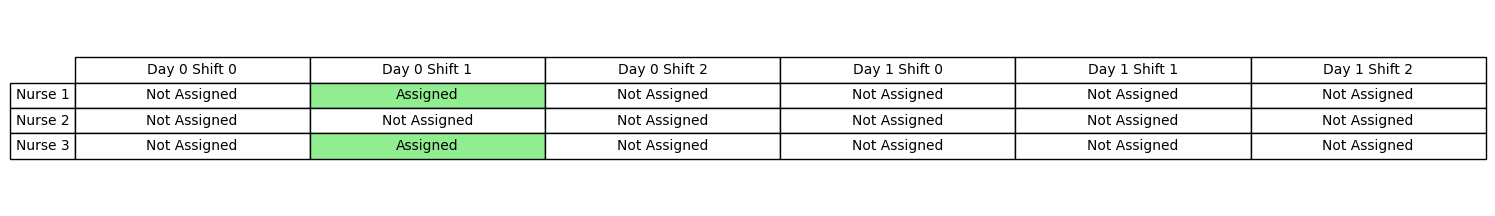

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) < (shifts[0,1,1])]
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,1,1])]
Size of CL:  5
Size of B:  367
Number of Queries:  34
Query34: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


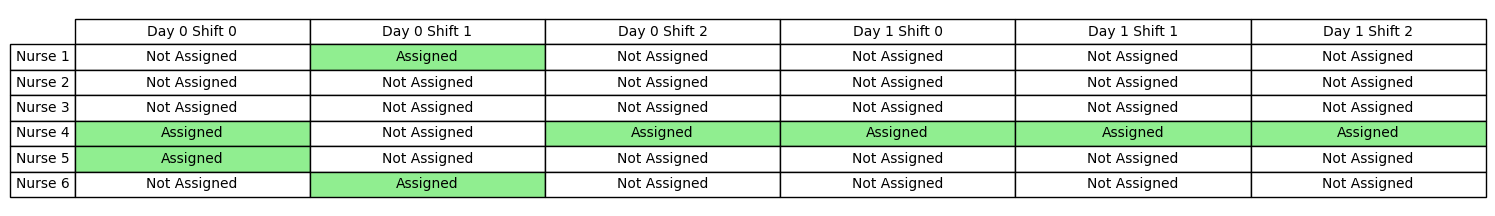

Answer:  No
Query35: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


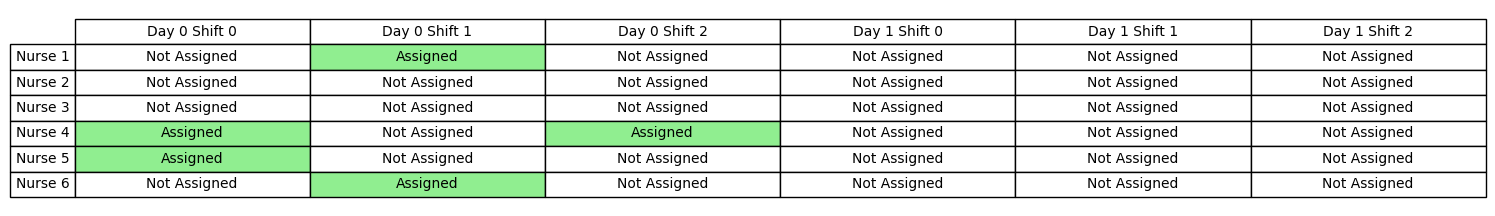

Answer:  No
Query36: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


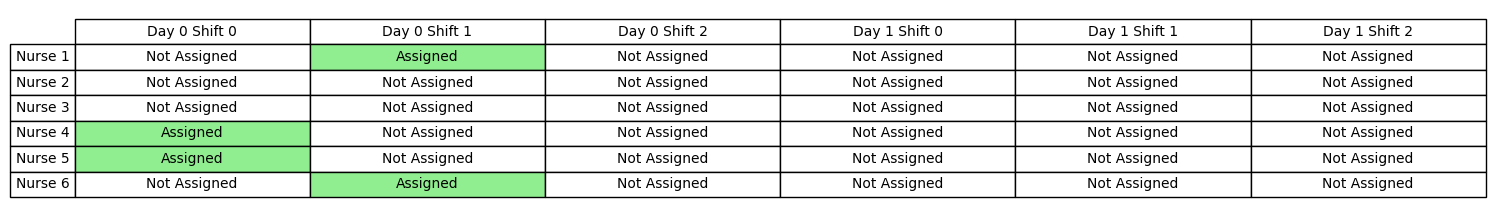

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) > (shifts[0,1,1]), (shifts[0,0,1]) >= (shifts[0,1,1]), (shifts[0,0,0]) >= (shifts[0,1,1]), (shifts[0,1,0]) == (shifts[0,1,1]), (shifts[0,1,0]) >= (shifts[0,1,1])]
Query37: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


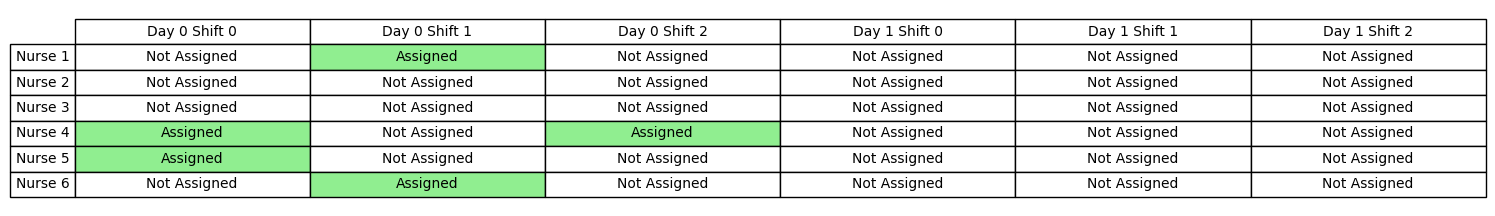

Answer:  No
Query38: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


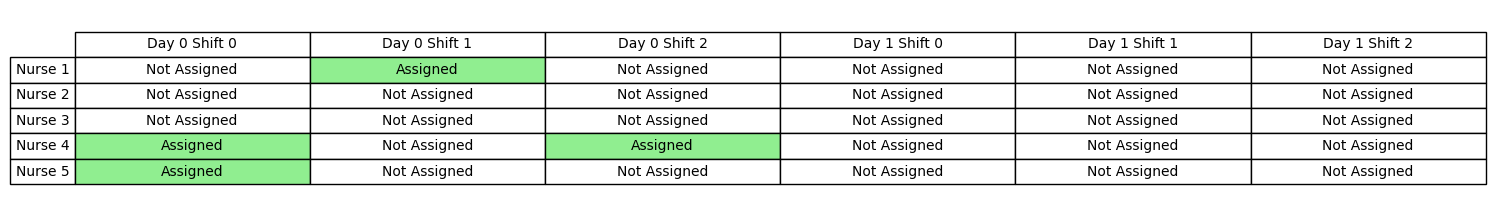

Answer:  No
Query39: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


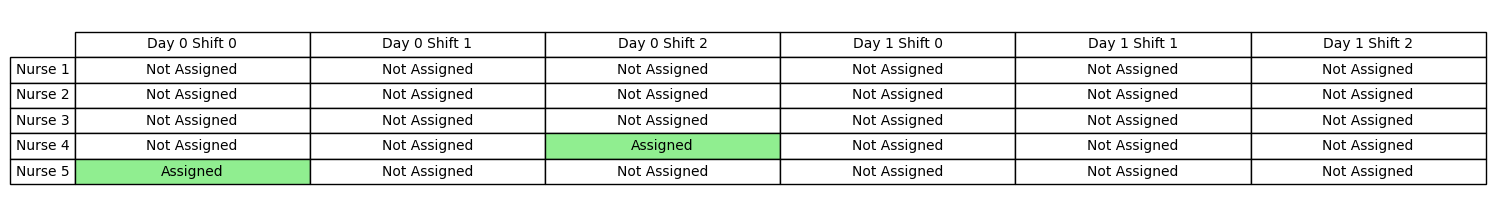

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,2,0]), (shifts[0,0,0]) <= (shifts[0,2,0]), (shifts[0,0,0]) == (shifts[0,2,0])]
Query40: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


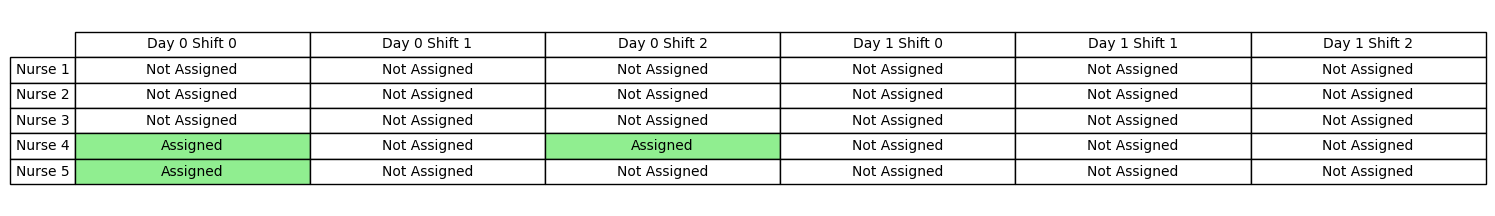

Answer:  No
Query41: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


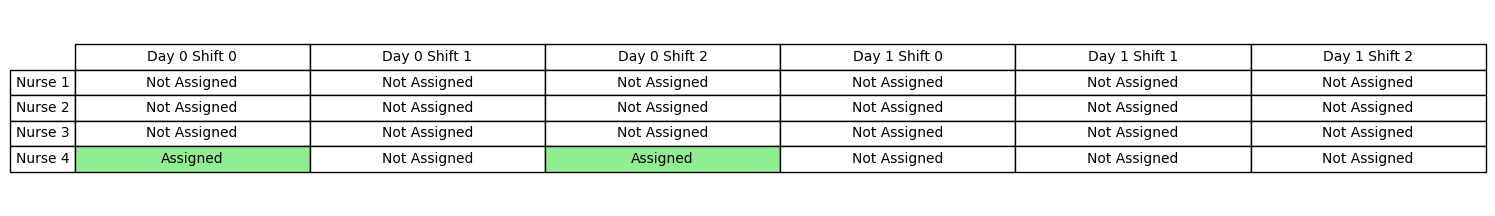

Answer:  No
Query42: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


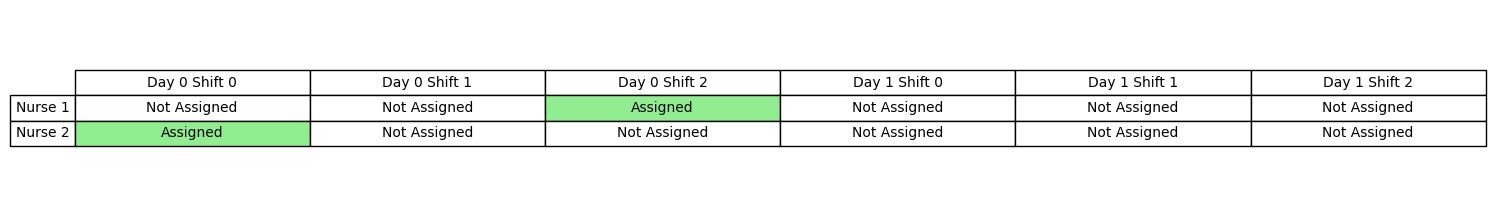

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) < (shifts[0,2,0])]
Query43: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


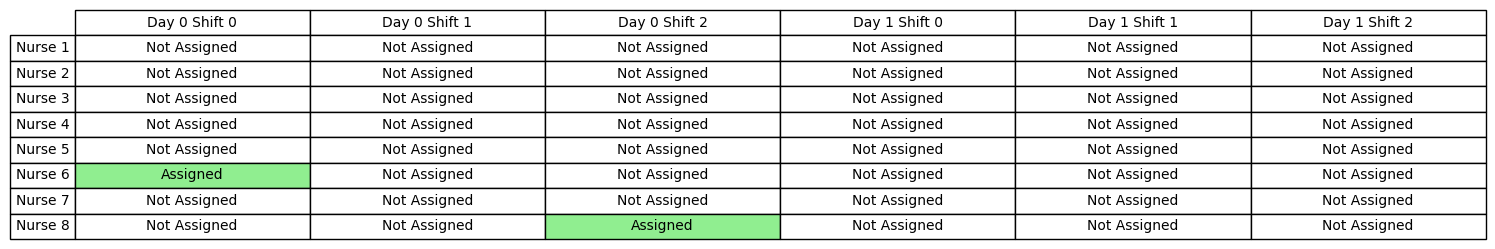

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) > (shifts[0,2,0])]
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,2,0])]
Size of CL:  6
Size of B:  356
Number of Queries:  44
Query44: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


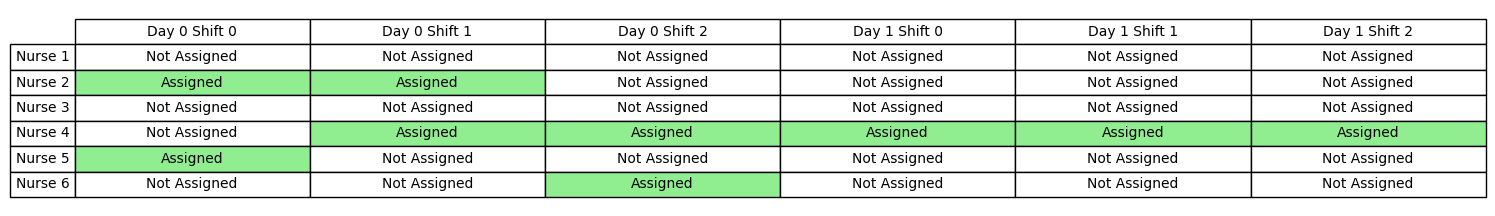

Answer:  No
Query45: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


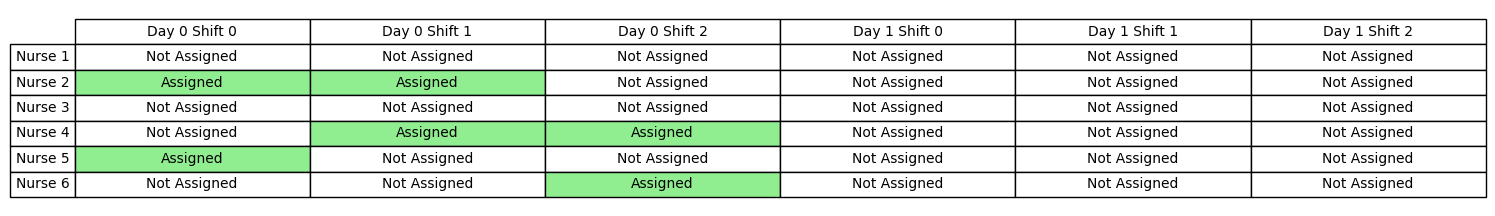

Answer:  No
Query46: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


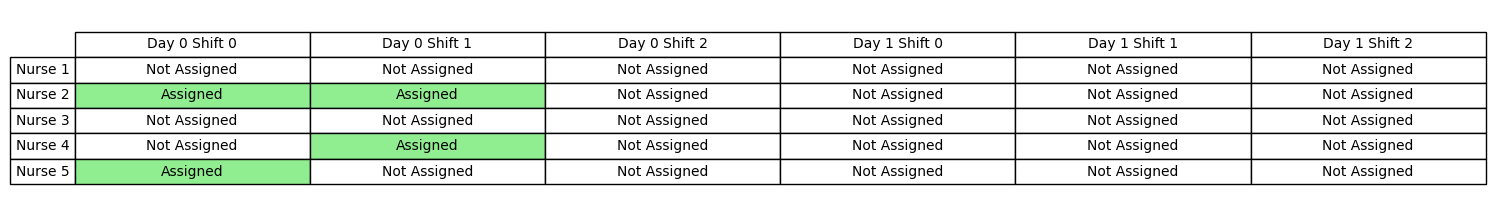

Answer:  No
Query47: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


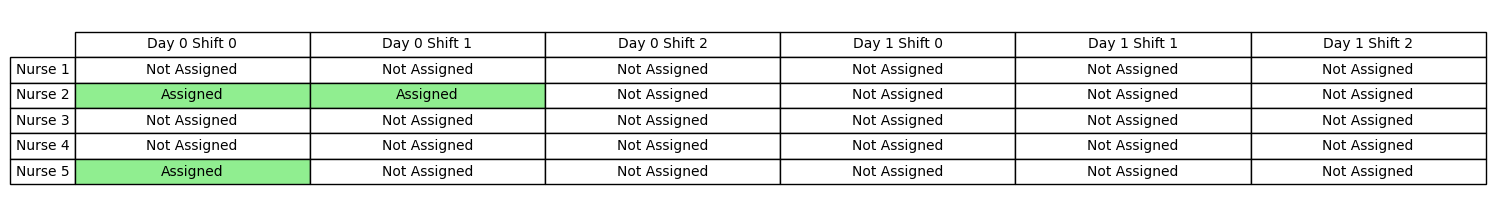

Answer:  No
Query48: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


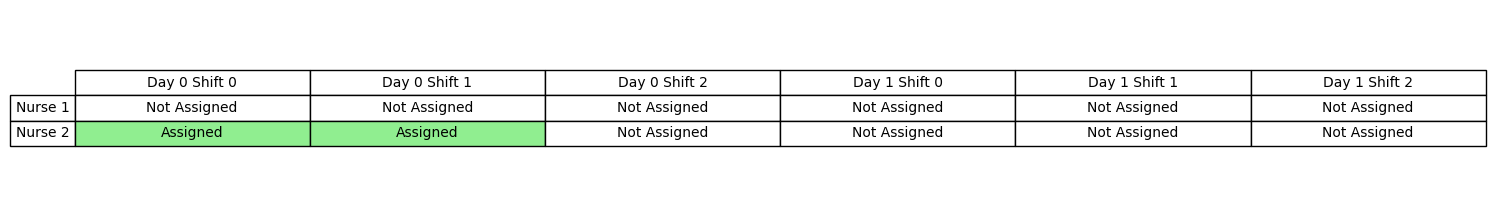

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,1,1])]
Size of CL:  7
Size of B:  355
Number of Queries:  49
Query49: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


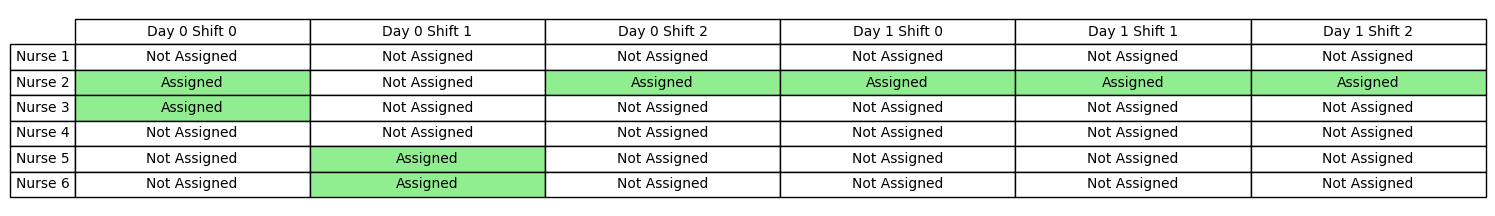

Answer:  No
Query50: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


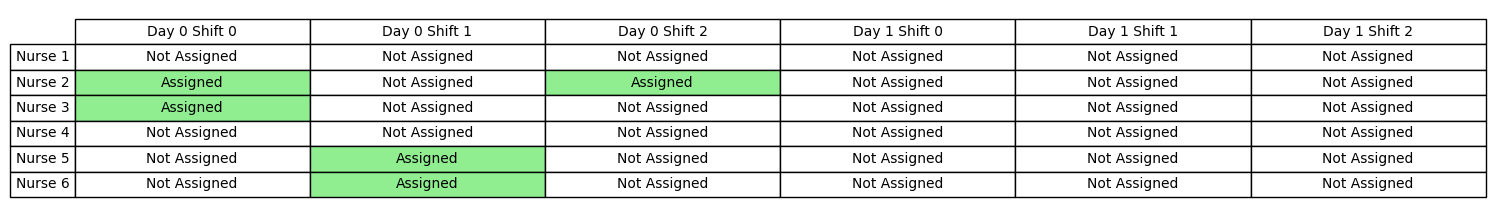

Answer:  No
Query51: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


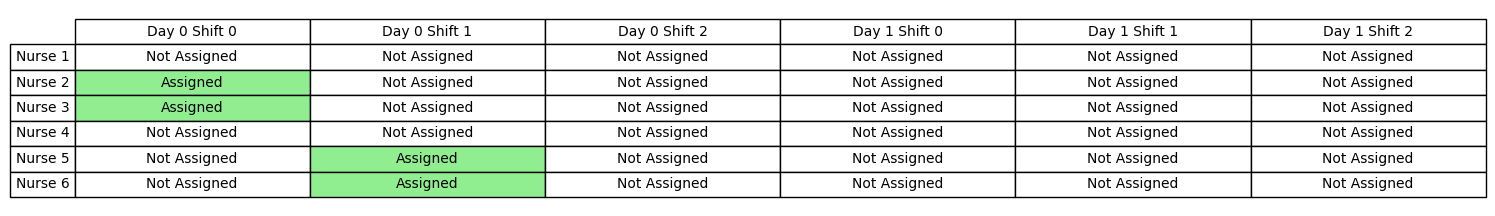

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) <= (shifts[0,1,1])]
Query52: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


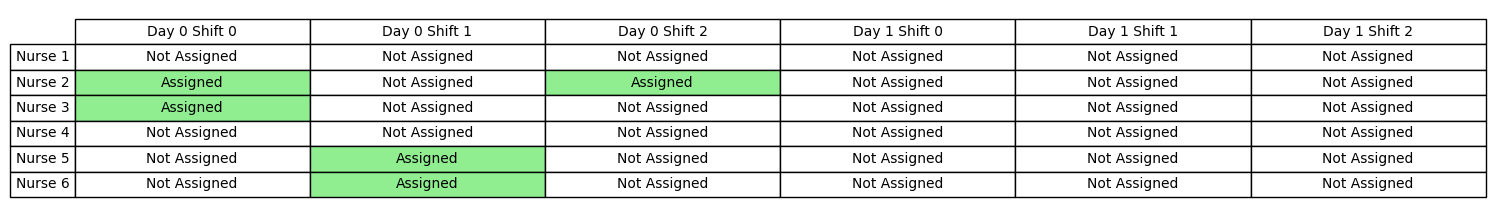

Answer:  No
Query53: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


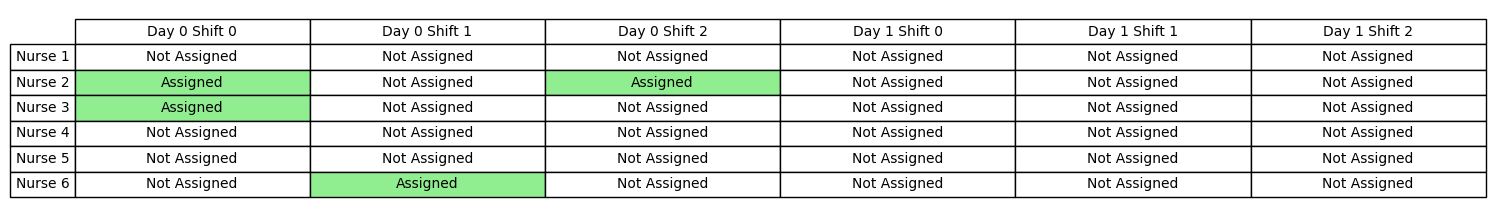

Answer:  No
Query54: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


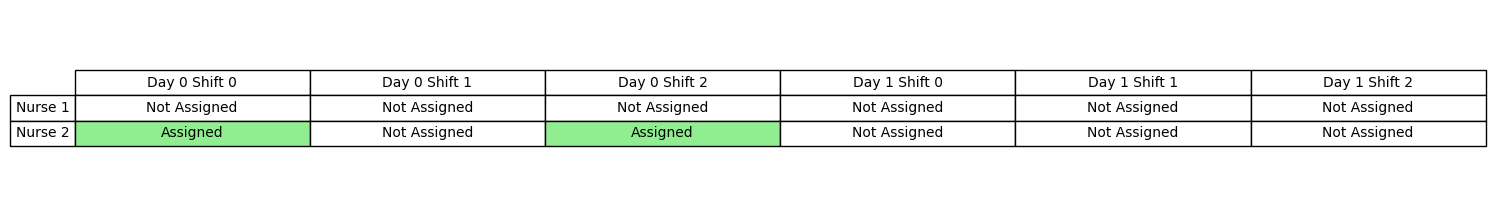

Answer:  No
Query55: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


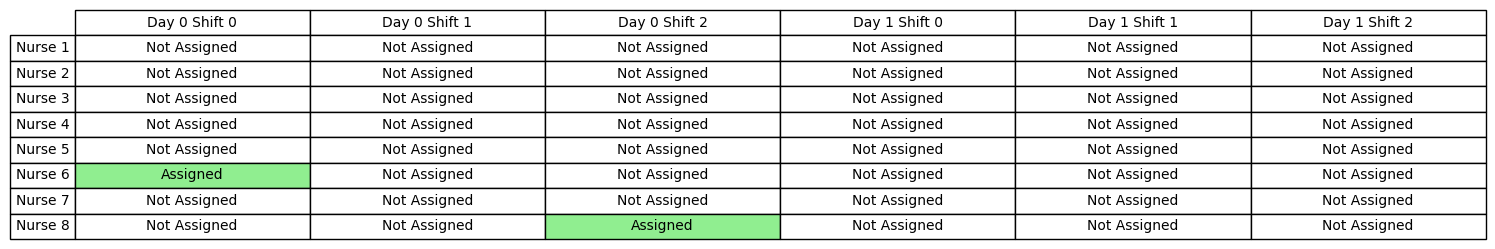

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,2,0])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,0])]
Size of CL:  8
Size of B:  352
Number of Queries:  56
Query56: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


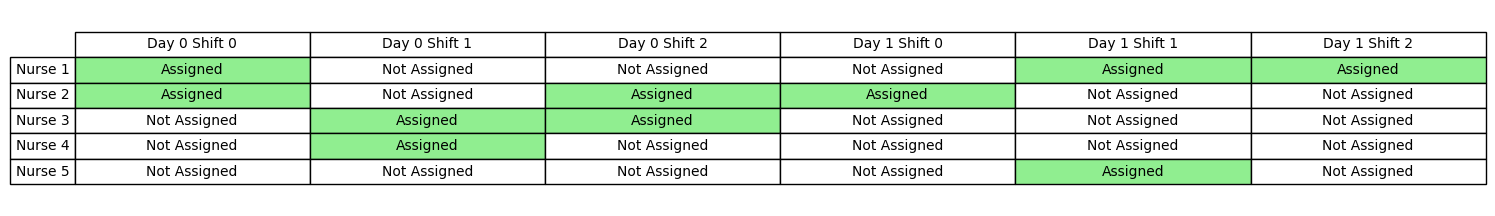

Answer:  No
Query57: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


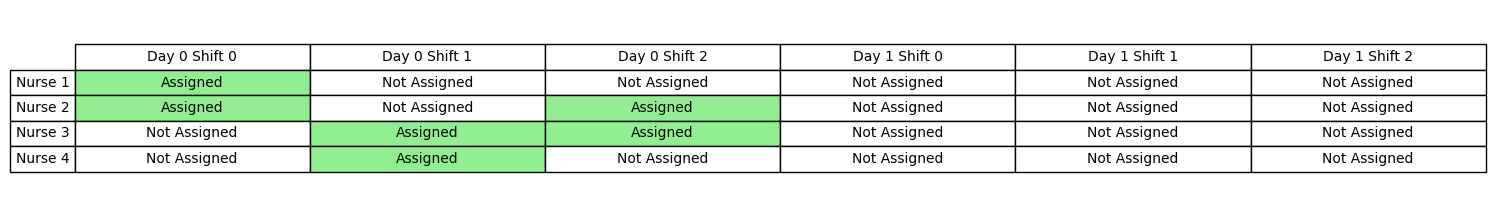

Answer:  No
Query58: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


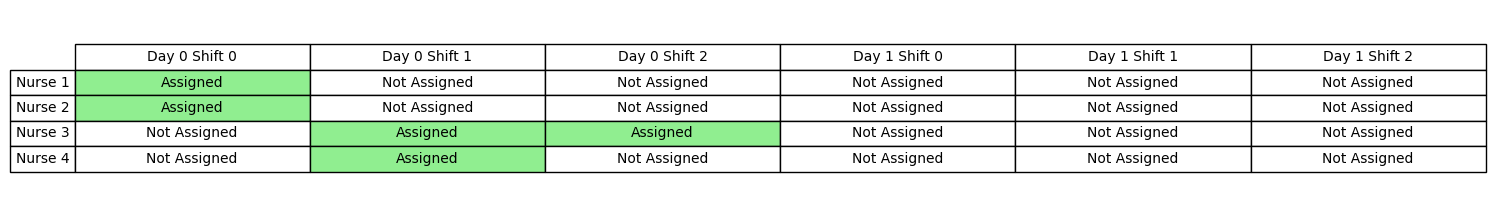

Answer:  No
Query59: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


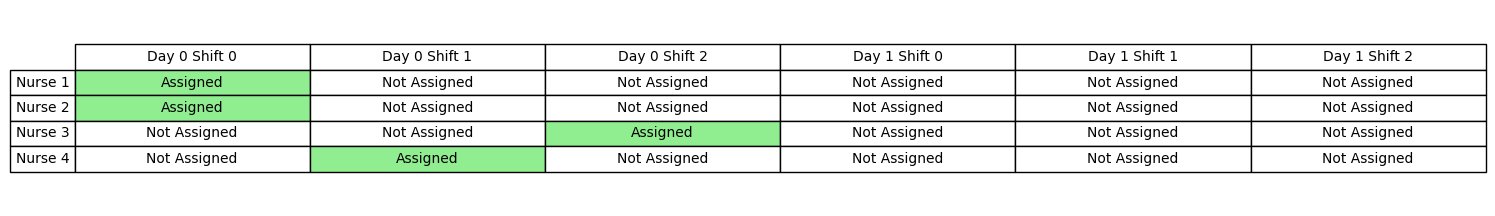

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) == (shifts[0,2,0]), (shifts[0,0,0]) >= (shifts[0,2,0]), (shifts[0,0,1]) >= (shifts[0,2,0]), (shifts[0,1,0]) < (shifts[0,2,0]), (shifts[0,1,0]) == (shifts[0,2,0]), (shifts[0,1,0]) <= (shifts[0,2,0])]
Query60: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


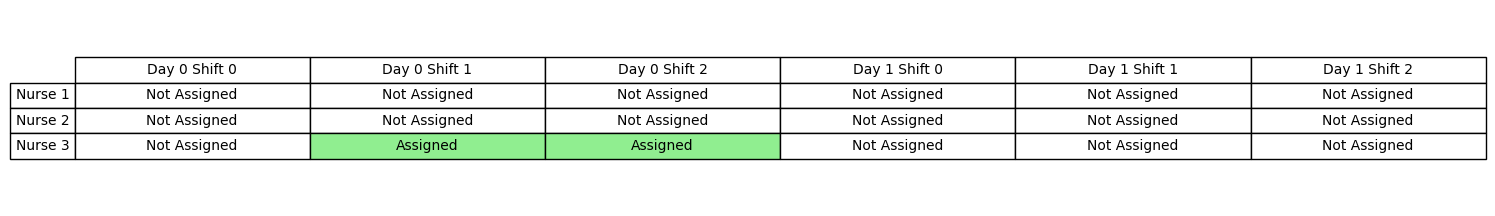

Answer:  No
Query61: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


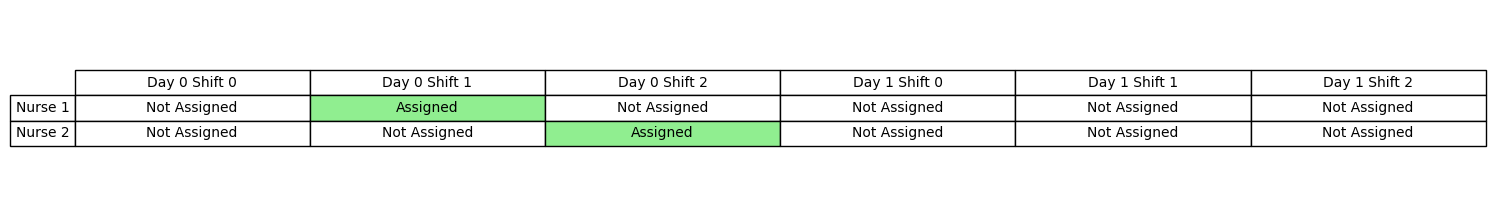

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[0,2,0])]
Query62: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


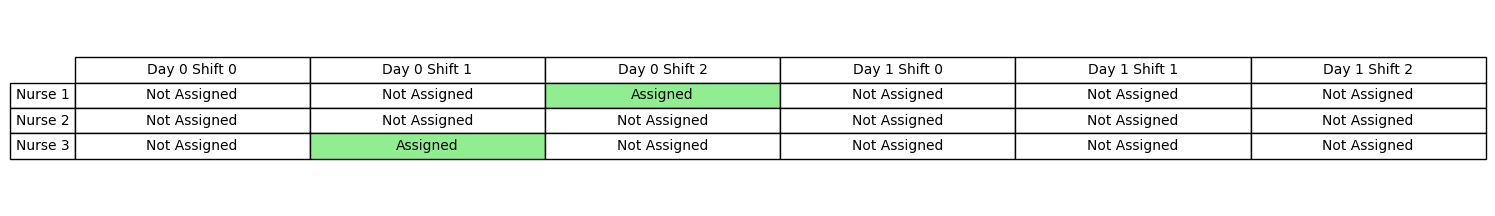

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) < (shifts[0,2,0])]
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,2,0])]
Size of CL:  9
Size of B:  343
Number of Queries:  63
Query63: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


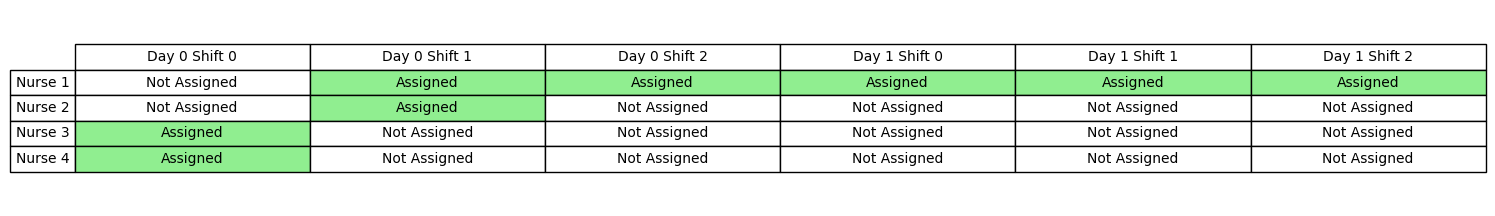

Answer:  No
Query64: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


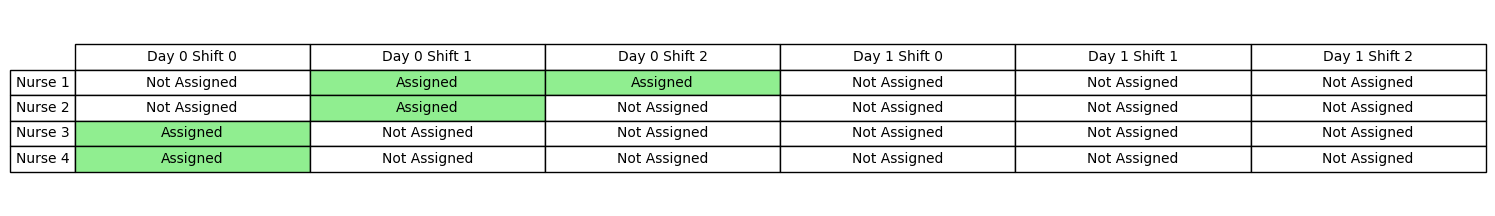

Answer:  No
Query65: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


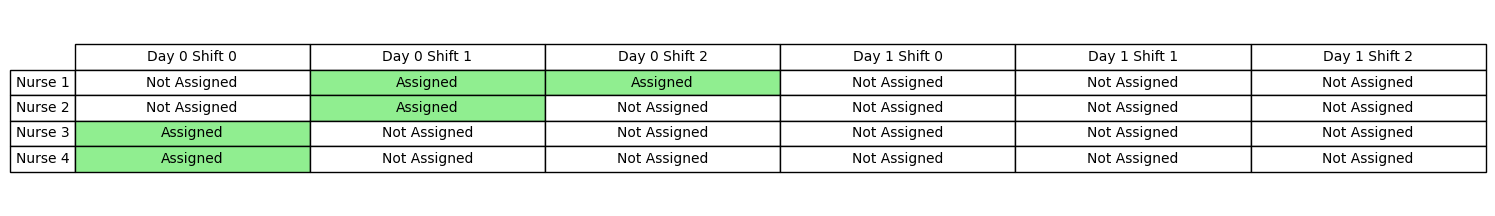

Answer:  No
Query66: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


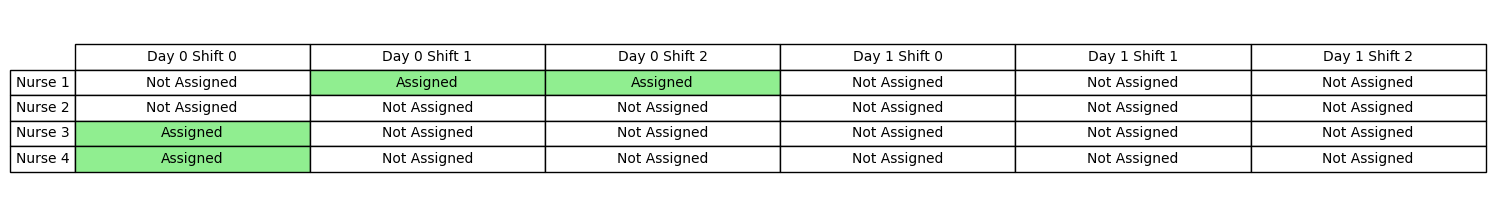

Answer:  No
Query67: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


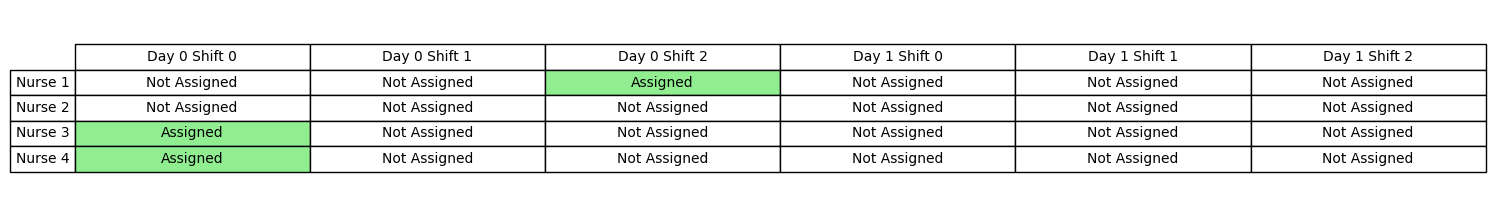

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) <= (shifts[0,2,0])]
Query68: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


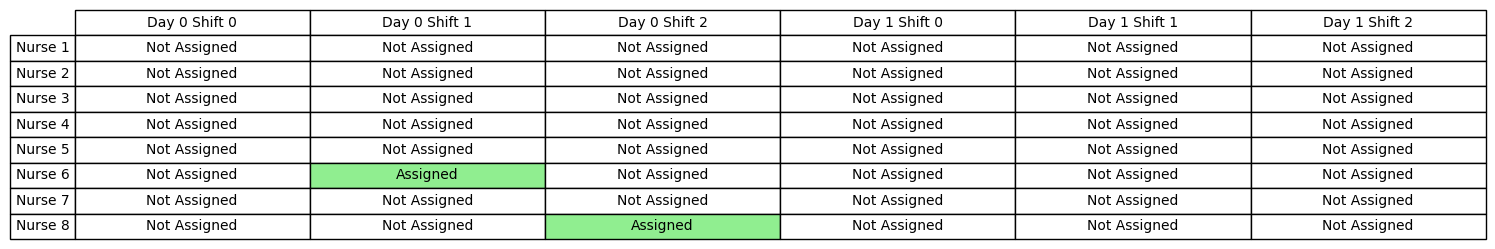

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[0,2,0])]
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,2,0])]
Size of CL:  10
Size of B:  340
Number of Queries:  69
Query69: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


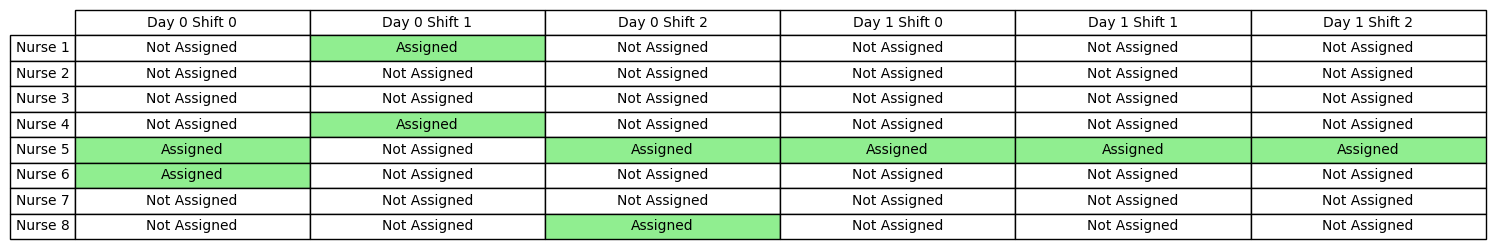

Answer:  No
Query70: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


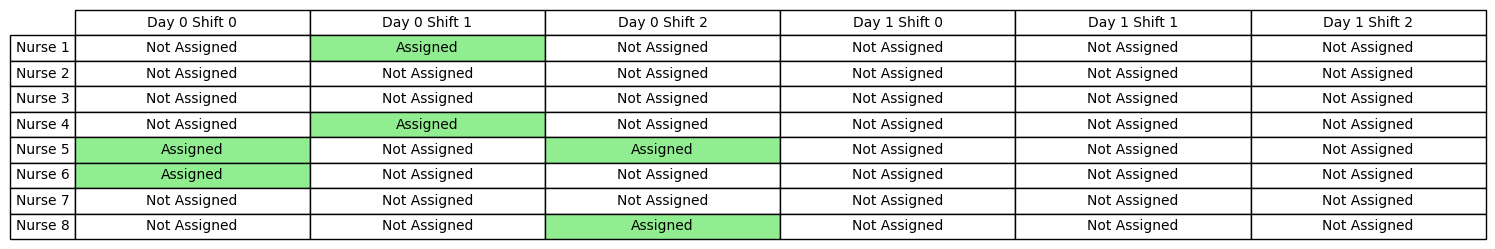

Answer:  No
Query71: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


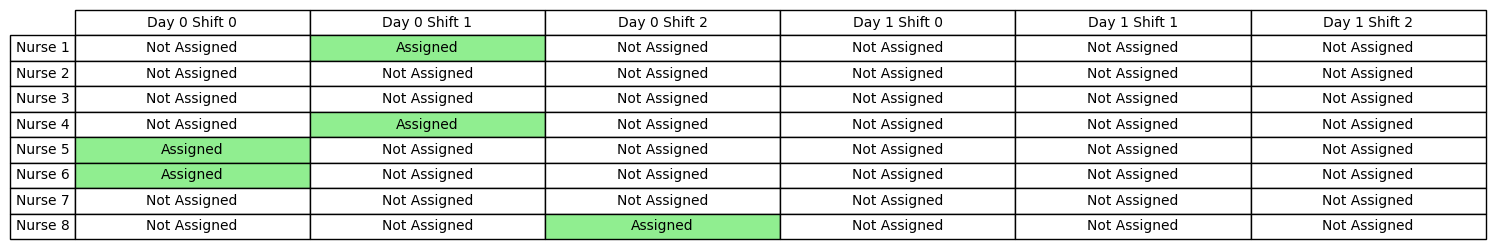

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) >= (shifts[0,2,0]), (shifts[0,1,1]) >= (shifts[0,2,0]), (shifts[0,1,1]) == (shifts[0,2,0])]
Query72: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


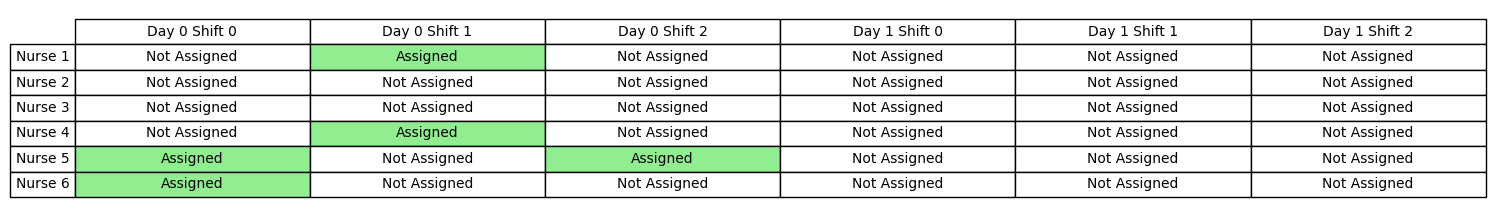

Answer:  No
Query73: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


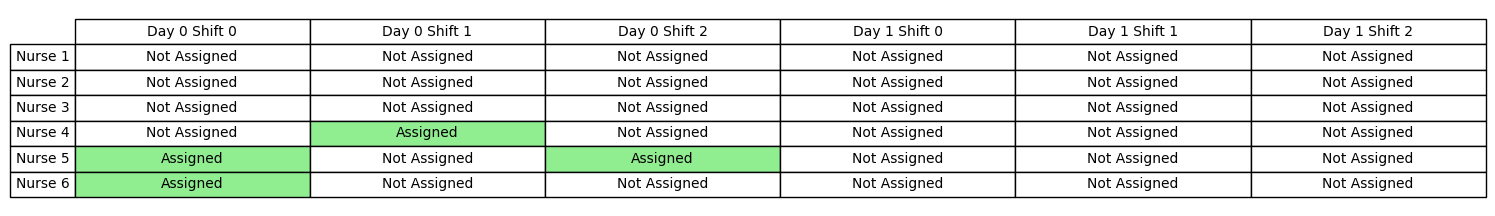

Answer:  No
Query74: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


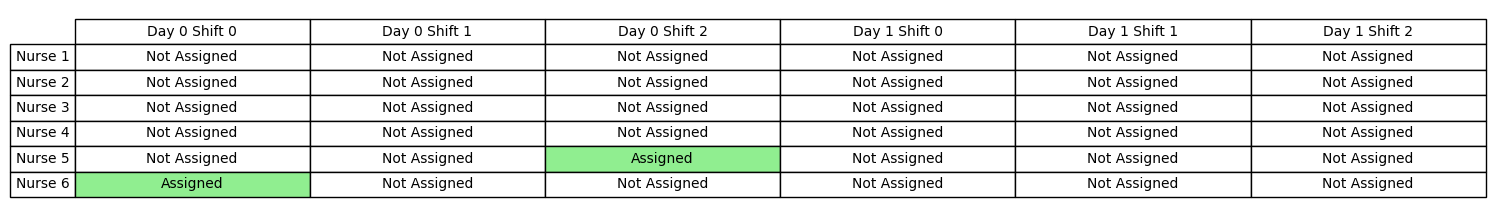

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,2,1]), (shifts[0,0,0]) <= (shifts[0,2,1]), (shifts[0,0,0]) == (shifts[0,2,1])]
Query75: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


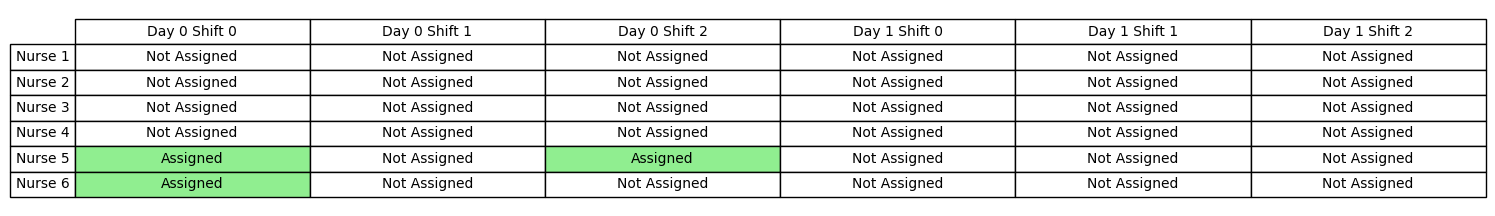

Answer:  No
Query76: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


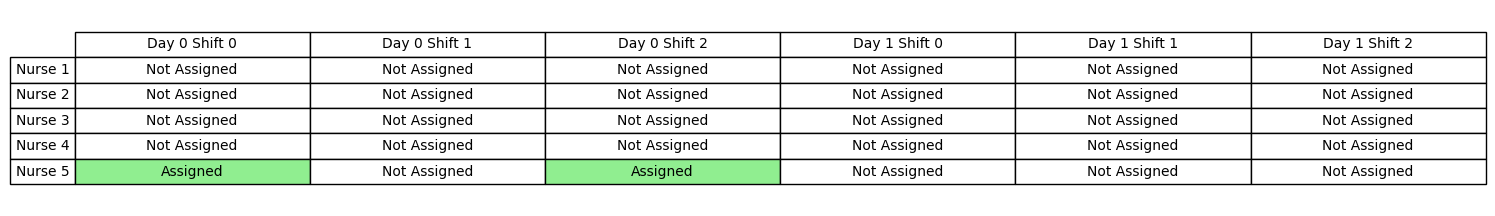

Answer:  No
Query77: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


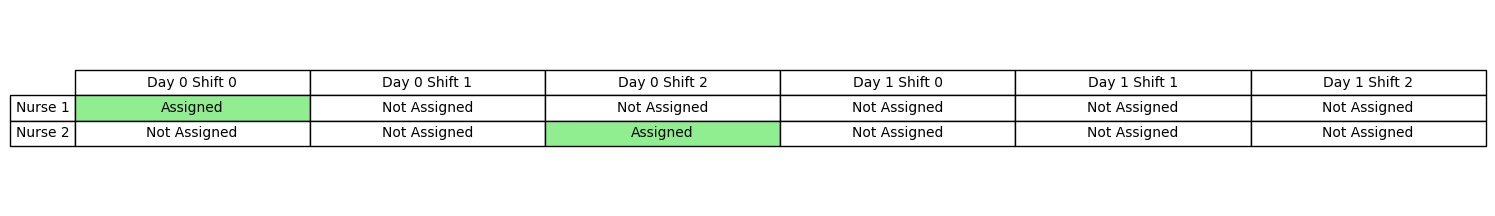

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) > (shifts[0,2,1])]
Query78: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


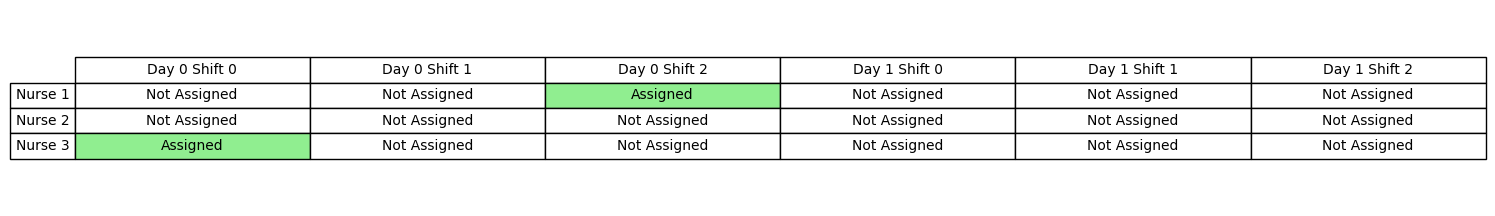

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) < (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,2,1])]
Size of CL:  11
Size of B:  331
Number of Queries:  79
Query79: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


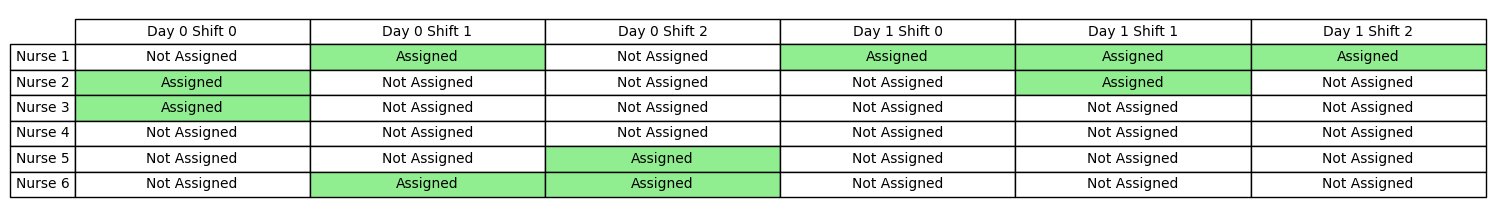

Answer:  No
Query80: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


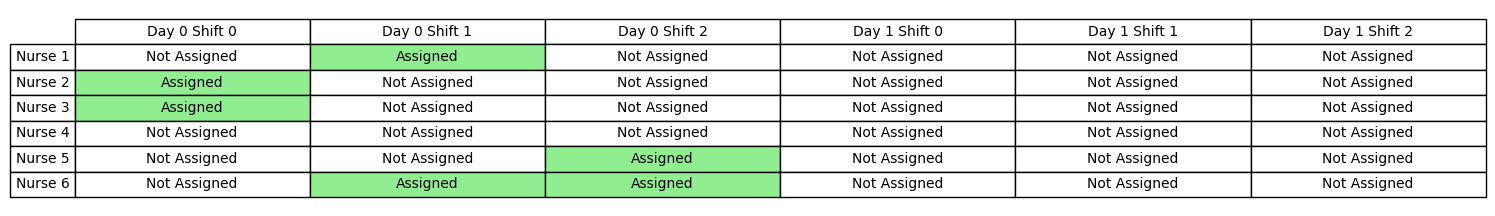

Answer:  No
Query81: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


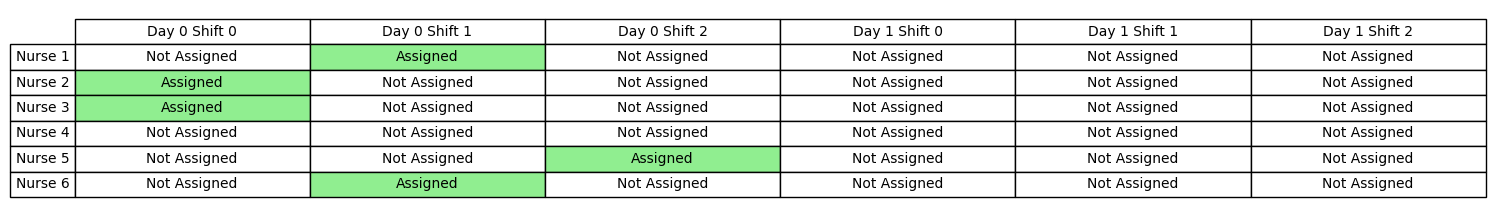

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) <= (shifts[0,2,0])]
Query82: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


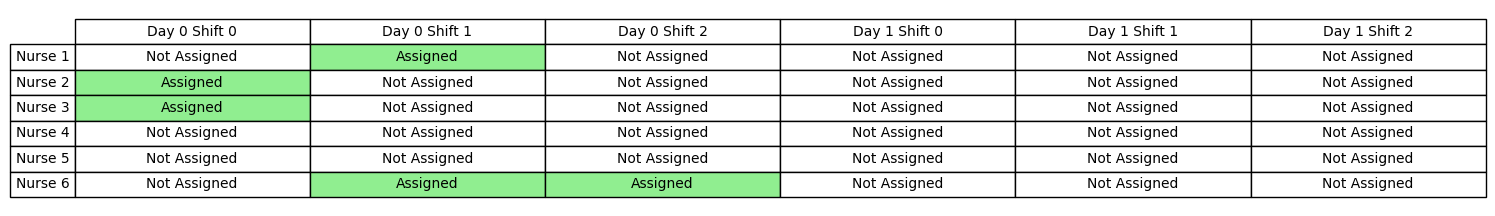

Answer:  No
Query83: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


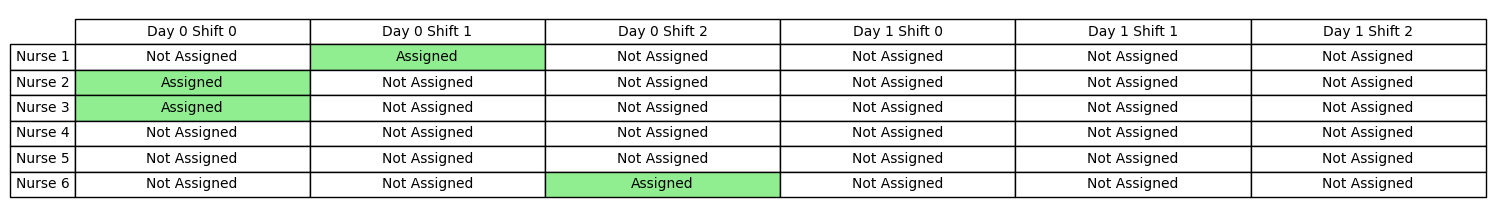

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) >= (shifts[0,2,1]), (shifts[0,0,0]) >= (shifts[0,2,1]), (shifts[0,1,0]) == (shifts[0,2,1]), (shifts[0,0,0]) > (shifts[0,2,1]), (shifts[0,1,0]) >= (shifts[0,2,1]), (shifts[0,1,0]) > (shifts[0,2,1]), (shifts[0,0,1]) == (shifts[0,2,1])]
Query84: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


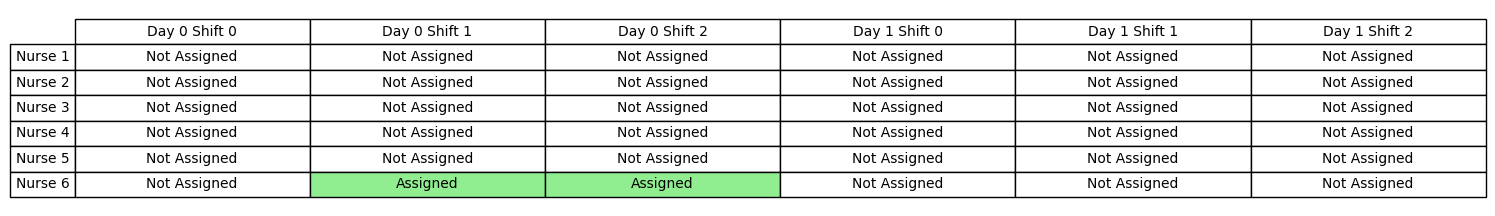

Answer:  No
Query85: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


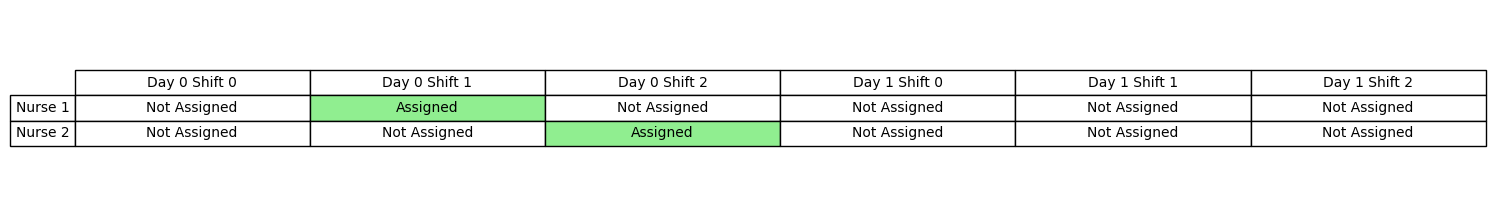

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[0,2,1])]
Query86: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


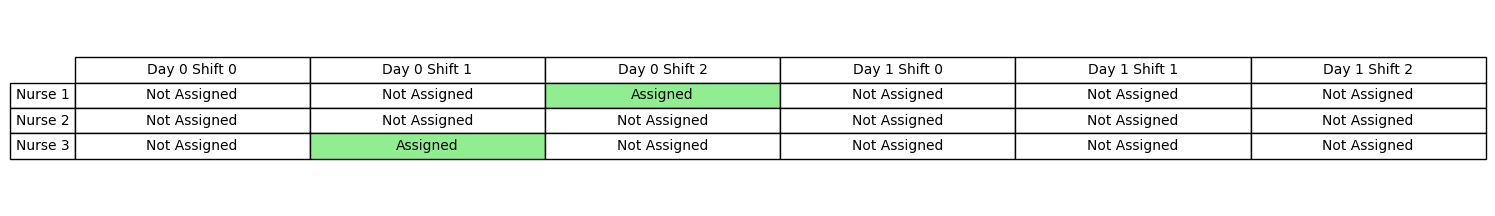

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) < (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,2,1])]
Size of CL:  12
Size of B:  320
Number of Queries:  87
Query87: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


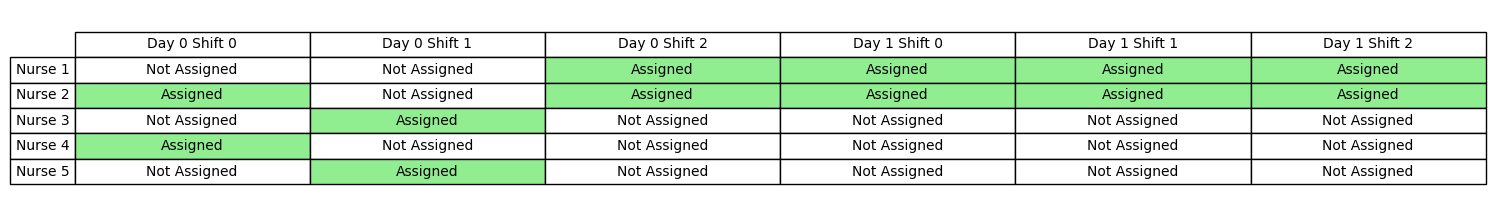

Answer:  No
Query88: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


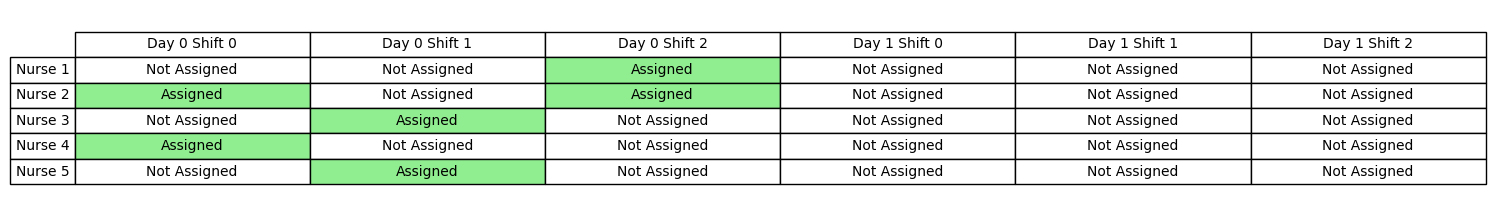

Answer:  No
Query89: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


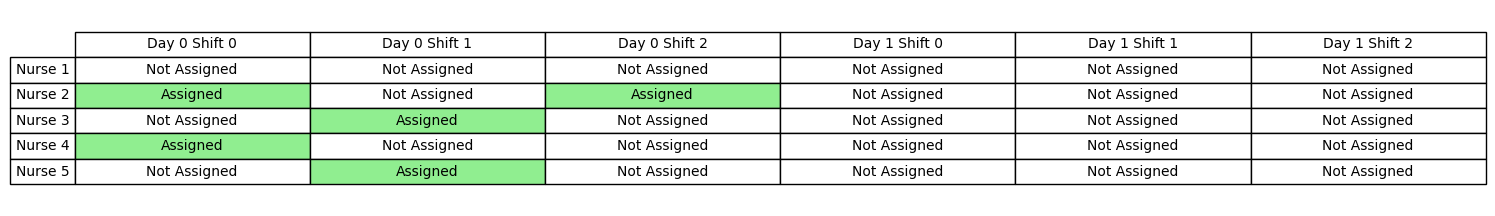

Answer:  No
Query90: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


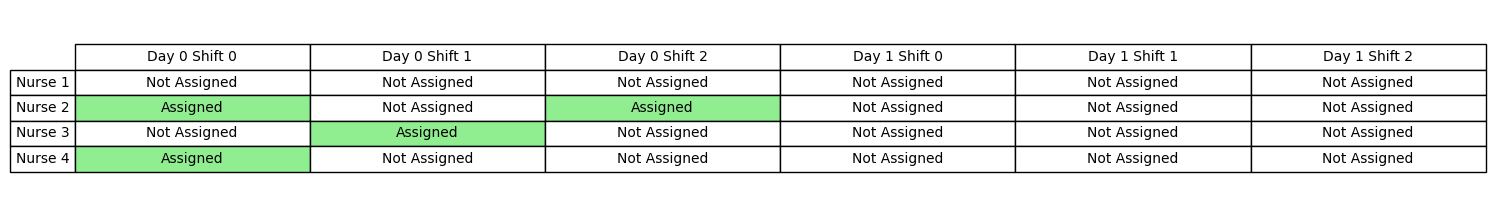

Answer:  No
Query91: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


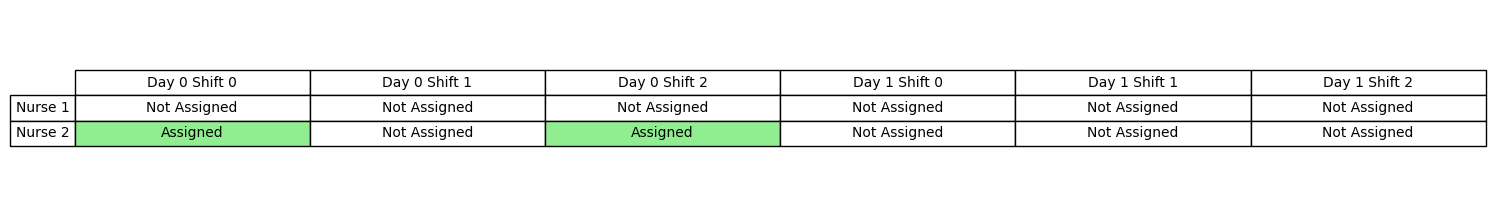

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,1])]
Size of CL:  13
Size of B:  319
Number of Queries:  92
Query92: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


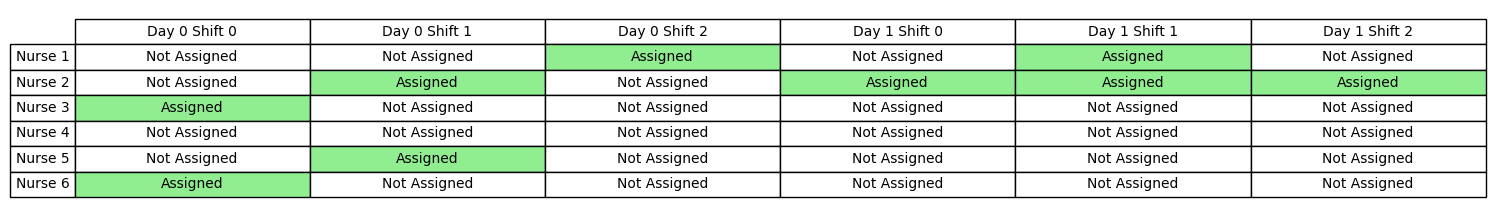

Answer:  No
Query93: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


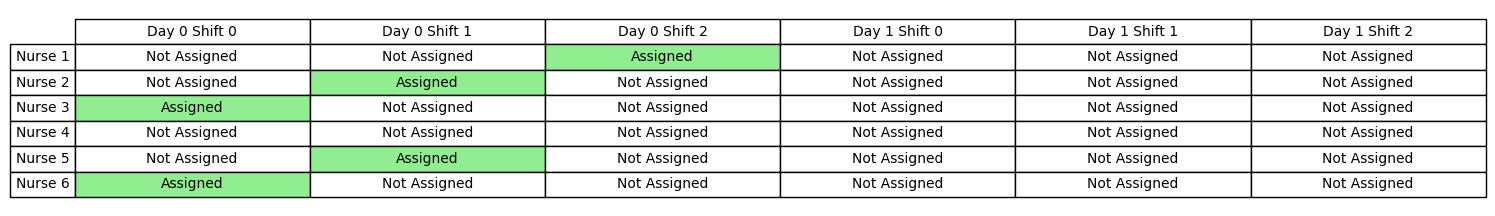

Answer:  No
Query94: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


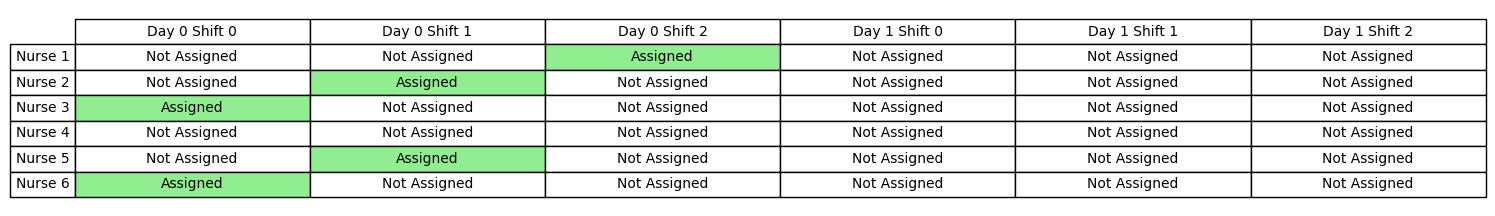

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) < (shifts[0,2,1]), (shifts[0,1,0]) <= (shifts[0,2,1]), (shifts[0,1,1]) <= (shifts[0,2,1]), (shifts[0,0,1]) <= (shifts[0,2,1]), (shifts[0,1,1]) == (shifts[0,2,1])]
Query95: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


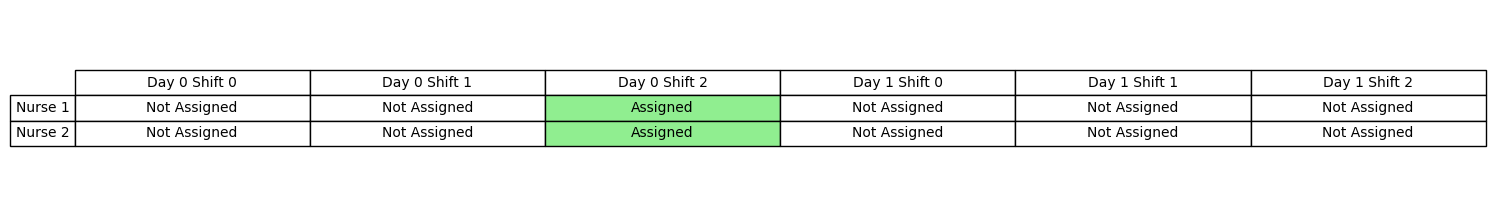

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) > (shifts[0,2,1])]
Query96: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


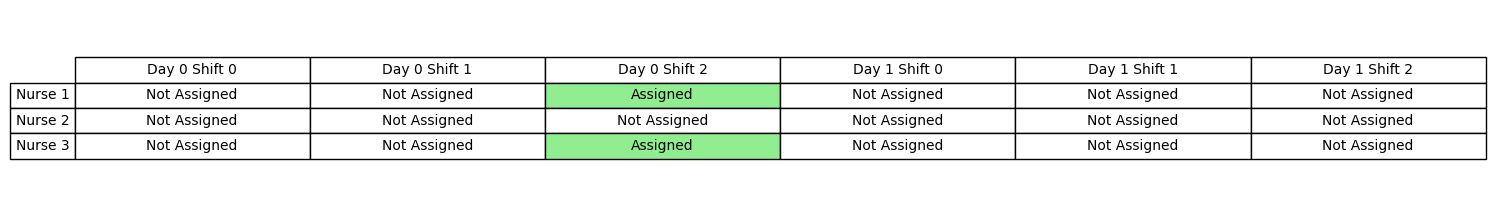

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,2,1])]
Size of CL:  14
Size of B:  311
Number of Queries:  97
Query97: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


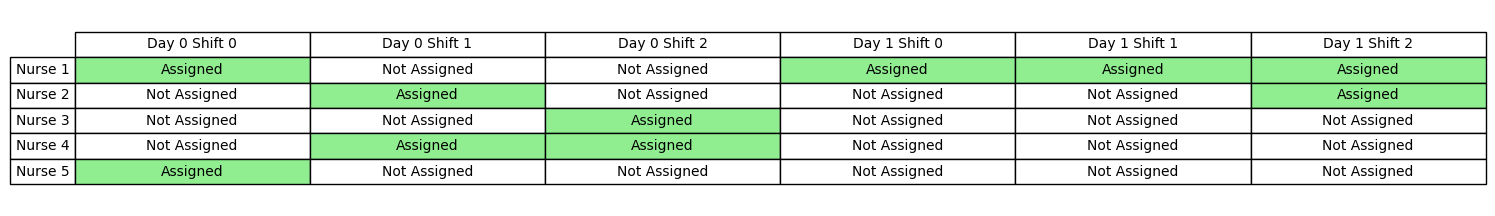

Answer:  No
Query98: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


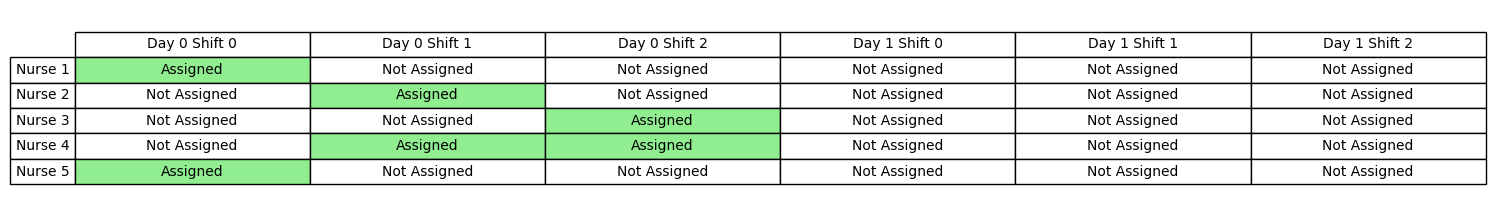

Answer:  No
Query99: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


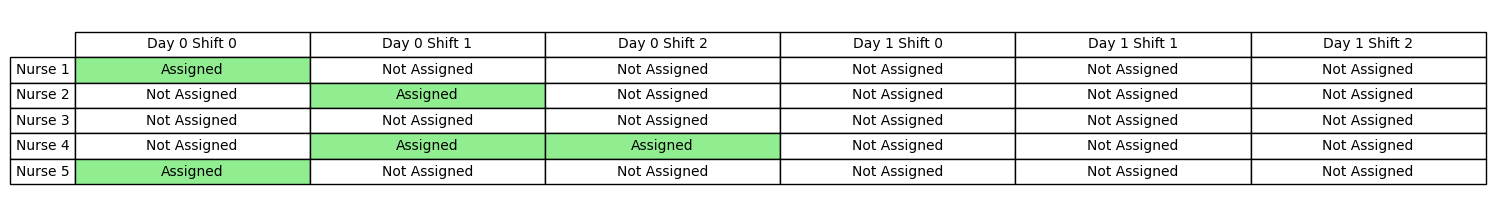

Answer:  No
Query100: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


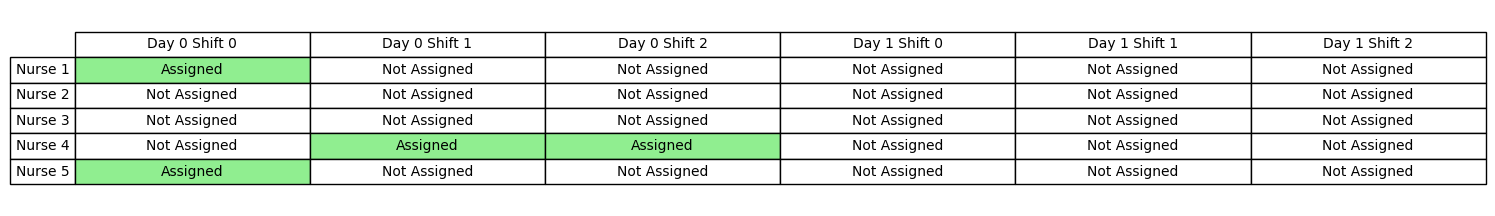

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,2,1])]
Size of CL:  15
Size of B:  310
Number of Queries:  101
Query101: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


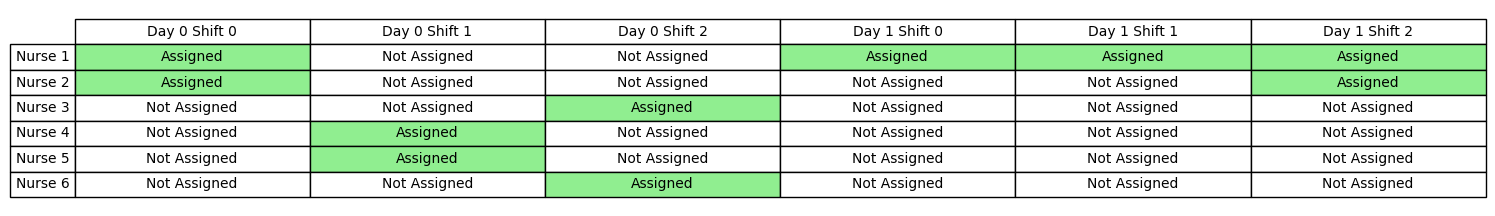

Answer:  No
Query102: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


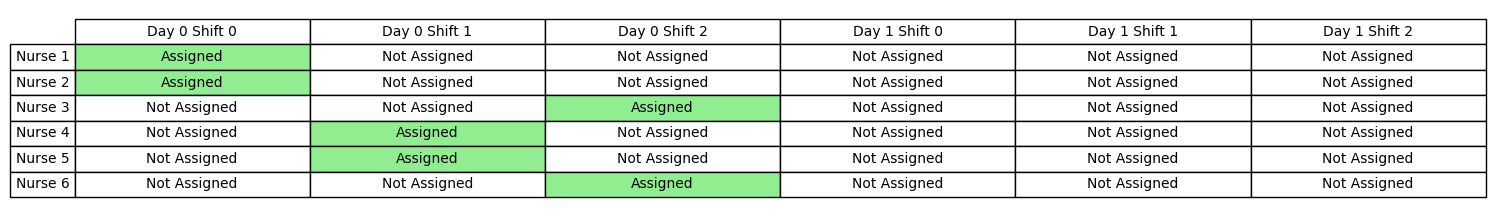

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) >= (shifts[0,2,1]), (shifts[0,2,0]) == (shifts[0,2,1]), (shifts[0,1,1]) >= (shifts[0,2,1])]
Query103: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


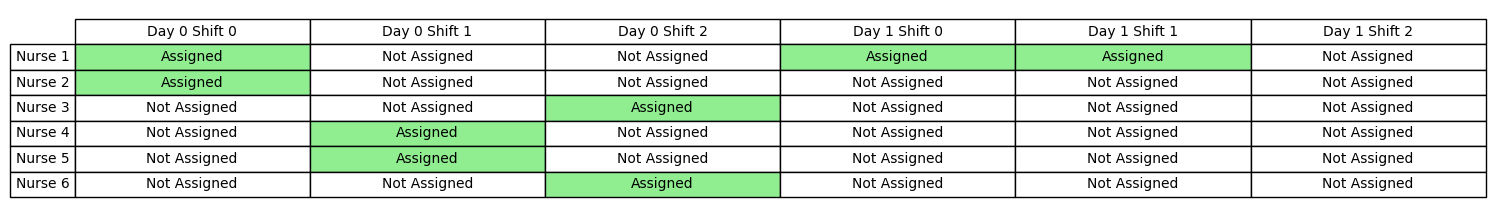

Answer:  No
Query104: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


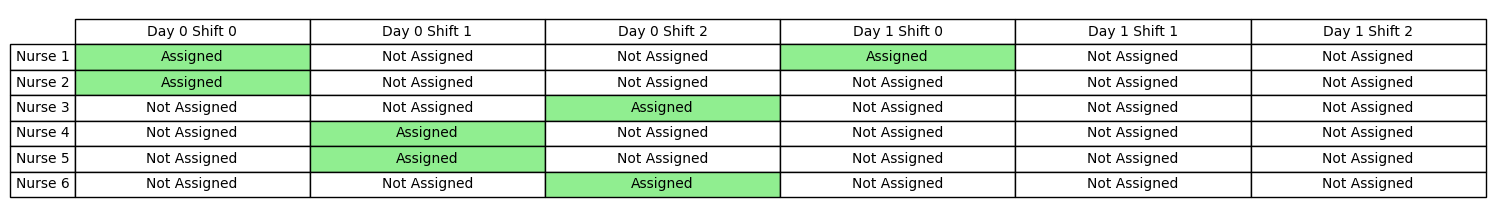

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) <= (shifts[1,0,0]), (shifts[0,0,1]) < (shifts[1,0,0]), (shifts[0,1,0]) < (shifts[1,0,0]), (shifts[0,1,1]) == (shifts[1,0,0]), (shifts[0,0,1]) == (shifts[1,0,0]), (shifts[0,2,0]) <= (shifts[1,0,0]), (shifts[0,2,1]) <= (shifts[1,0,0]), (shifts[0,0,0]) > (shifts[1,0,0]), (shifts[0,0,0]) < (shifts[1,0,0]), (shifts[0,2,0]) < (shifts[1,0,0]), (shifts[0,1,1]) < (shifts[1,0,0]), (shifts[0,2,1]) == (shifts[1,0,0]), (shifts[0,2,0]) == (shifts[1,0,0]), (shifts[0,0,1]) <= (shifts[1,0,0]), (shifts[0,1,0]) <= (shifts[1,0,0]), (shifts[0,1,0]) == (shifts[1,0,0]), (shifts[0,2,1]) < (shifts[1,0,0]), (shifts[0,0,0]) != (shifts[1,0,0])]
Query105: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


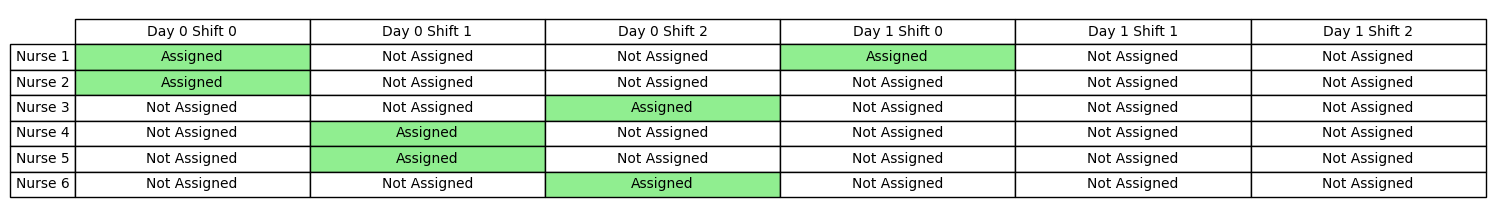

Answer:  No
Query106: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


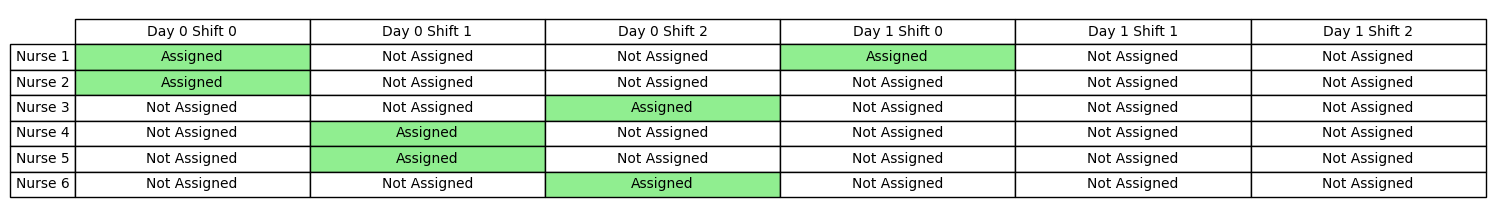

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[1,0,1]), (shifts[0,1,0]) < (shifts[1,0,1]), (shifts[0,1,1]) == (shifts[1,0,1]), (shifts[0,1,1]) < (shifts[1,0,1]), (shifts[0,2,0]) == (shifts[1,0,1]), (shifts[0,1,0]) == (shifts[1,0,1]), (shifts[0,0,1]) < (shifts[1,0,1]), (shifts[0,0,0]) != (shifts[1,0,1]), (shifts[0,2,1]) < (shifts[1,0,1]), (shifts[0,1,1]) <= (shifts[1,0,1]), (shifts[0,2,0]) <= (shifts[1,0,1]), (shifts[0,0,1]) == (shifts[1,0,1]), (shifts[0,2,1]) <= (shifts[1,0,1]), (shifts[0,1,0]) <= (shifts[1,0,1]), (shifts[0,2,1]) == (shifts[1,0,1]), (shifts[0,0,0]) < (shifts[1,0,1]), (shifts[0,0,0]) > (shifts[1,0,1]), (shifts[0,0,1]) <= (shifts[1,0,1])]
Query107: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


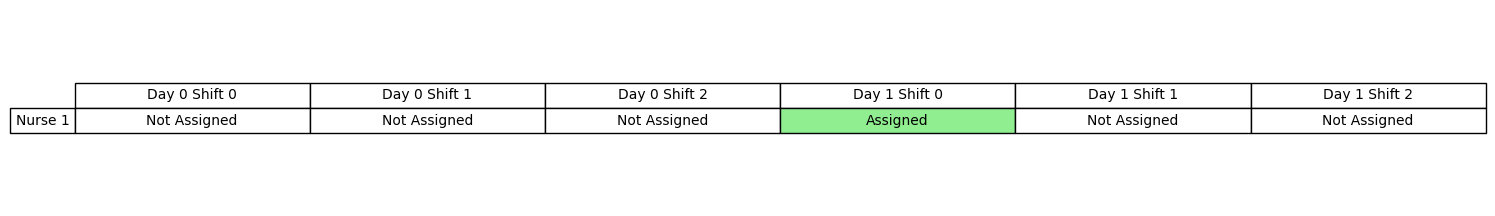

Answer:  No
Query108: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


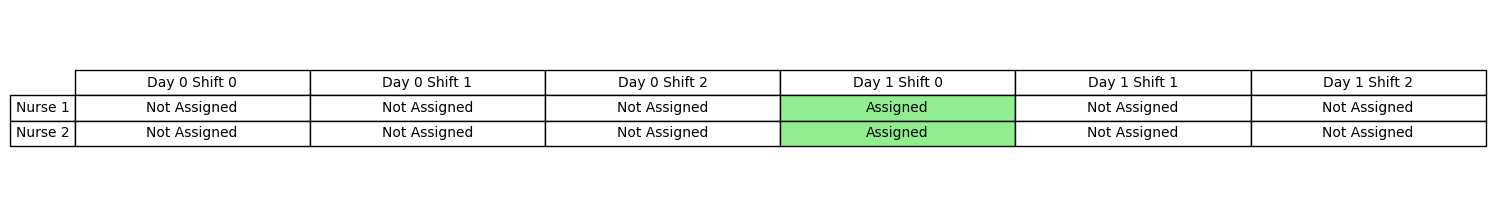

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) > (shifts[1,0,1])]
Query109: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


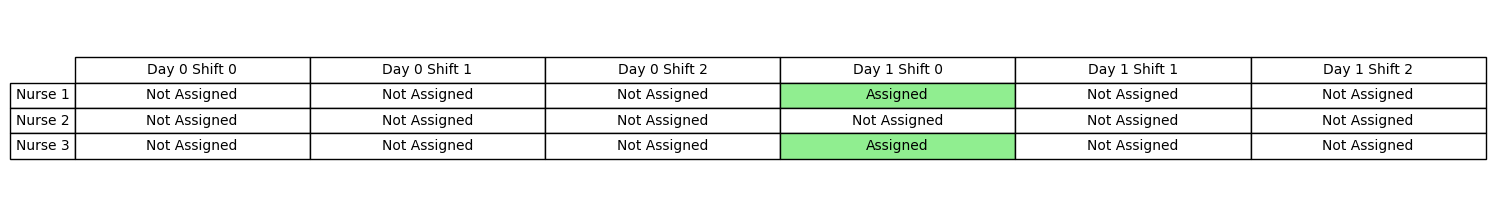

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) < (shifts[1,0,1])]
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,0,1])]
Size of CL:  16
Size of B:  268
Number of Queries:  110
Query110: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


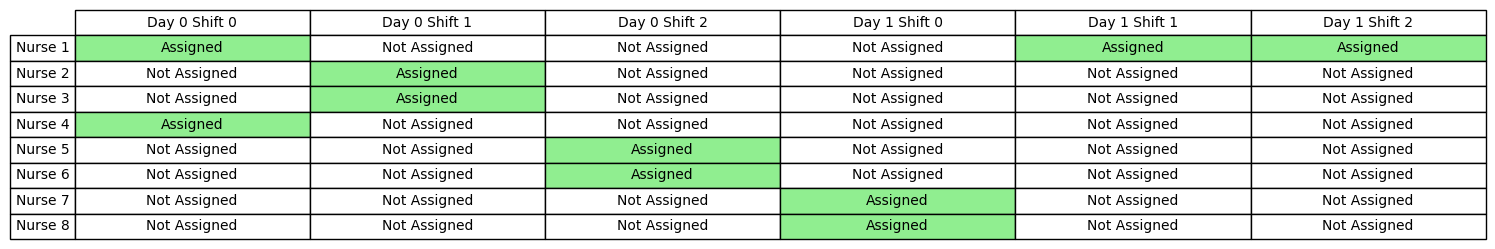

Answer:  No
Query111: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


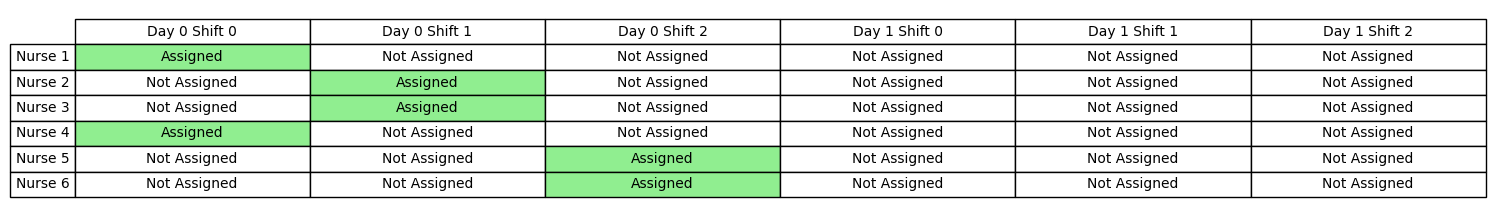

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) <= (shifts[0,2,1])]
Query112: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


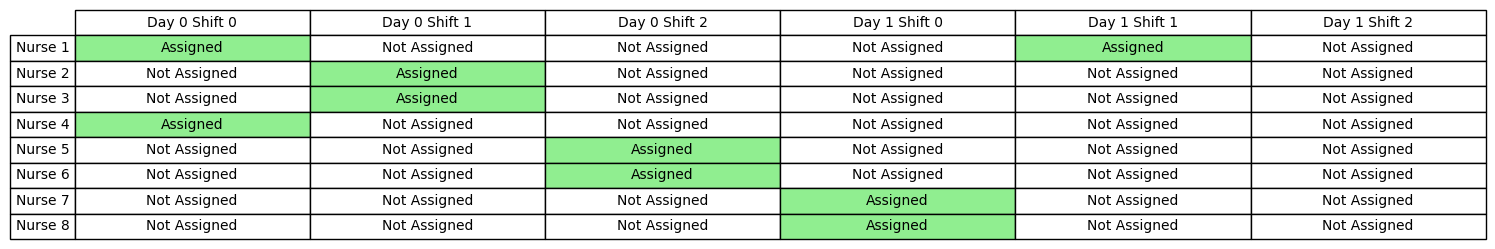

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[1,0,1]), (shifts[1,0,0]) <= (shifts[1,1,0]), (shifts[1,0,1]) == (shifts[1,1,0]), (shifts[0,2,1]) > (shifts[1,0,0]), (shifts[0,0,0]) >= (shifts[1,0,0]), (shifts[0,0,0]) < (shifts[1,1,0]), (shifts[0,0,0]) >= (shifts[1,0,1]), (shifts[0,1,0]) <= (shifts[1,1,0]), (shifts[0,1,1]) > (shifts[1,0,0]), (shifts[0,0,0]) == (shifts[1,1,0]), (shifts[1,0,1]) <= (shifts[1,1,0]), (shifts[0,1,1]) <= (shifts[1,1,0]), (shifts[0,1,0]) == (shifts[1,1,0]), (shifts[0,1,1]) == (shifts[1,1,0]), (shifts[0,2,0]) > (shifts[1,0,1]), (shifts[0,2,1]) < (shifts[1,1,0]), (shifts[0,0,0]) == (shifts[1,0,0]), (shifts[0,1,0]) >= (shifts[1,0,0]), (shifts[0,2,1]) == (shifts[1,1,0]), (shifts[0,1,1]) < (shifts[1,1,0]), (shifts[1,0,0]) >= (shifts[1,0,1]), (shifts[0,1,0]) > (shifts[1,0,1]), (shifts[0,2,0]) >= (shifts[1,0,0]), (shifts[0,1,1]) >= (shifts[1,0,1]), (shifts[0,0,1]) > (shifts[1,1,0]), (shifts[0,0,1]) >= (shifts[1,0,0]), (shifts[0,0,1

C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


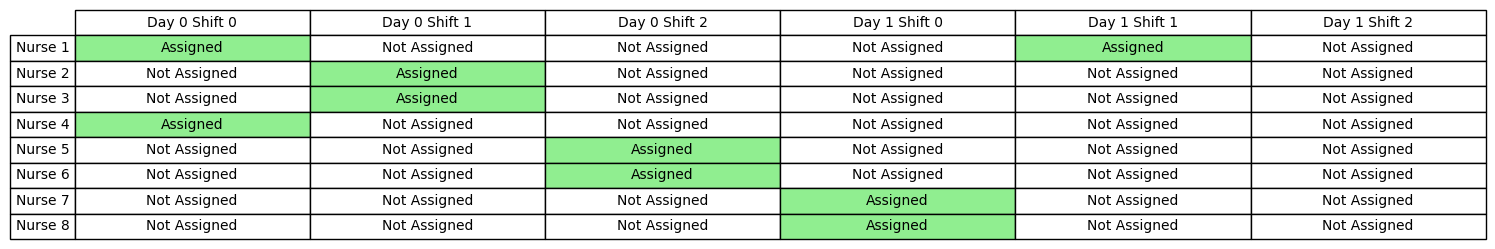

Answer:  No
Query114: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


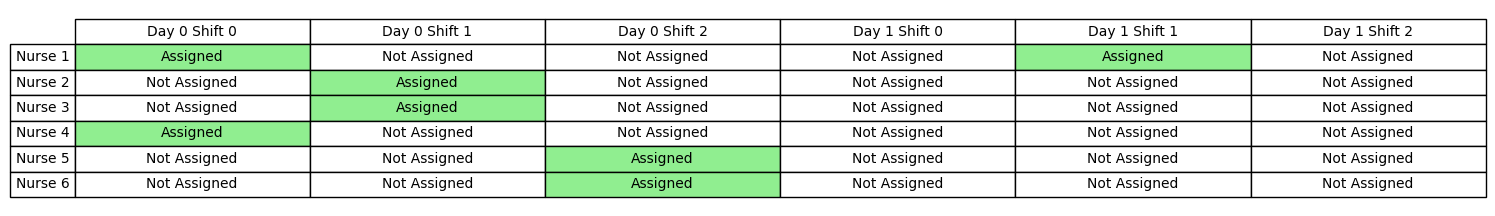

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) == (shifts[1,1,1]), (shifts[0,0,1]) > (shifts[1,1,1]), (shifts[0,1,1]) == (shifts[1,1,1]), (shifts[0,2,0]) < (shifts[1,1,1]), (shifts[0,1,0]) <= (shifts[1,1,1]), (shifts[0,1,0]) == (shifts[1,1,1]), (shifts[0,1,1]) < (shifts[1,1,1]), (shifts[0,2,0]) == (shifts[1,1,1]), (shifts[0,2,1]) < (shifts[1,1,1]), (shifts[0,0,0]) <= (shifts[1,1,1]), (shifts[0,1,1]) <= (shifts[1,1,1]), (shifts[0,2,1]) == (shifts[1,1,1]), (shifts[0,0,1]) < (shifts[1,1,1]), (shifts[0,2,1]) <= (shifts[1,1,1]), (shifts[0,0,0]) < (shifts[1,1,1]), (shifts[0,1,0]) < (shifts[1,1,1]), (shifts[0,0,1]) != (shifts[1,1,1]), (shifts[0,2,0]) <= (shifts[1,1,1])]
Query115: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


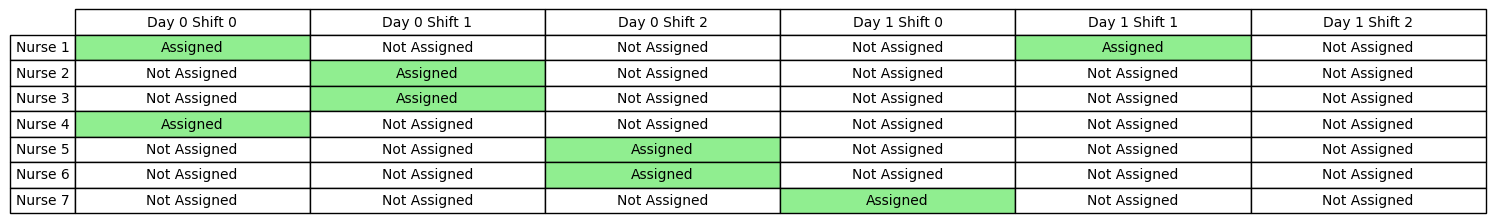

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) == (shifts[1,1,1]), (shifts[1,0,0]) < (shifts[1,1,1]), (shifts[1,0,0]) <= (shifts[1,1,1])]
Query116: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


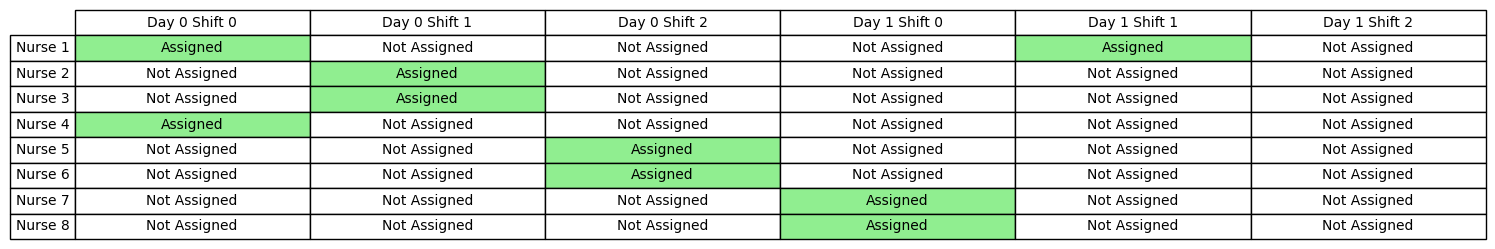

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) <= (shifts[1,1,1]), (shifts[1,0,1]) == (shifts[1,1,1]), (shifts[1,0,1]) < (shifts[1,1,1])]
Query117: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


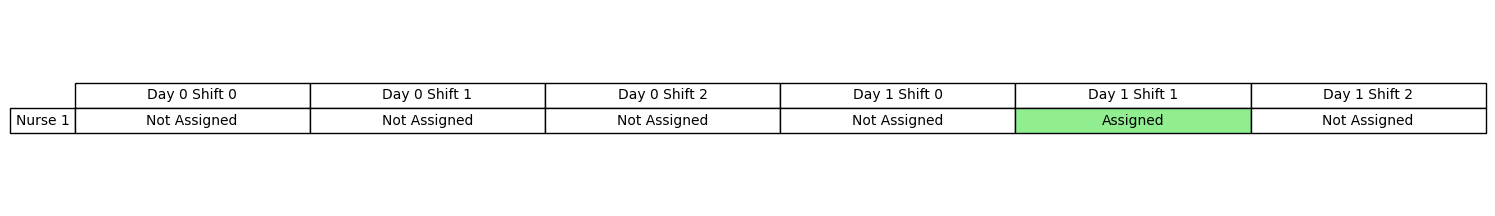

Answer:  No
Query118: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


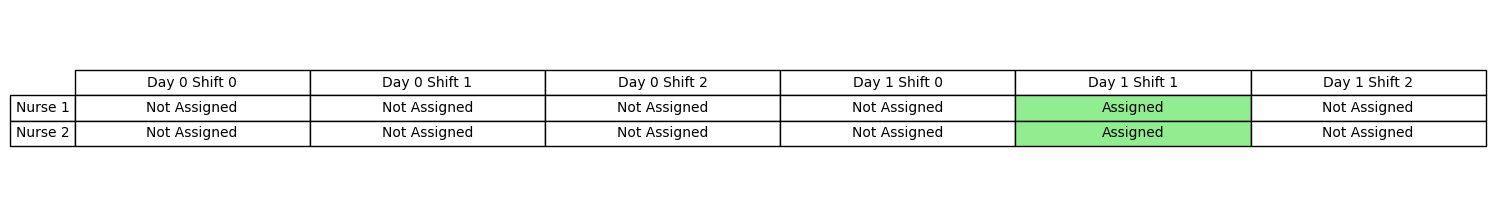

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) < (shifts[1,1,1])]
Query119: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


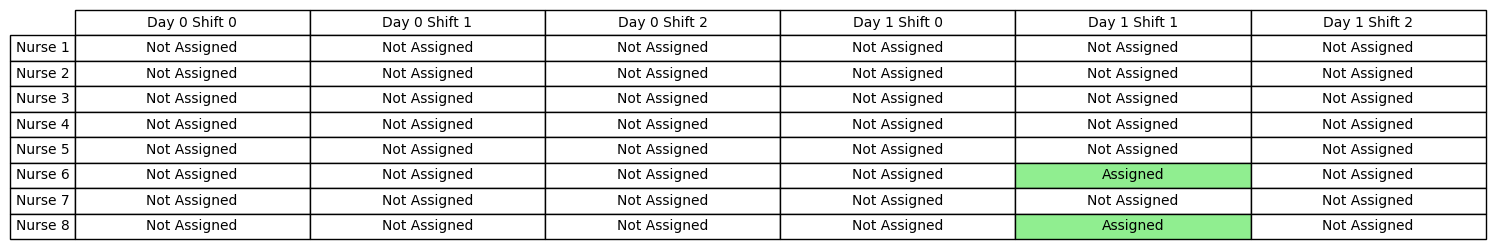

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) > (shifts[1,1,1])]
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,1,1])]
Size of CL:  17
Size of B:  190
Number of Queries:  120
Query120: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


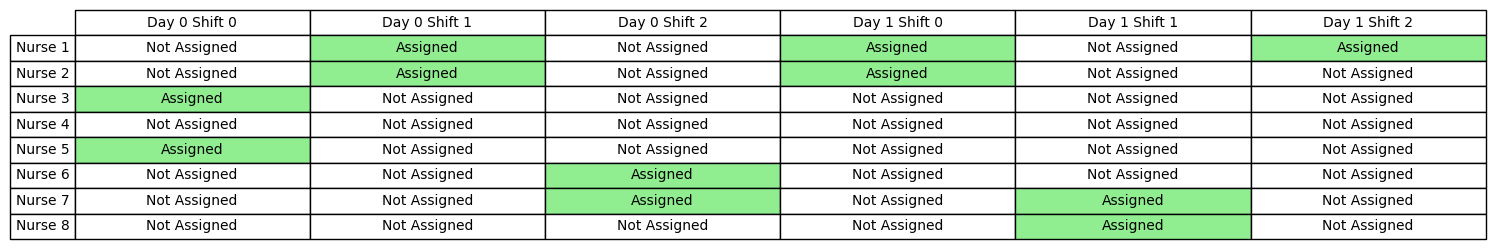

Answer:  No
Query121: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


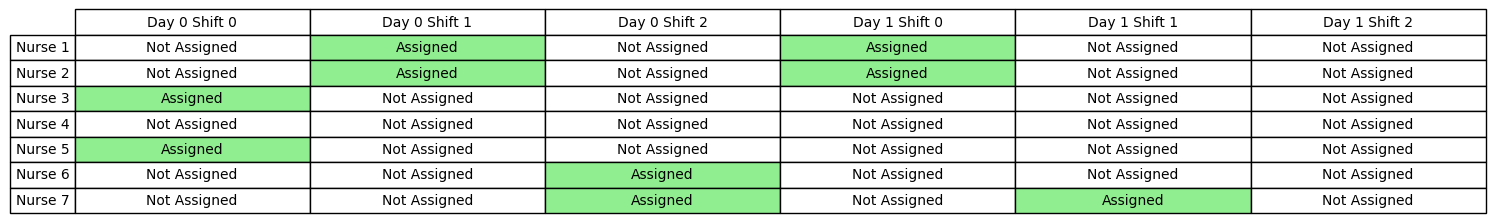

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) <= (shifts[1,0,0]), (shifts[0,2,1]) >= (shifts[1,1,0]), (shifts[0,0,0]) >= (shifts[1,1,0]), (shifts[0,0,1]) == (shifts[1,1,0]), (shifts[0,2,0]) > (shifts[1,1,0]), (shifts[0,0,0]) > (shifts[1,1,0]), (shifts[0,1,0]) != (shifts[1,0,0]), (shifts[0,0,0]) <= (shifts[1,0,1]), (shifts[1,0,1]) >= (shifts[1,1,0]), (shifts[0,1,1]) != (shifts[1,0,1]), (shifts[1,0,1]) > (shifts[1,1,0]), (shifts[1,0,0]) <= (shifts[1,0,1]), (shifts[0,0,1]) >= (shifts[1,1,0]), (shifts[0,1,0]) >= (shifts[1,1,0]), (shifts[0,1,1]) > (shifts[1,1,0]), (shifts[1,0,0]) >= (shifts[1,1,0]), (shifts[0,2,0]) != (shifts[1,1,0]), (shifts[0,1,0]) > (shifts[1,1,0]), (shifts[0,2,1]) > (shifts[1,1,0]), (shifts[0,1,1]) >= (shifts[1,1,0]), (shifts[1,0,0]) > (shifts[1,1,0])]
Query122: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


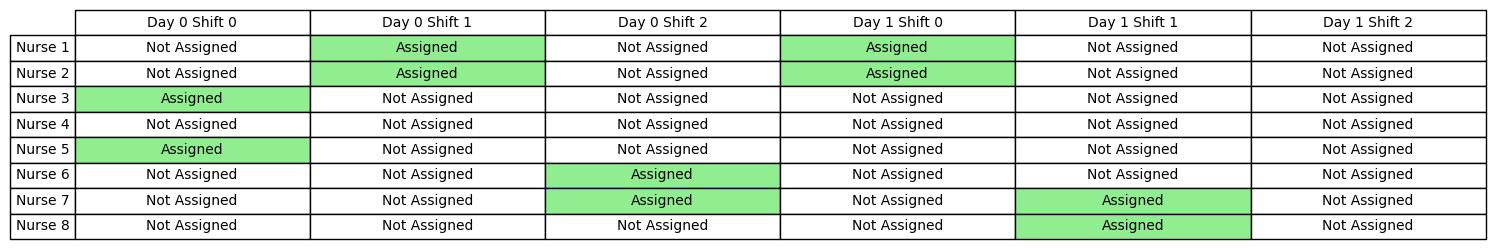

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) > (shifts[1,1,1]), (shifts[1,0,1]) >= (shifts[1,1,1]), (shifts[0,1,0]) >= (shifts[1,1,1]), (shifts[0,1,1]) > (shifts[1,1,1]), (shifts[0,0,1]) >= (shifts[1,1,1]), (shifts[0,0,0]) > (shifts[1,1,1]), (shifts[0,0,1]) == (shifts[1,1,1]), (shifts[0,2,1]) >= (shifts[1,1,1]), (shifts[1,1,0]) >= (shifts[1,1,1]), (shifts[0,2,1]) > (shifts[1,1,1]), (shifts[0,1,0]) > (shifts[1,1,1]), (shifts[0,1,1]) >= (shifts[1,1,1]), (shifts[0,2,0]) >= (shifts[1,1,1]), (shifts[1,0,1]) > (shifts[1,1,1]), (shifts[0,2,0]) > (shifts[1,1,1]), (shifts[1,1,0]) == (shifts[1,1,1]), (shifts[1,0,0]) >= (shifts[1,1,1]), (shifts[0,0,0]) >= (shifts[1,1,1])]
Query123: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


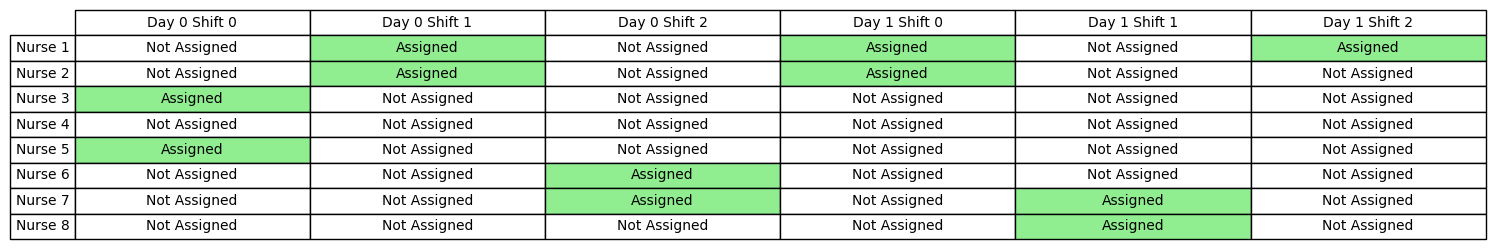

Answer:  No
Query124: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


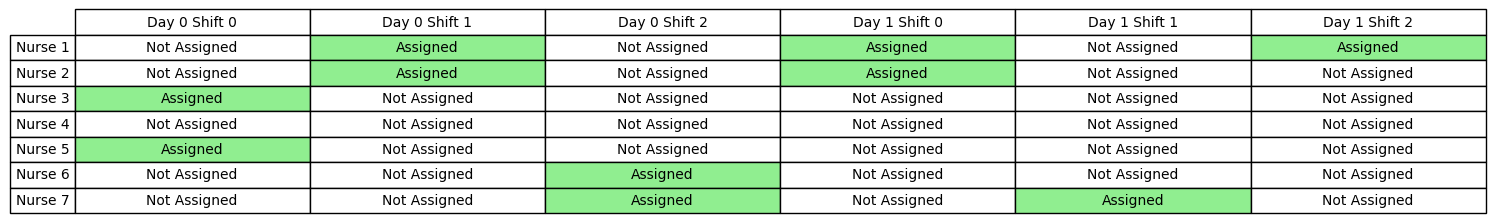

Answer:  No
Query125: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


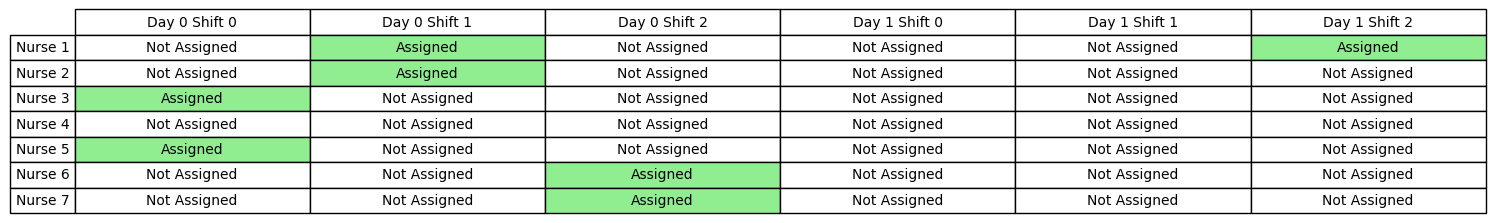

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) <= (shifts[1,2,0]), (shifts[0,1,1]) != (shifts[1,2,0]), (shifts[0,1,0]) < (shifts[1,2,0]), (shifts[0,1,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) < (shifts[1,2,0]), (shifts[0,0,0]) < (shifts[1,2,0]), (shifts[0,1,1]) > (shifts[1,2,0]), (shifts[0,0,0]) == (shifts[1,2,0]), (shifts[0,2,1]) < (shifts[1,2,0]), (shifts[0,2,0]) < (shifts[1,2,0]), (shifts[0,2,0]) <= (shifts[1,2,0]), (shifts[0,1,0]) == (shifts[1,2,0]), (shifts[0,0,0]) <= (shifts[1,2,0]), (shifts[0,0,1]) == (shifts[1,2,0]), (shifts[0,0,1]) <= (shifts[1,2,0]), (shifts[0,0,1]) < (shifts[1,2,0]), (shifts[0,2,1]) == (shifts[1,2,0]), (shifts[0,2,0]) == (shifts[1,2,0])]
Query126: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


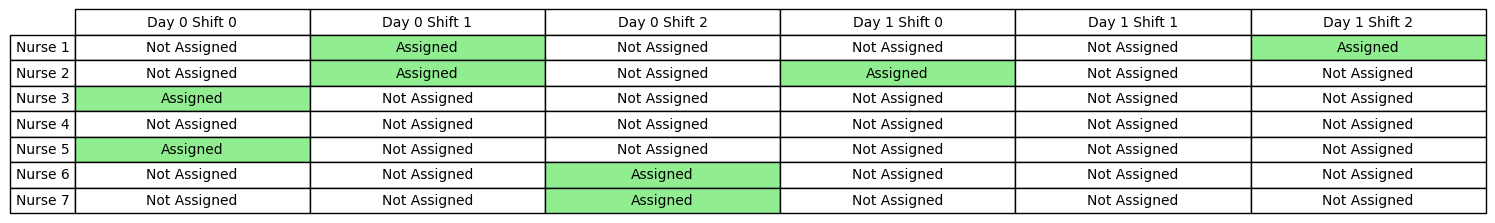

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) <= (shifts[1,2,0]), (shifts[1,0,0]) < (shifts[1,2,0]), (shifts[1,0,0]) == (shifts[1,2,0])]
Query127: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


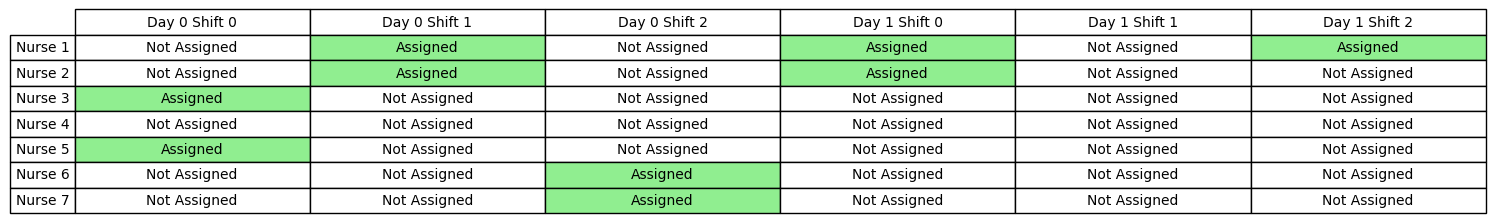

Answer:  No
Query128: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


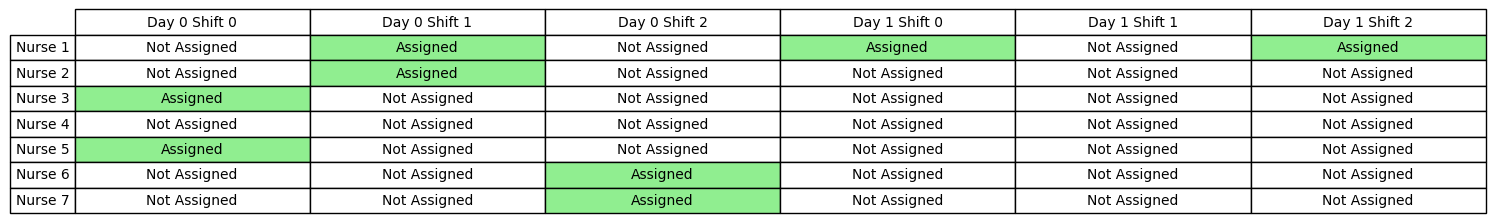

Answer:  No
Query129: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


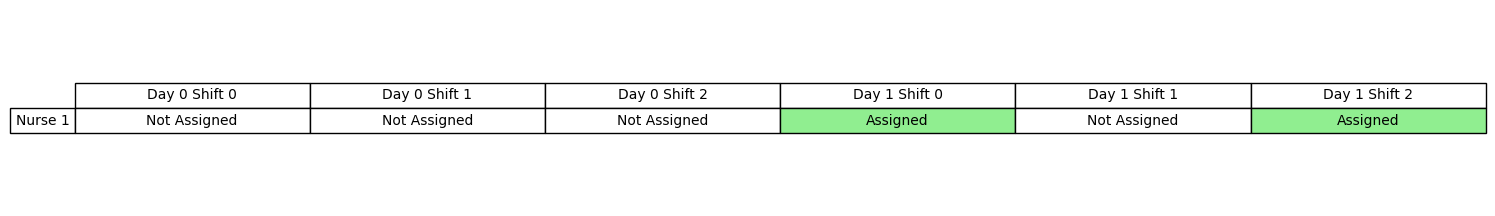

Answer:  No
Query130: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


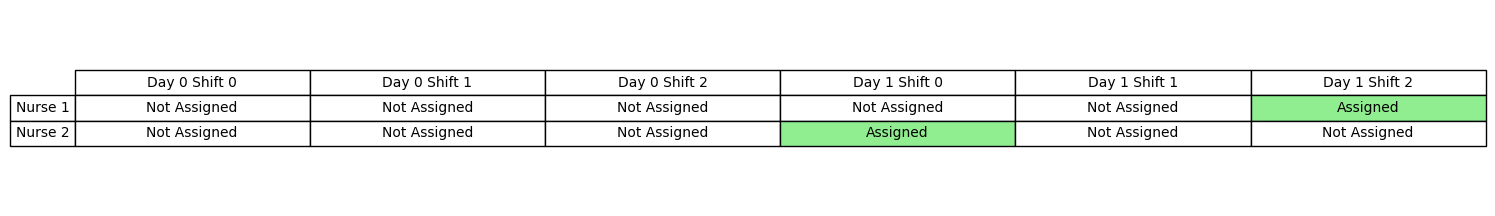

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) < (shifts[1,2,0])]
Query131: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


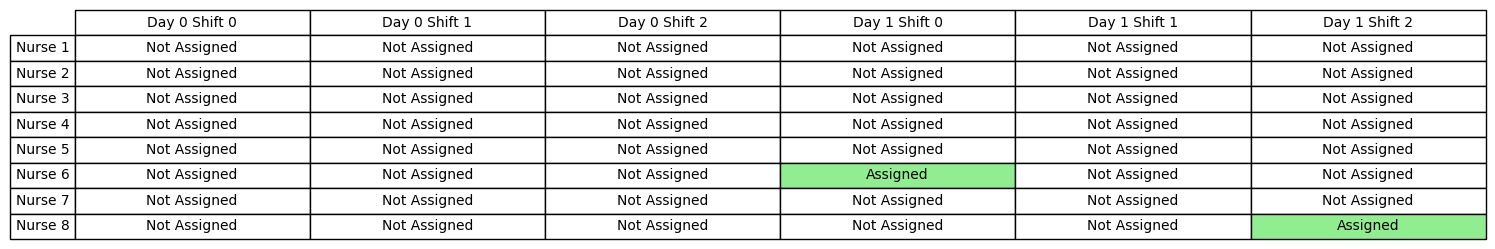

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) > (shifts[1,2,0])]
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,2,0])]
Size of CL:  18
Size of B:  127
Number of Queries:  132
Query132: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


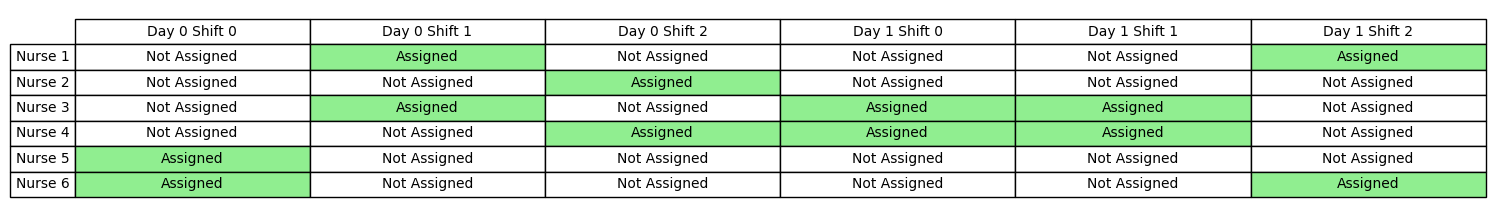

Answer:  No
Query133: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


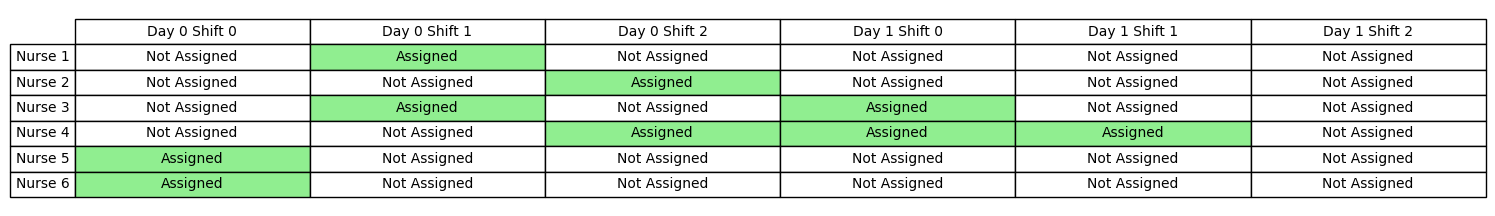

Answer:  No
Query134: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


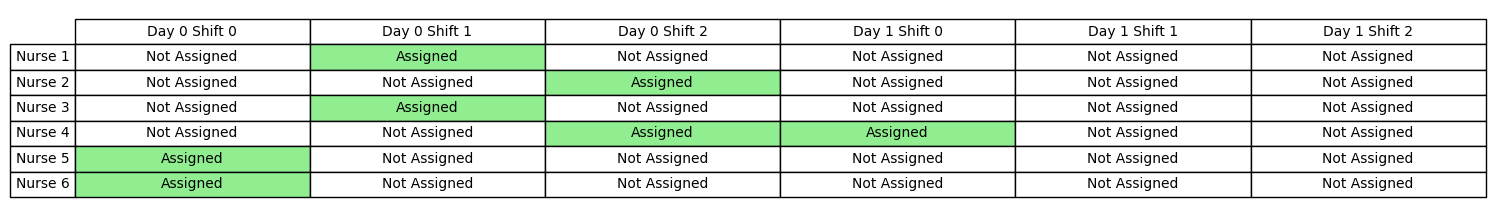

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[1,0,0])]
Size of CL:  19
Size of B:  126
Number of Queries:  135
Query135: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


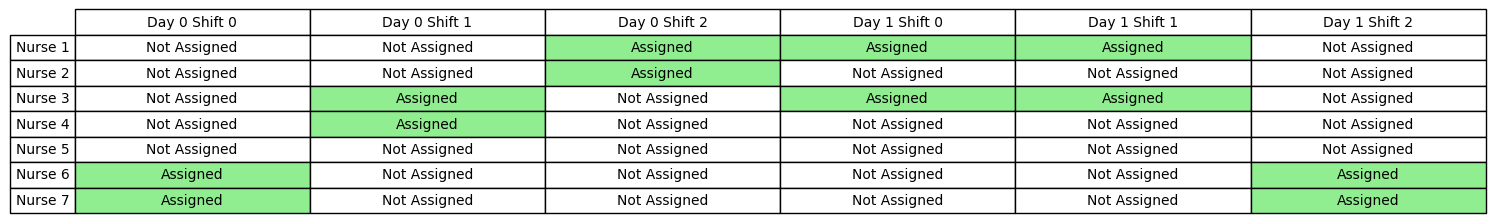

Answer:  No
Query136: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


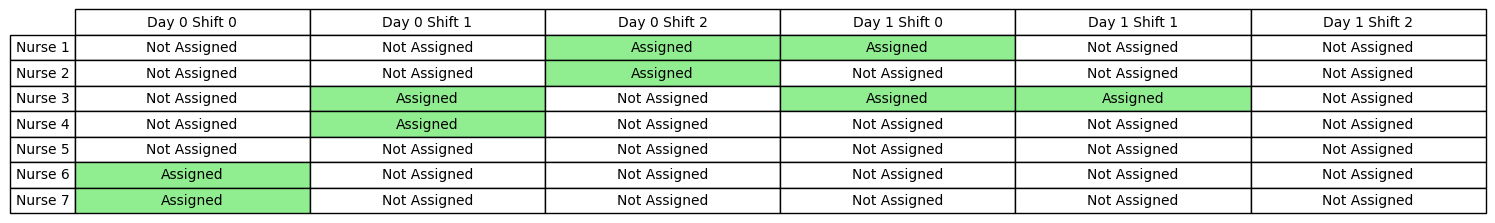

Answer:  No
Query137: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


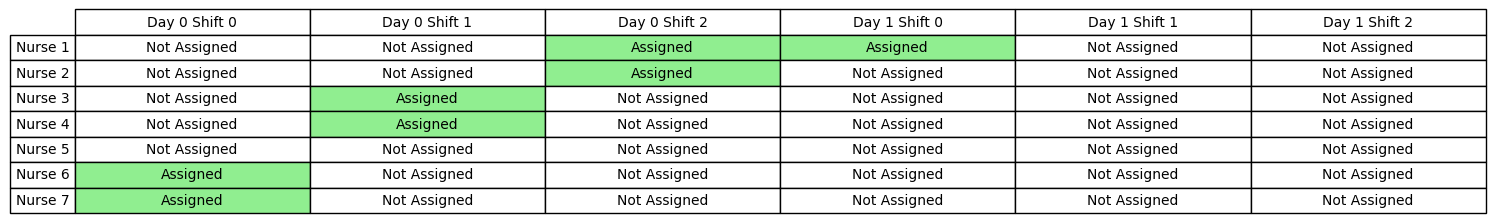

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[1,0,0])]
Size of CL:  20
Size of B:  125
Number of Queries:  138
Query138: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


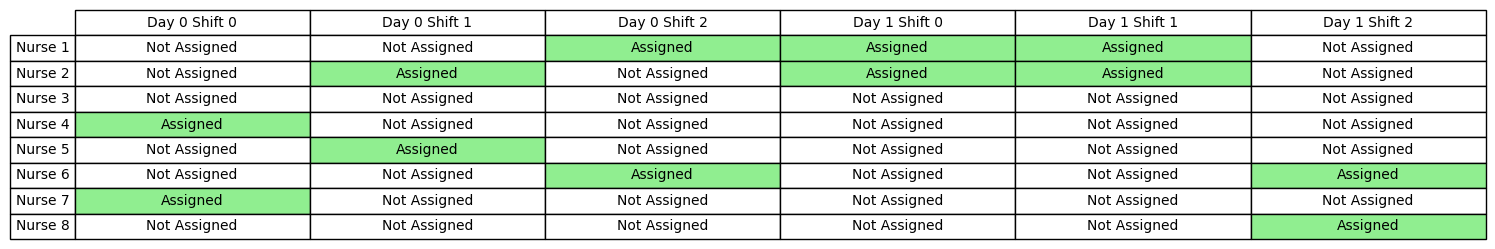

Answer:  No
Query139: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


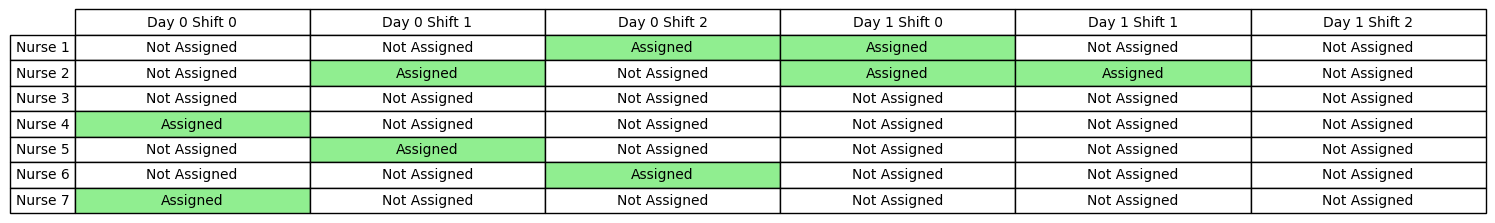

Answer:  No
Query140: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


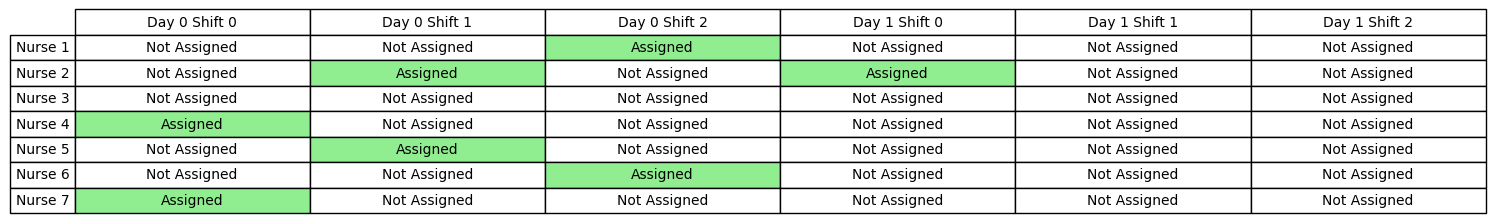

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,0,0])]
Query141: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


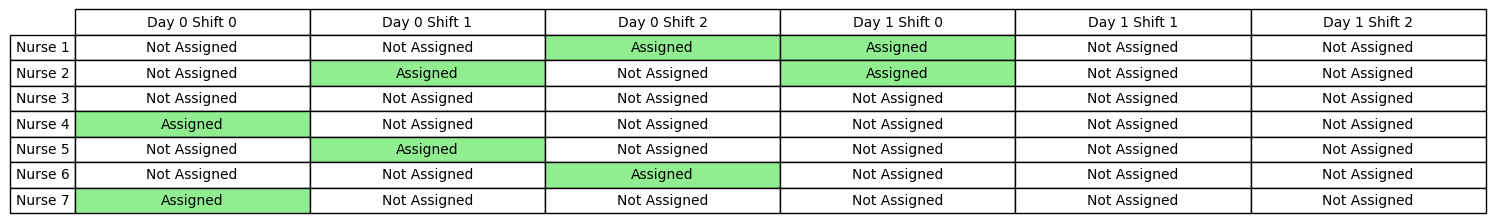

Answer:  No
Query142: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


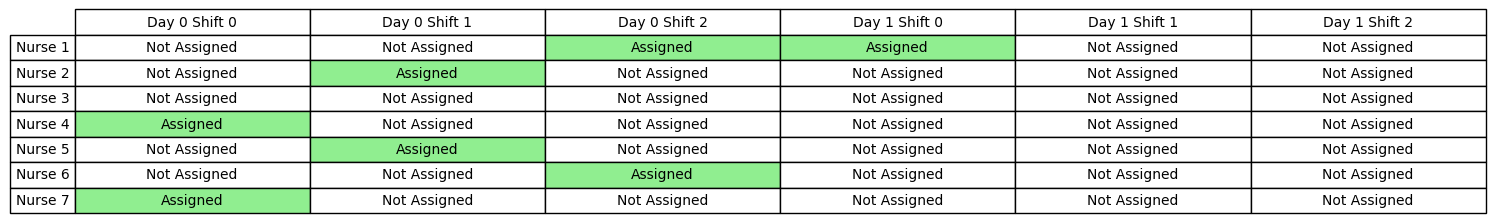

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[1,0,1])]
Size of CL:  21
Size of B:  123
Number of Queries:  143
Query143: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


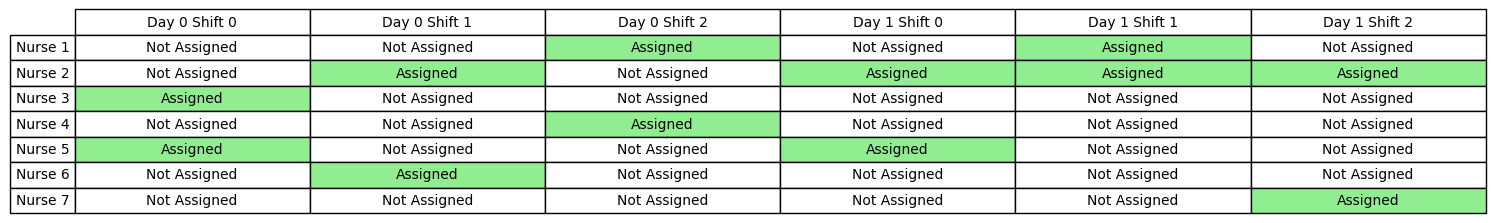

Answer:  No
Query144: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


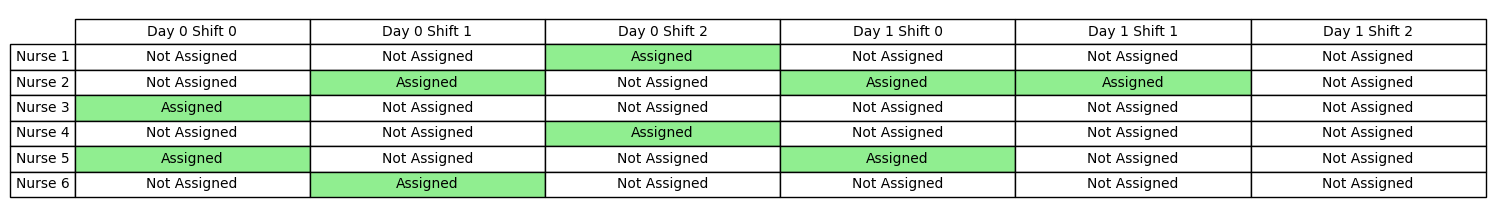

Answer:  No
Query145: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


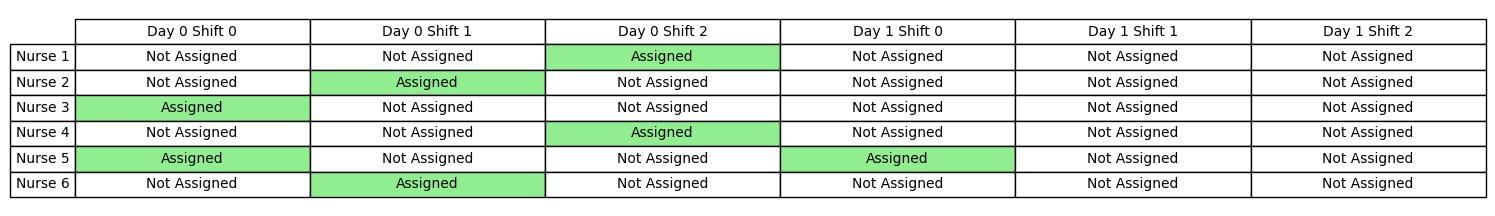

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,0,0])]
Query146: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


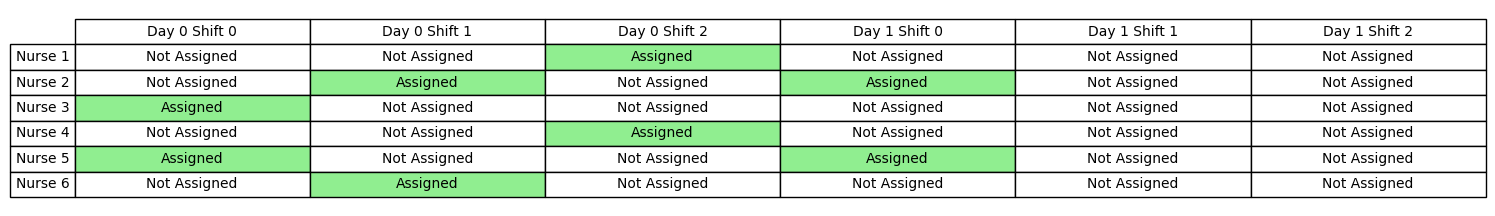

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) != (shifts[1,0,1])]
Query147: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


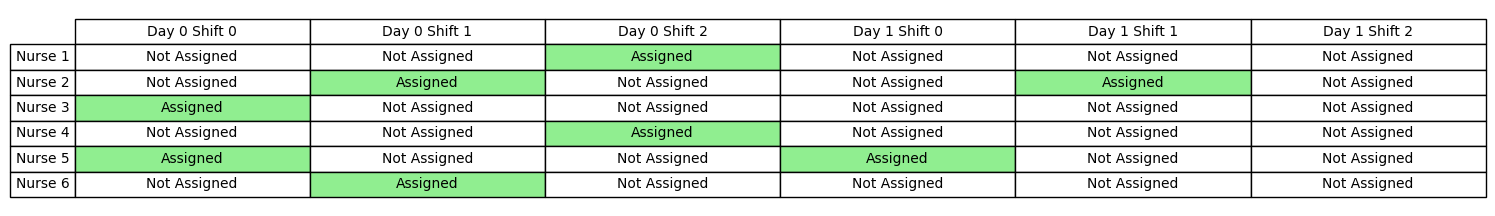

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) <= (shifts[1,1,0]), (shifts[0,2,0]) >= (shifts[1,1,0]), (shifts[0,1,0]) != (shifts[1,1,0])]
Query148: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


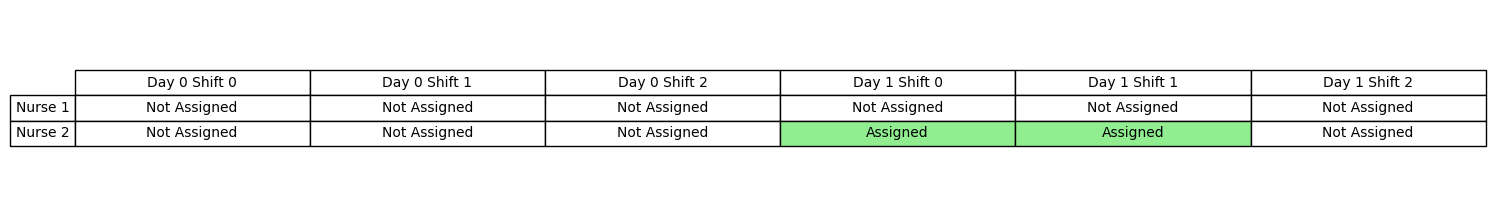

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,1,0])]
Size of CL:  22
Size of B:  117
Number of Queries:  149
Query149: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


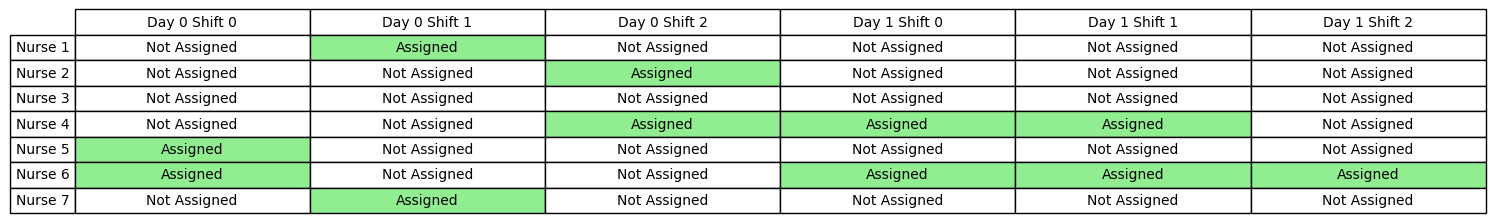

Answer:  No
Query150: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


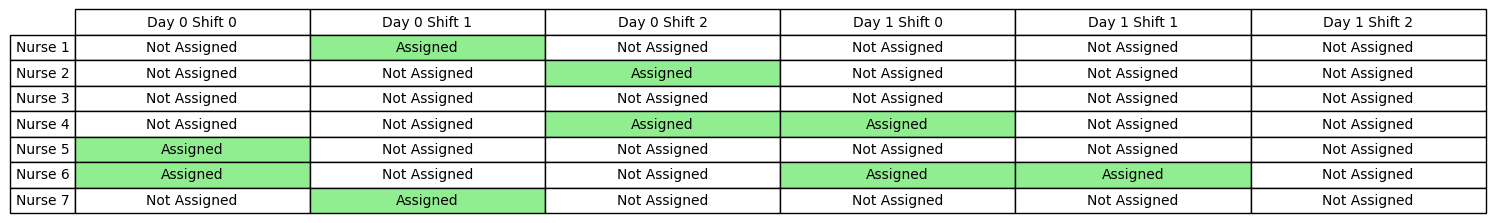

Answer:  No
Query151: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


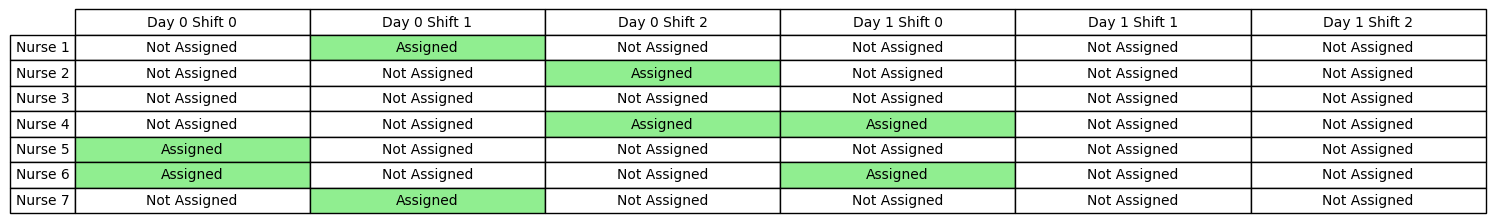

Answer:  No
Query152: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


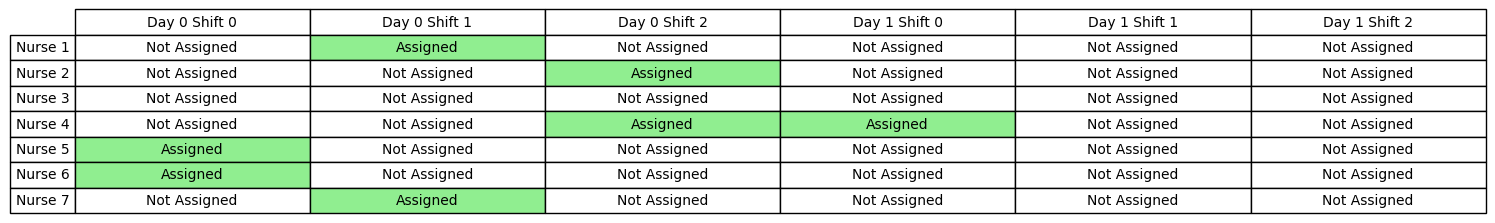

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[1,0,1])]
Size of CL:  23
Size of B:  116
Number of Queries:  153
Query153: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


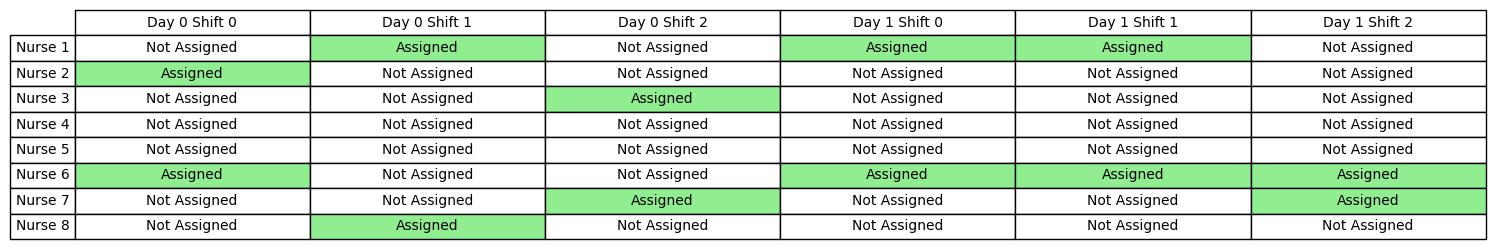

Answer:  No
Query154: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


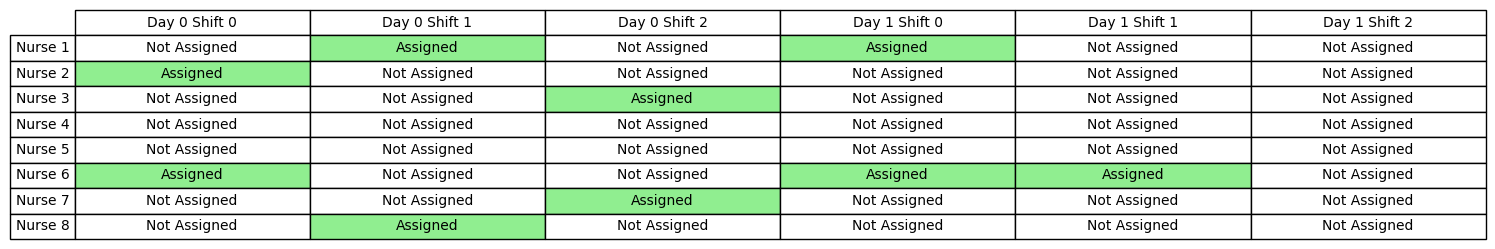

Answer:  No
Query155: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


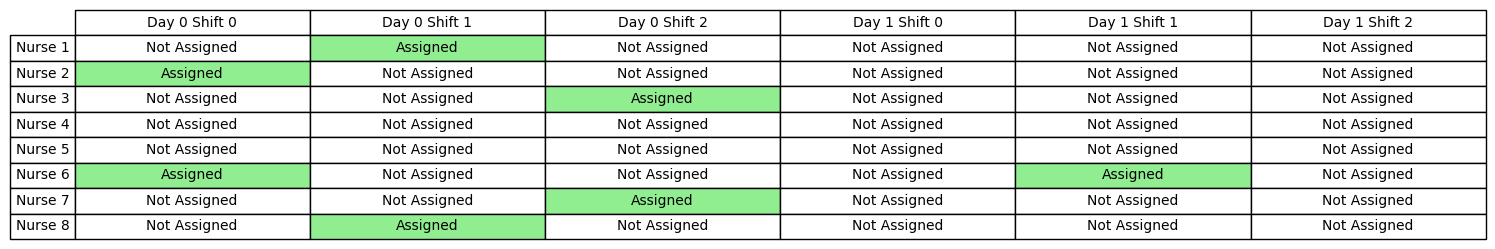

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,1,0])]
Query156: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


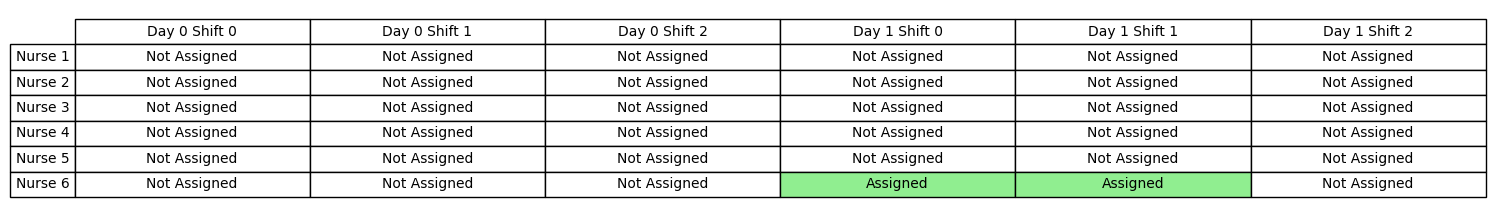

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,1,0])]
Size of CL:  24
Size of B:  114
Number of Queries:  157
Query157: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


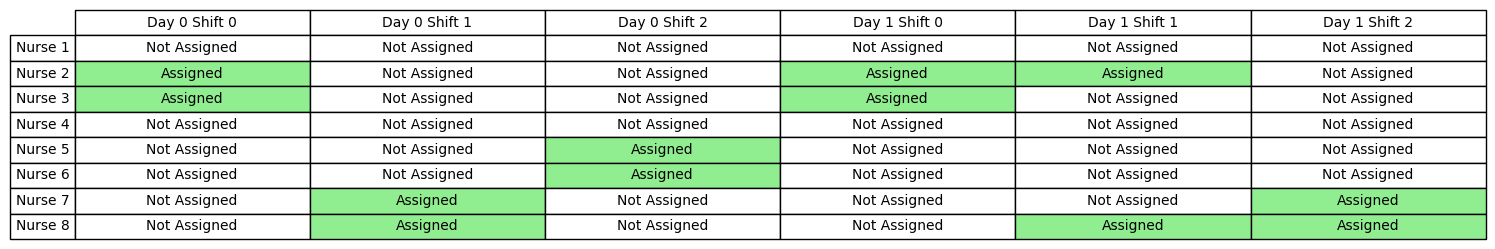

Answer:  No
Query158: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


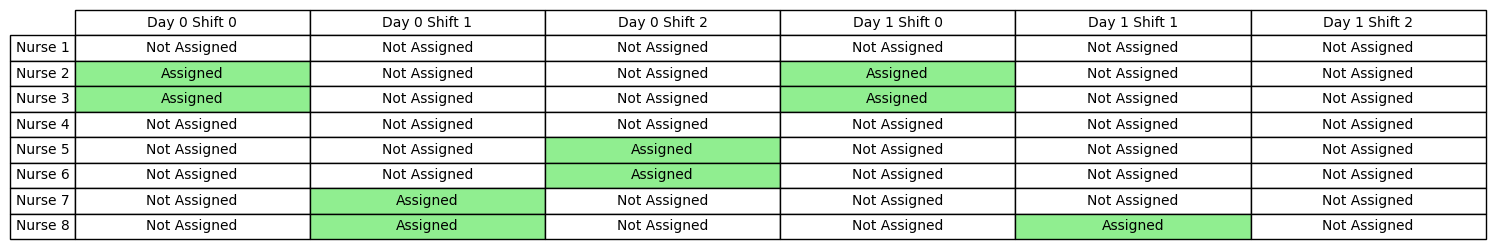

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,0,1]), (shifts[0,1,1]) != (shifts[1,1,0])]
Query159: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


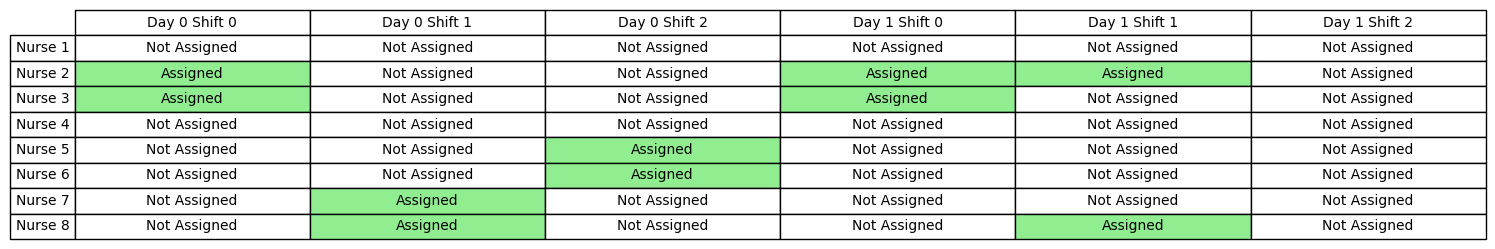

Answer:  No
Query160: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


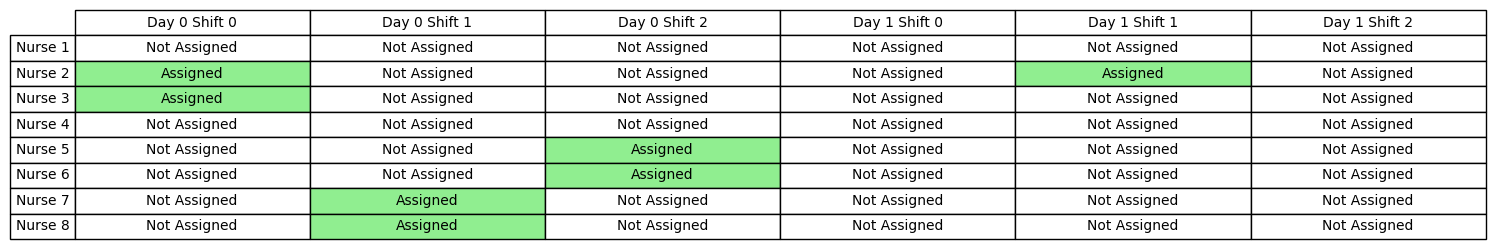

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,1,1]), (shifts[0,0,1]) <= (shifts[1,1,1])]
Query161: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


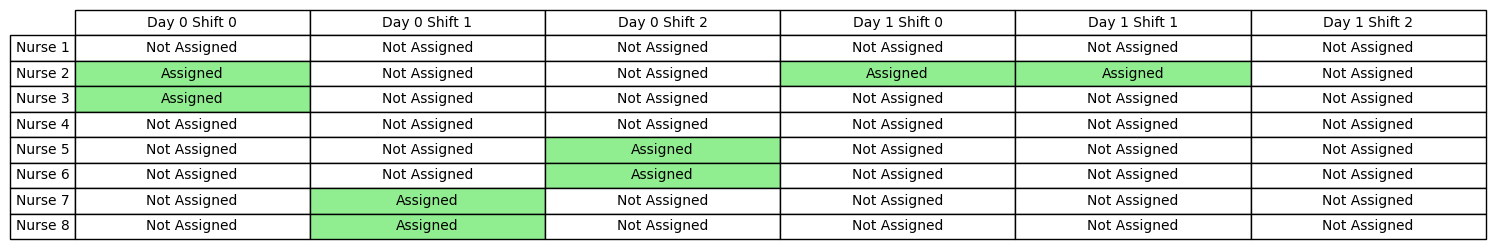

Answer:  No
Query162: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


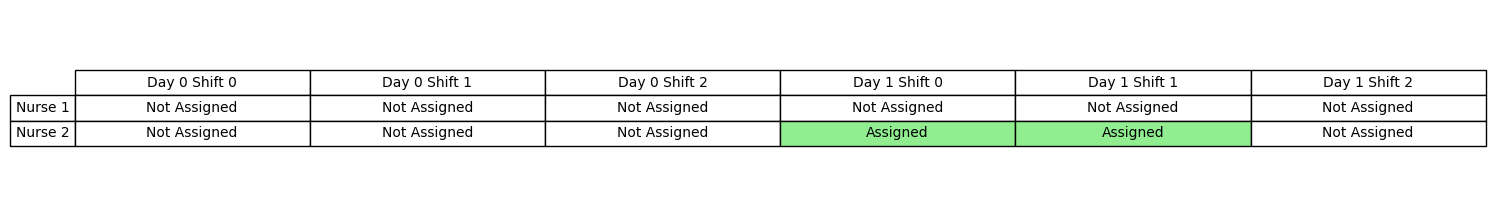

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,1,1])]
Size of CL:  25
Size of B:  109
Number of Queries:  163
Query163: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


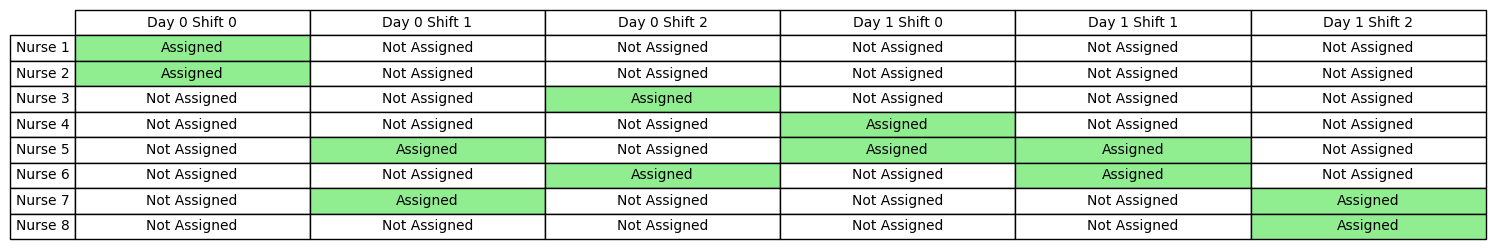

Answer:  No
Query164: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


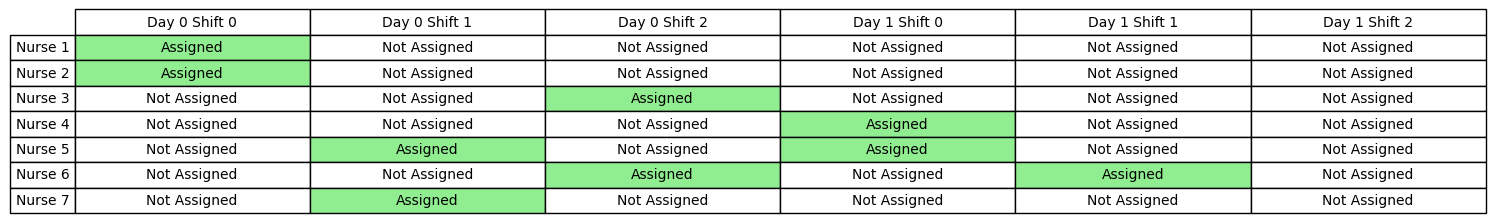

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,1,0])]
Query165: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


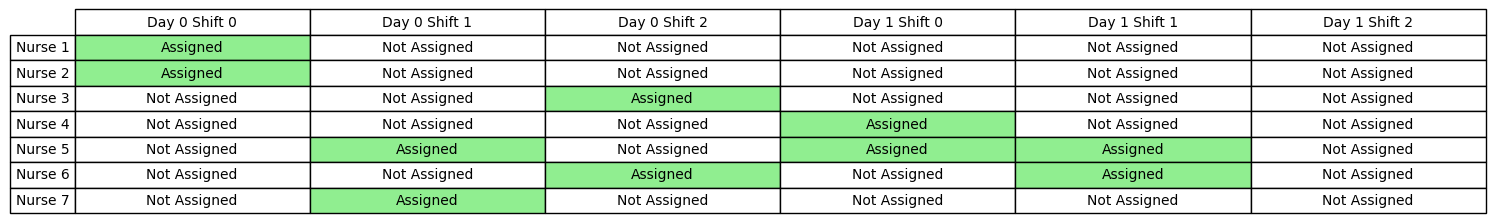

Answer:  No
Query166: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


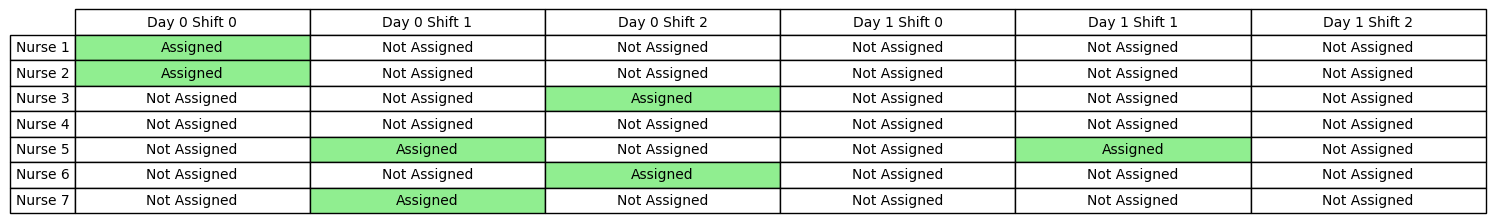

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) != (shifts[1,1,1])]
Query167: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


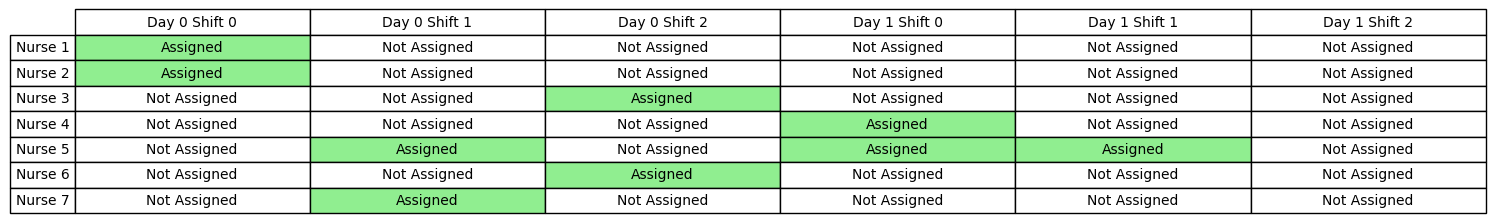

Answer:  No
Query168: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


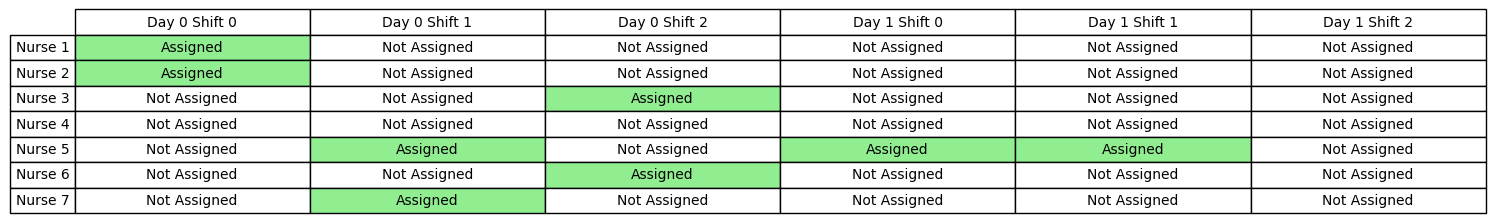

Answer:  No
Query169: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


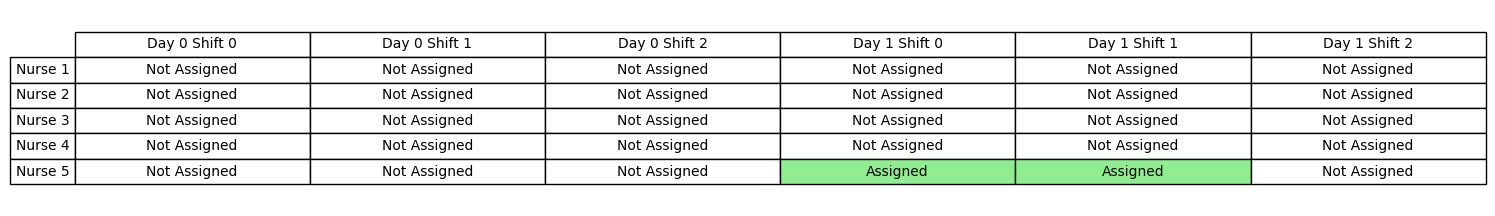

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,1,1])]
Size of CL:  26
Size of B:  106
Number of Queries:  170
Query170: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


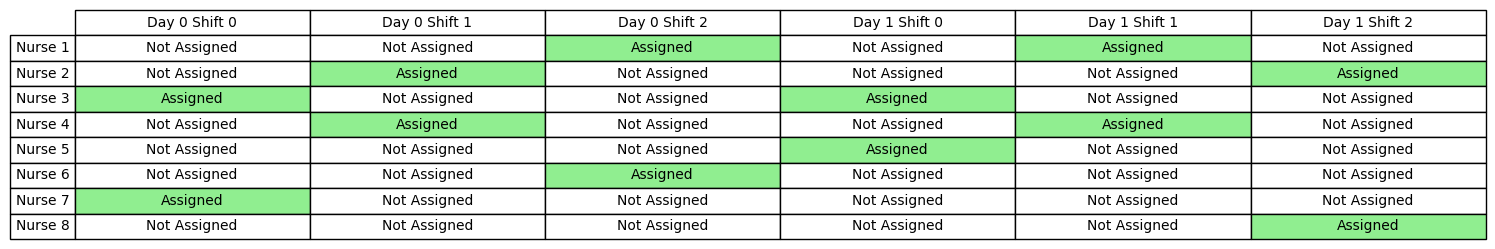

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) > (shifts[1,2,1]), (shifts[0,0,1]) > (shifts[1,2,0]), (shifts[1,0,1]) == (shifts[1,2,0]), (shifts[1,0,1]) == (shifts[1,2,1]), (shifts[1,0,0]) <= (shifts[1,2,1]), (shifts[1,0,0]) >= (shifts[1,2,0]), (shifts[0,1,1]) >= (shifts[1,2,0]), (shifts[0,2,0]) < (shifts[1,2,1]), (shifts[1,0,1]) < (shifts[1,2,1]), (shifts[0,0,1]) < (shifts[1,2,1]), (shifts[0,2,0]) >= (shifts[1,2,0]), (shifts[1,0,0]) == (shifts[1,2,1]), (shifts[0,1,1]) == (shifts[1,2,0]), (shifts[0,1,1]) <= (shifts[1,2,1]), (shifts[1,0,1]) <= (shifts[1,2,1]), (shifts[0,0,0]) > (shifts[1,2,0]), (shifts[0,2,1]) > (shifts[1,2,0]), (shifts[1,1,1]) == (shifts[1,2,1]), (shifts[1,1,1]) > (shifts[1,2,0]), (shifts[0,1,1]) == (shifts[1,2,1]), (shifts[0,0,1]) >= (shifts[1,2,0]), (shifts[1,1,1]) >= (shifts[1,2,1]), (shifts[1,0,1]) >= (shifts[1,2,0]), (shifts[0,2,1]) >= (shifts[1,2,1]), (shifts[1,1,0]) <= (shifts[1,1,1]), (shifts[0,1,1]) < (shifts[1,2,1]), (shifts[1,1,0

C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


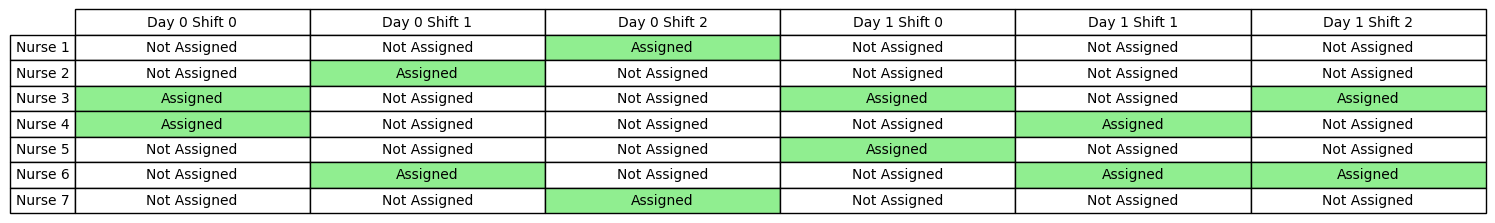

Answer:  No
Query172: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


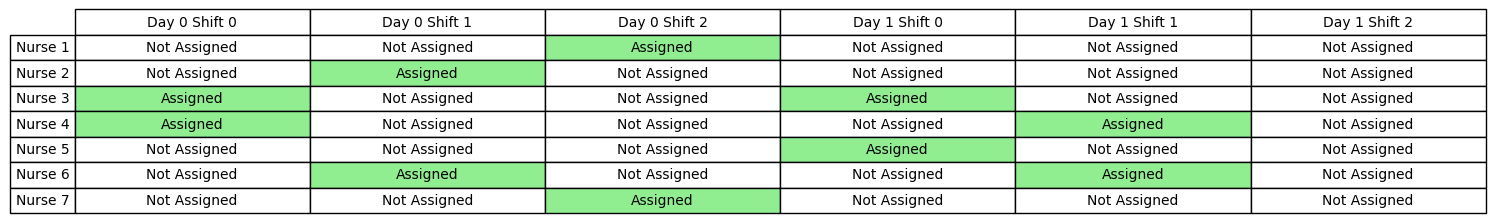

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,1,1])]
Query173: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


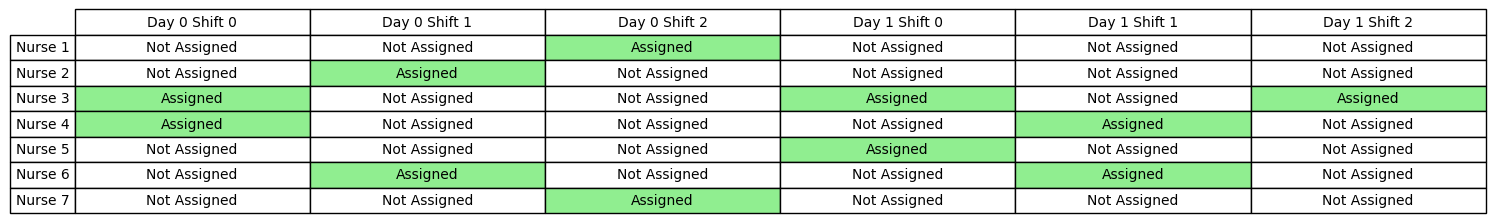

Answer:  No
Query174: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


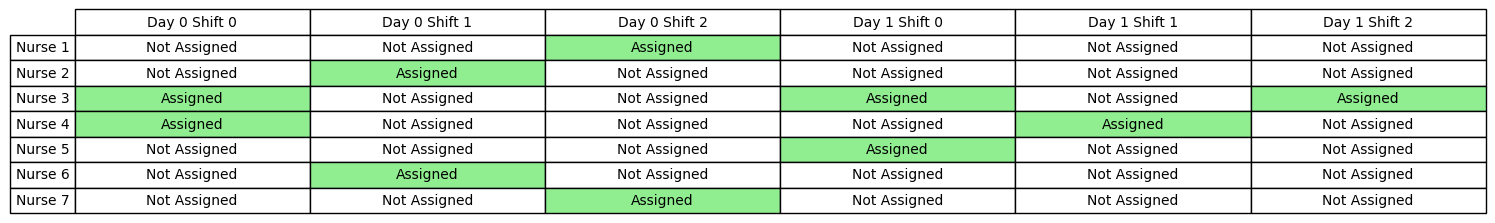

Answer:  No
Query175: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


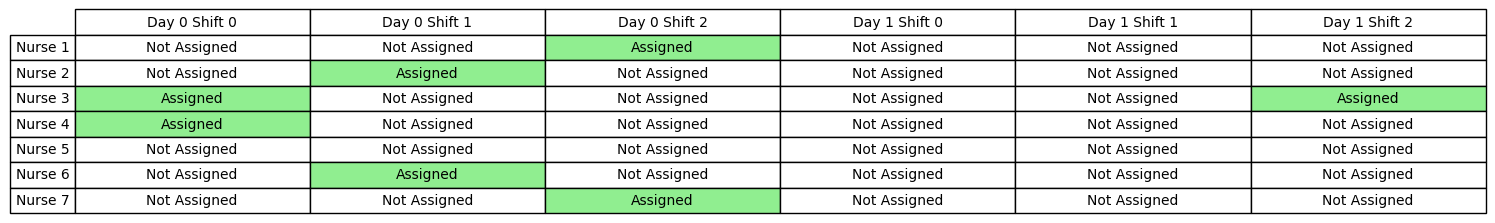

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,2,0]), (shifts[0,1,1]) <= (shifts[1,2,0])]
Query176: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


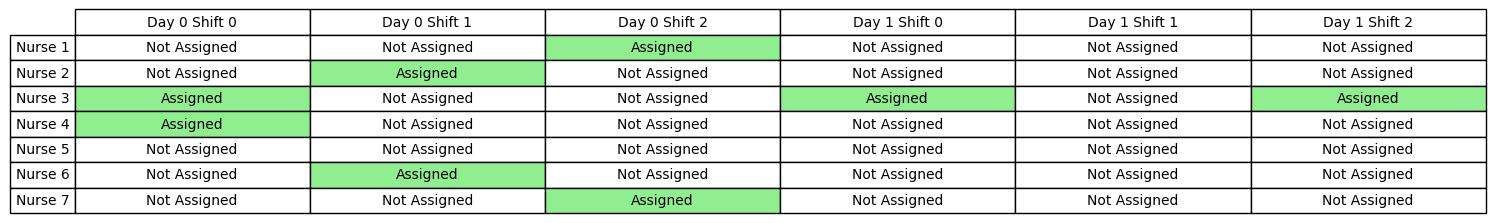

Answer:  No
Query177: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


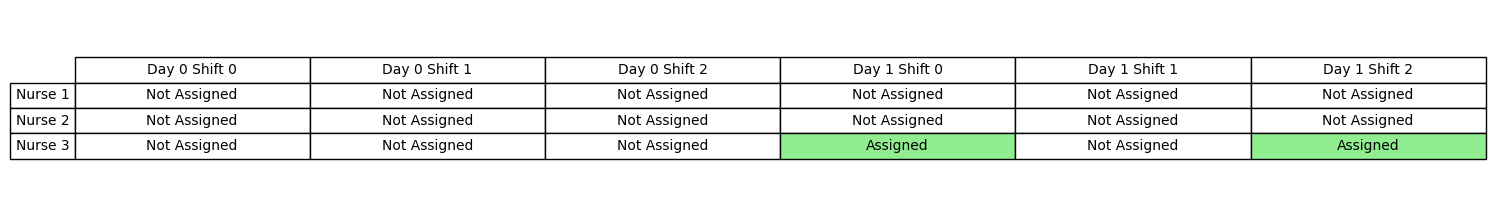

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,2,0])]
Size of CL:  27
Size of B:  45
Number of Queries:  178
Query178: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


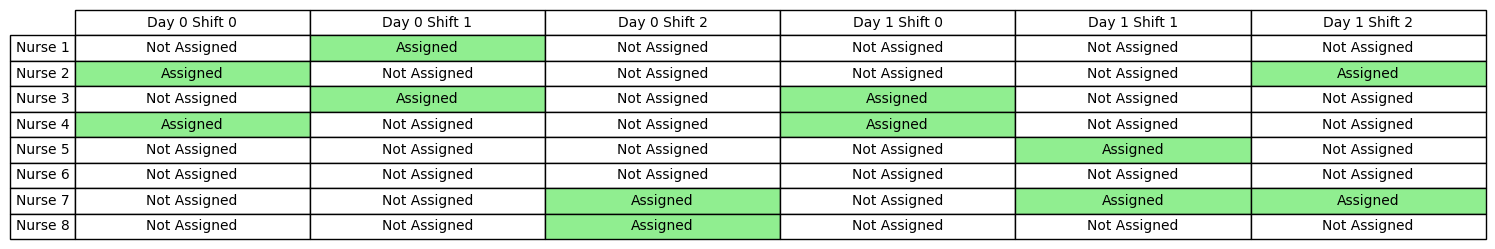

Answer:  No
Query179: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


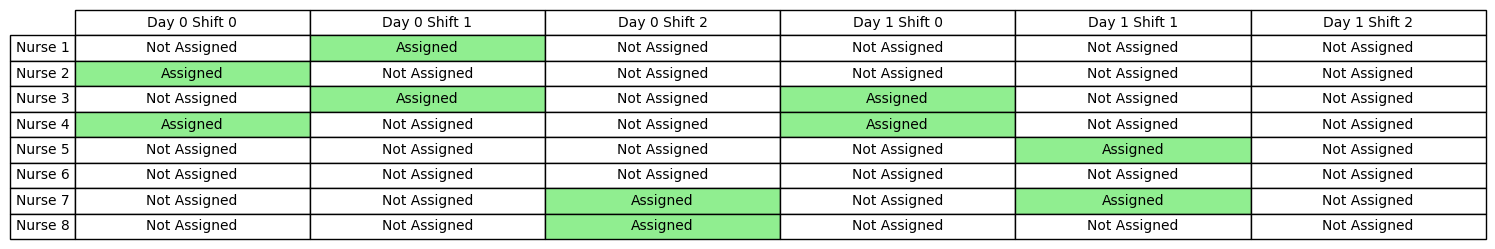

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) != (shifts[1,1,1])]
Query180: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


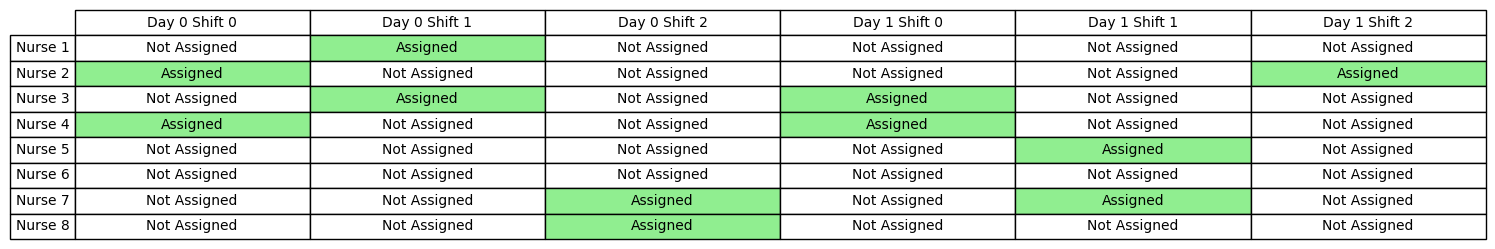

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) < (shifts[1,2,0]), (shifts[0,0,1]) != (shifts[1,2,0]), (shifts[1,0,1]) <= (shifts[1,2,0]), (shifts[1,1,1]) <= (shifts[1,2,0]), (shifts[1,1,0]) <= (shifts[1,2,0]), (shifts[1,1,1]) < (shifts[1,2,0])]
Query181: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


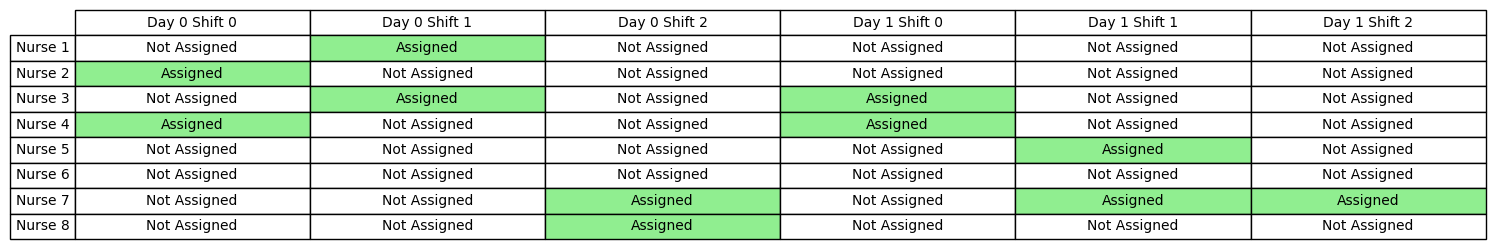

Answer:  No
Query182: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


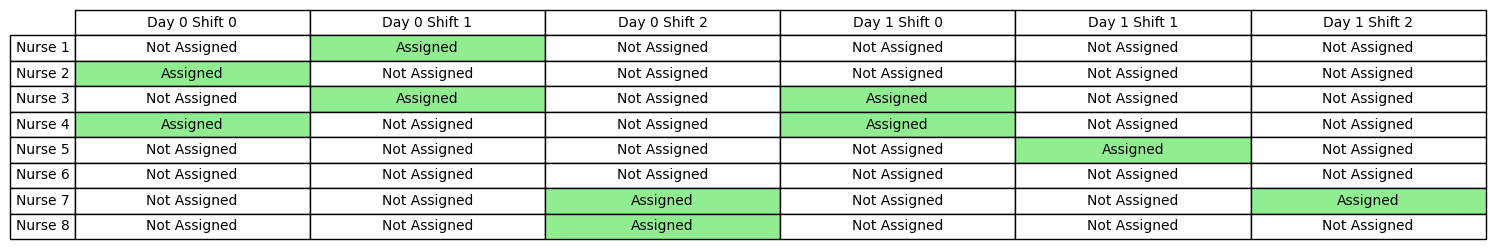

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) >= (shifts[1,2,1]), (shifts[0,1,0]) >= (shifts[1,2,1]), (shifts[0,2,0]) > (shifts[1,2,1]), (shifts[0,1,1]) > (shifts[1,2,1]), (shifts[0,0,1]) >= (shifts[1,2,1]), (shifts[0,0,0]) > (shifts[1,2,1]), (shifts[0,1,1]) >= (shifts[1,2,1]), (shifts[1,0,0]) > (shifts[1,2,1]), (shifts[1,0,1]) > (shifts[1,2,1]), (shifts[0,0,1]) > (shifts[1,2,1]), (shifts[0,2,1]) <= (shifts[1,2,1]), (shifts[0,1,0]) == (shifts[1,2,1]), (shifts[1,1,0]) >= (shifts[1,2,1]), (shifts[0,2,1]) < (shifts[1,2,1]), (shifts[1,0,1]) >= (shifts[1,2,1]), (shifts[0,0,0]) >= (shifts[1,2,1]), (shifts[0,2,0]) != (shifts[1,2,1]), (shifts[1,1,0]) > (shifts[1,2,1])]
Query183: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


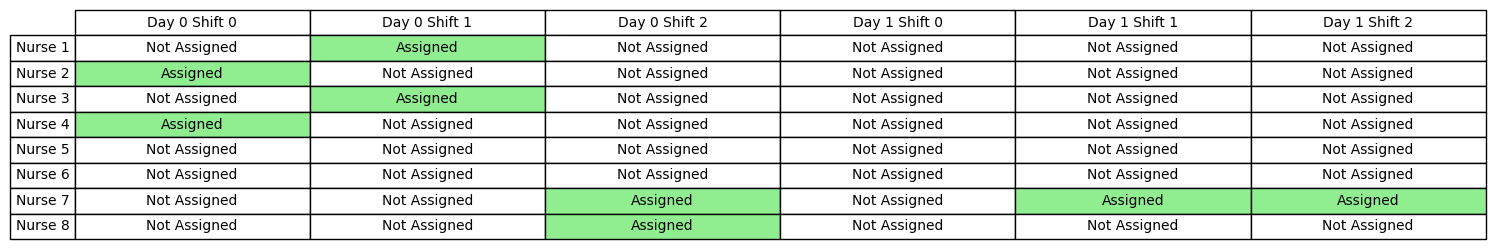

Answer:  No
Query184: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


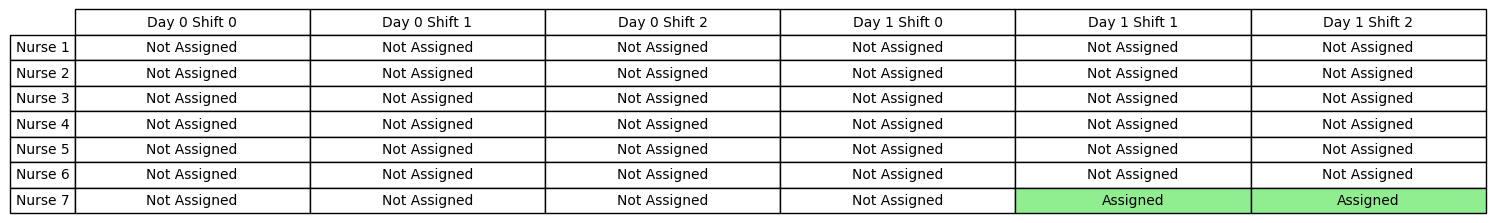

Answer:  No
Query185: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


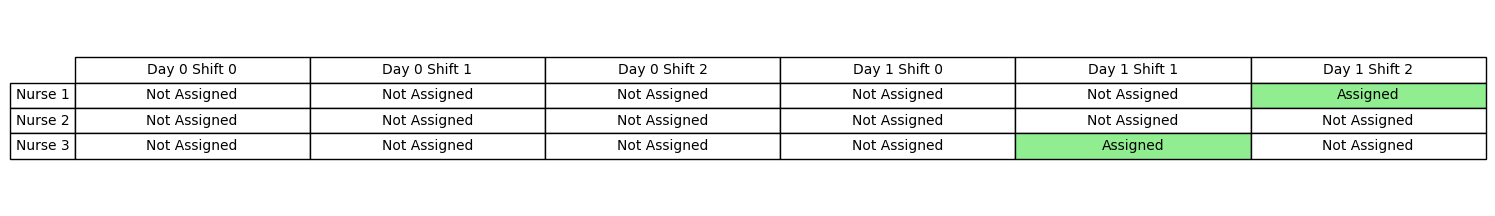

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) < (shifts[1,2,1])]
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,1])]
Size of CL:  28
Size of B:  18
Number of Queries:  186
Query186: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


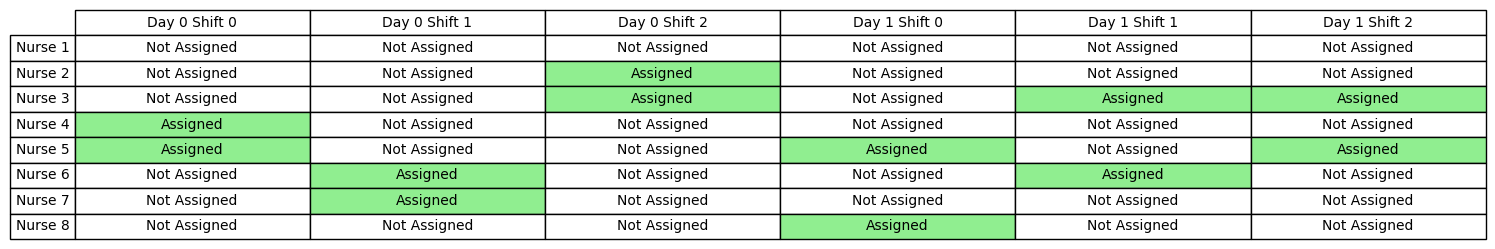

Answer:  No
Query187: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


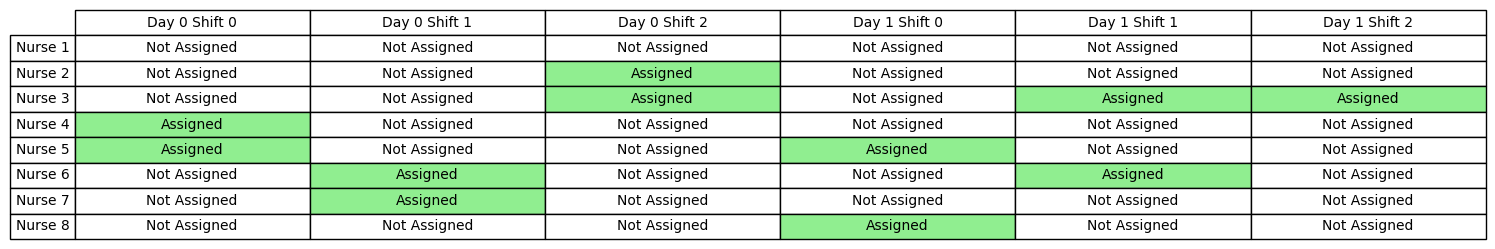

Answer:  No
Query188: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


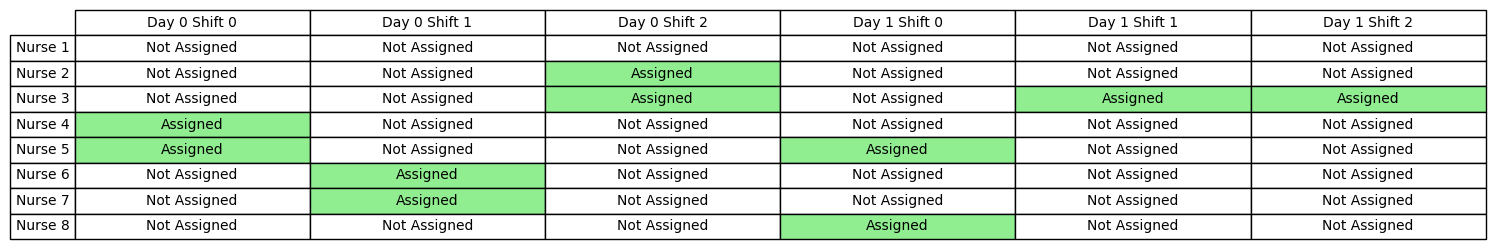

Answer:  No
Query189: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


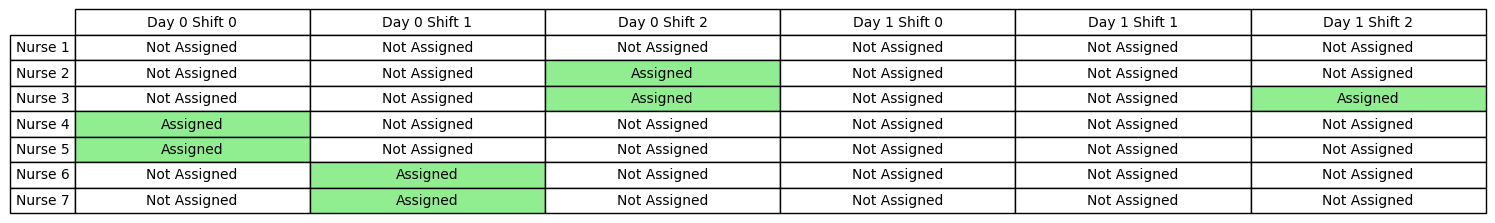

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) != (shifts[1,2,0])]
Query190: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


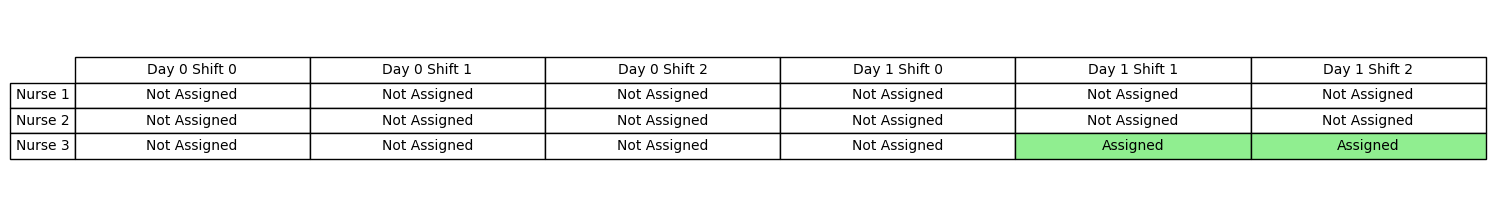

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,2,0])]
Size of CL:  29
Size of B:  16
Number of Queries:  191
Query191: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


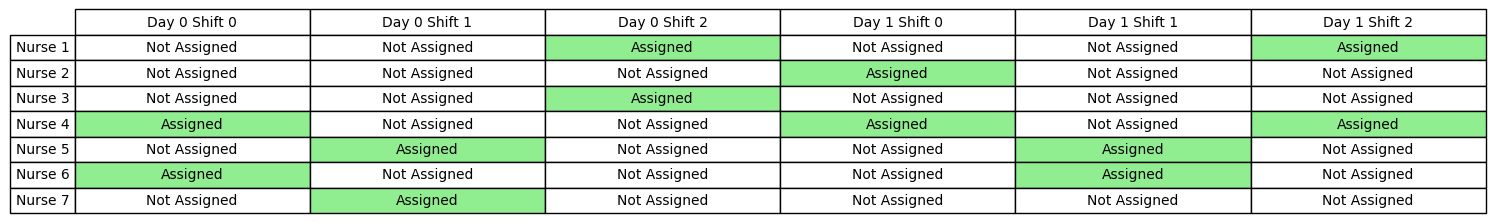

Answer:  No
Query192: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


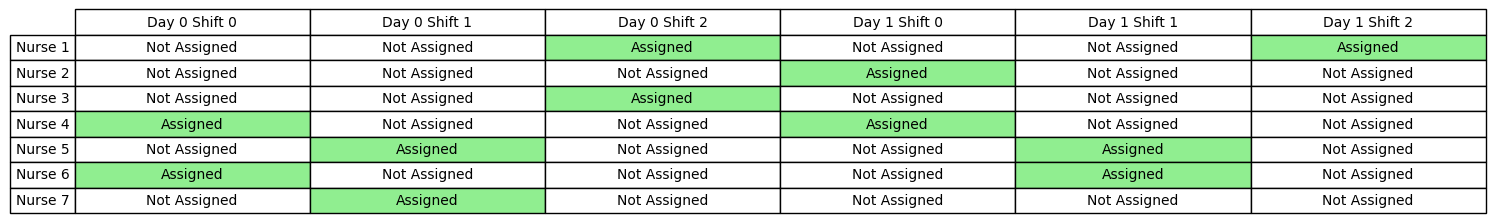

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,2,0])]
Query193: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


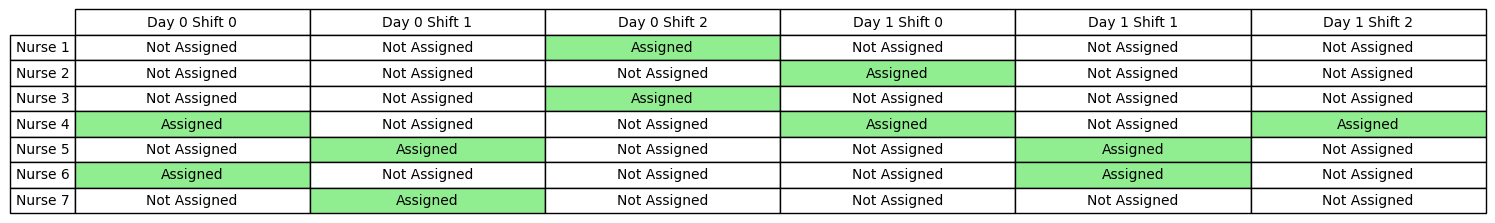

Answer:  No
Query194: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


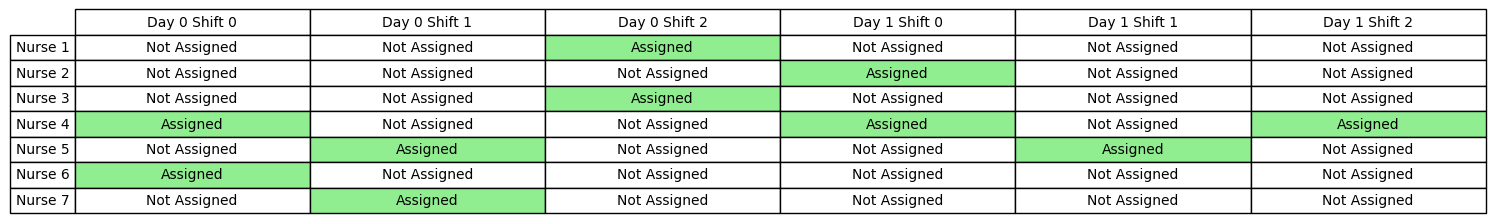

Answer:  No
Query195: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


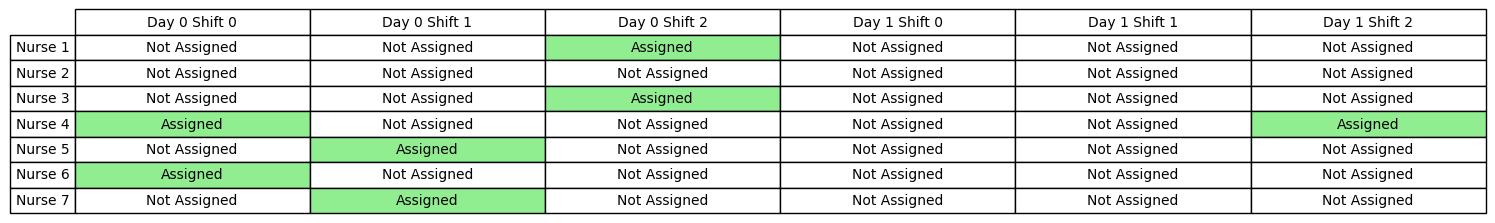

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) <= (shifts[1,2,1]), (shifts[0,2,0]) >= (shifts[1,2,1]), (shifts[0,0,0]) != (shifts[1,2,1])]
Query196: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


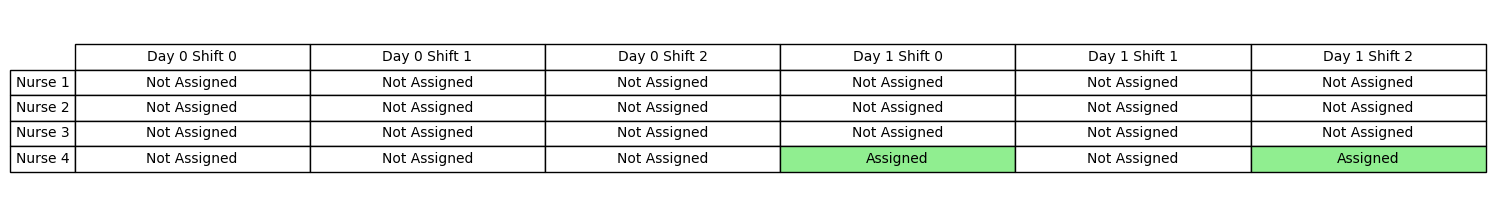

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,2,1])]
Size of CL:  30
Size of B:  11
Number of Queries:  197
Query197: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


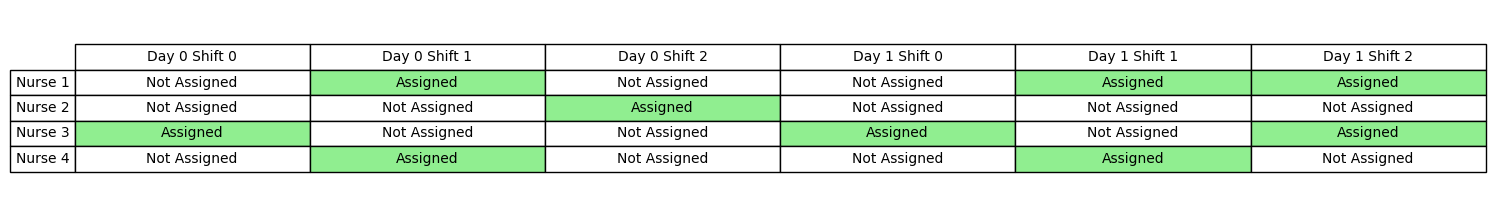

Answer:  No
Query198: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


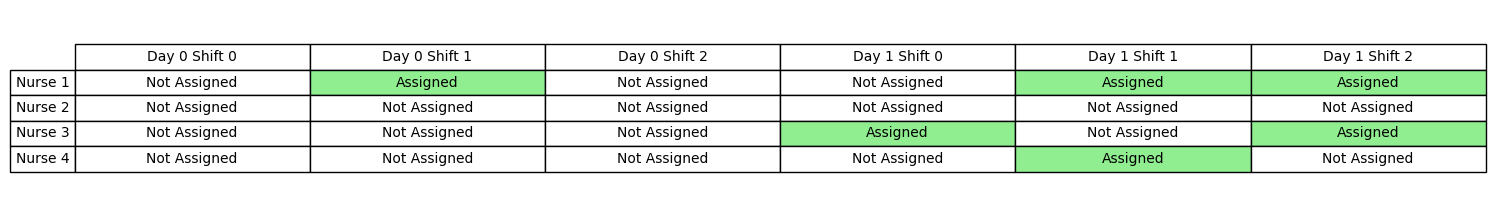

Answer:  No
Query199: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


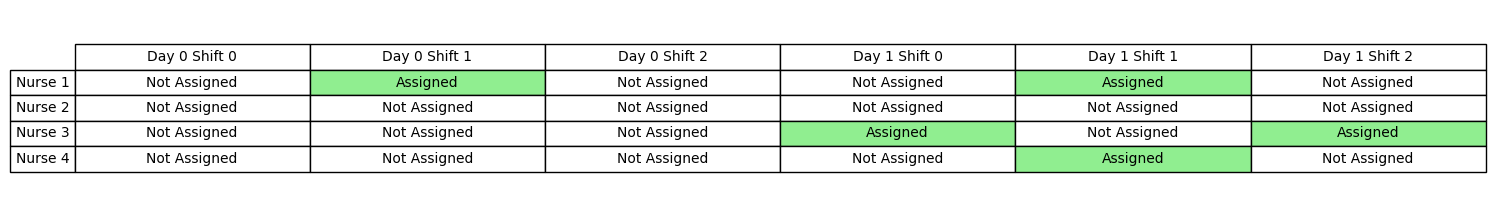

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,2,1])]
Size of CL:  31
Size of B:  10
Number of Queries:  200
Query200: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


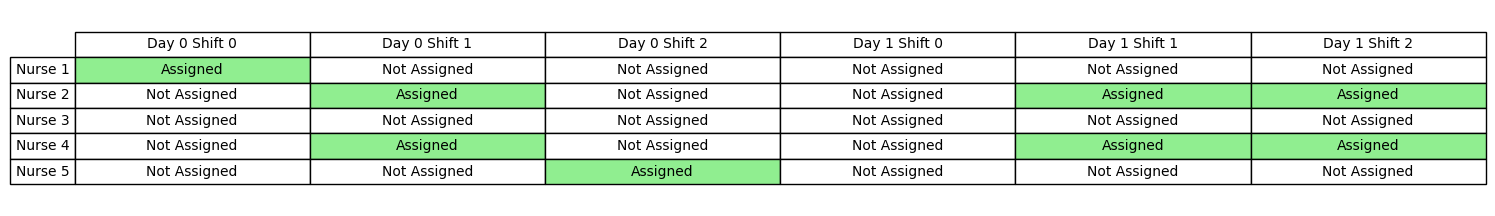

Answer:  No
Query201: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


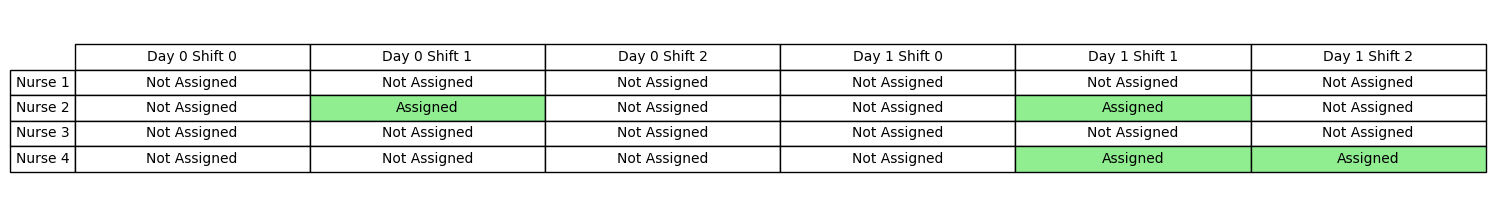

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,2,1])]
Size of CL:  32
Size of B:  9
Number of Queries:  202
Query202: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


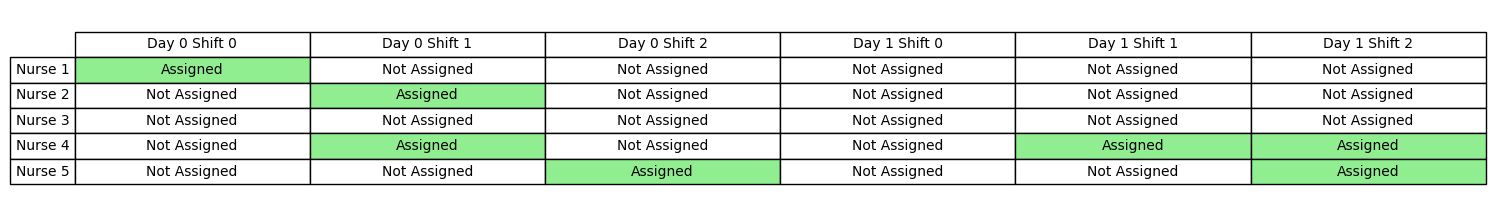

Answer:  No
Query203: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


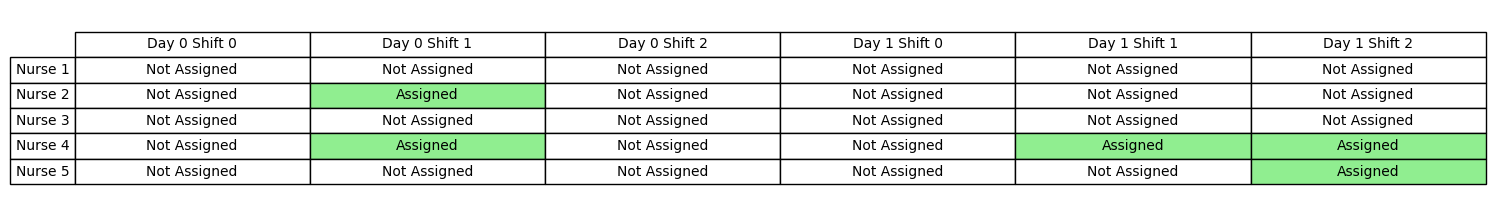

Answer:  No
Query204: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


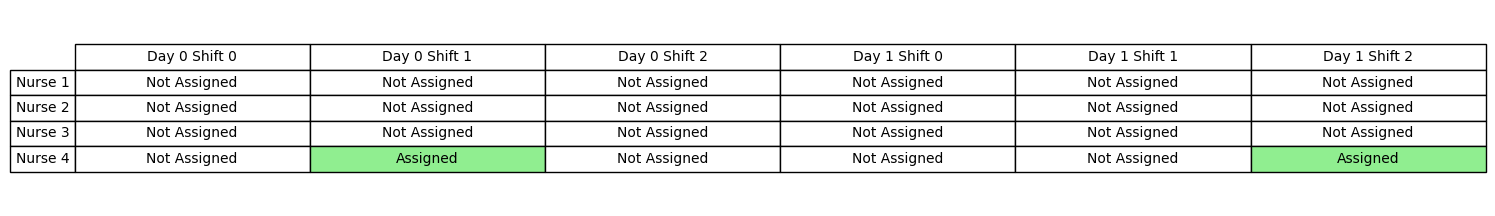

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) != (shifts[1,2,0])]
Query205: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


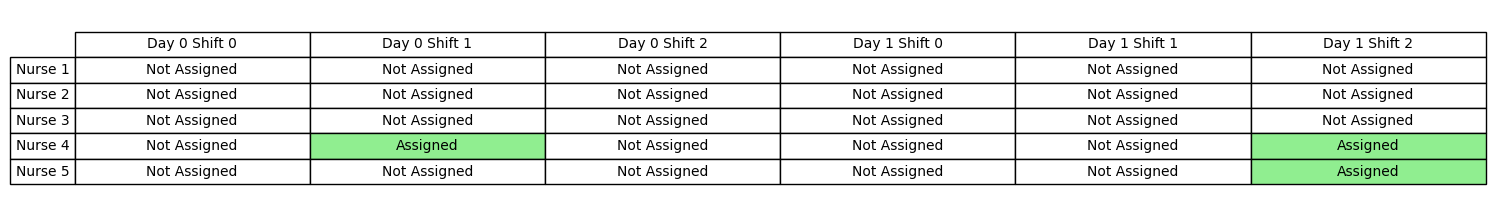

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) >= (shifts[1,2,1]), (shifts[1,2,0]) > (shifts[1,2,1])]
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,0])]
Size of CL:  33
Size of B:  5
Number of Queries:  206
Query206: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


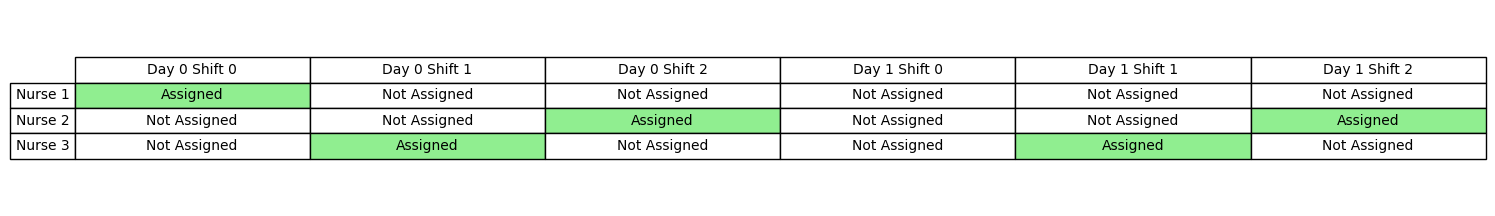

Answer:  No
Query207: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


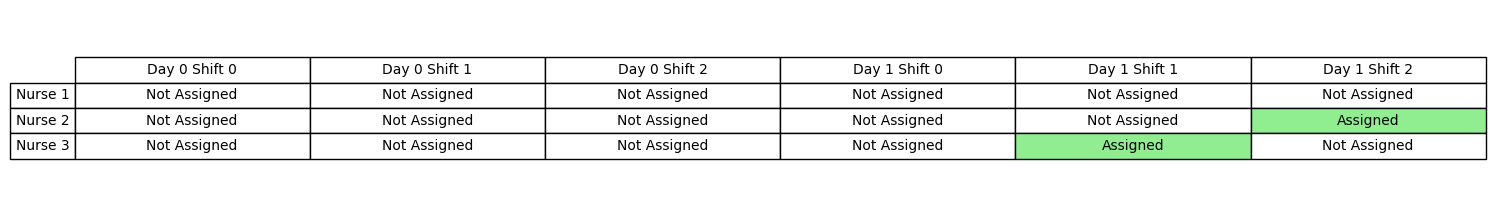

Answer:  No
Query208: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


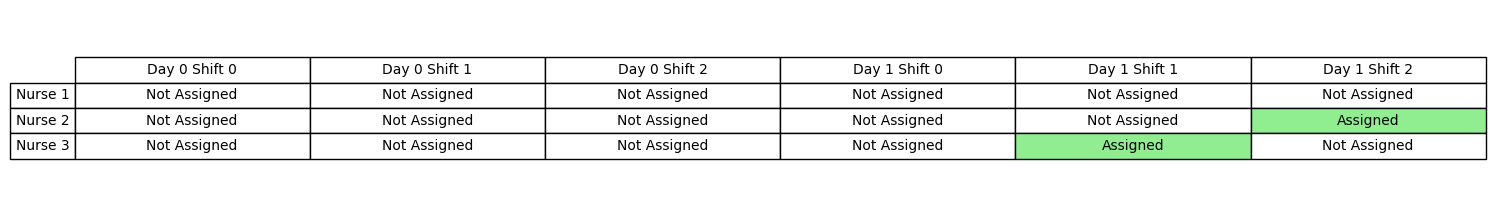

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) <= (shifts[1,2,1])]
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,2,1])]
Size of CL:  34
Size of B:  3
Number of Queries:  209
Query209: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


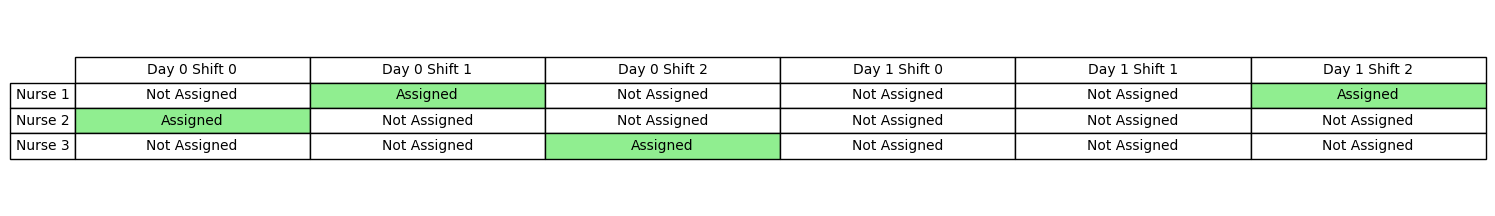

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,2,1])]
Size of CL:  34
Size of B:  2
Number of Queries:  210
Query210: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


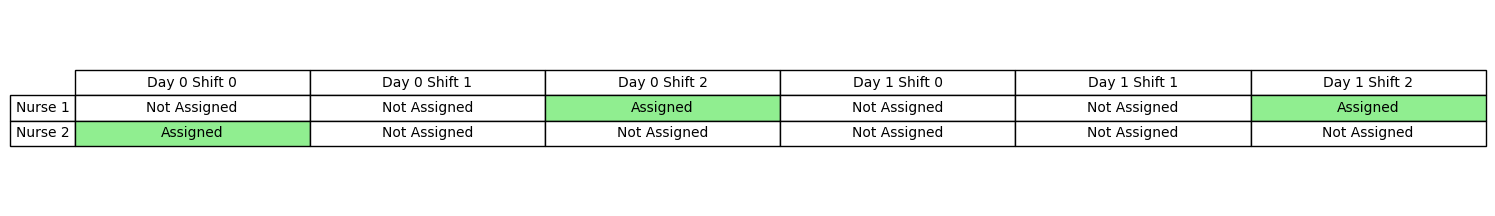

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,2,1])]
Size of CL:  34
Size of B:  1
Number of Queries:  211
Query211: is this a solution?


C:\Users\DTAI\AppData\Local\Temp\ipykernel_29080\259578657.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df.applymap(lambda x: cmap[x])


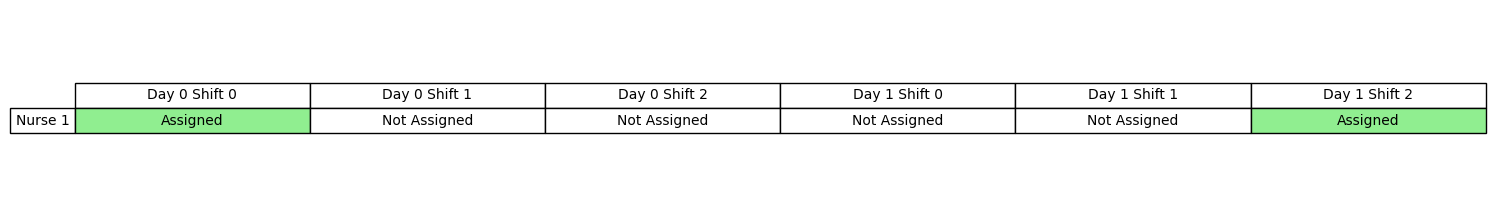

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,2,1])]
Size of CL:  34
Size of B:  0
Number of Queries:  212

Learned 34 constraints in 212 queries.


In [39]:
learned_instance = qa.learn(instance, oracle, verbose=3)

### Multiple Acquisition

In [40]:
# some patience needed here

# Multiple Acquisition: includes MquAcq and MQuAcq2
mqa = MQuAcq()
learned_instance = mqa.learn(instance, oracle=oracle)

mqa2 = MQuAcq2()
learned_instance = mqa2.learn(instance, oracle=oracle)

### GrowAcq

In [41]:
# Creating an environment with the default settings
env = ActiveCAEnv()

# GrowAcq
ga = GrowAcq(env)
learned_instance = ga.learn(instance, oracle=oracle)

# we can compare the statistics:
out = pd.concat([a.env.metrics.short_statistics for a in [qa,mqa,mqa2,ga]])
out.index = ["qa","mqa","mqa2","ga"]
out

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time   avg_t  \
qa    34    212         38    146     28      6.1840        0.8936  0.6745   
mqa   34    158         60     30     68      2.7848        0.7531  0.0790   
mqa2  34    190         38    104     38      4.5316        0.6856  0.0712   
ga    34    177         63     82     32      5.3785        0.1366  0.0720   

       max_t     tot_t  conv  
qa    2.0497  142.9991     1  
mqa   1.3900   12.4873     1  
mqa2  1.3654   13.5200     1  
ga    0.4259   12.7439     1

## Prediction-based interactive CA system

- 2 types of environments for interactive CA systems in **PyConA**: 
    - the basic ActiveCAEnv, 
    - and the prediction based ProbaActiveCAEnv (default if none is used)
- ProbaActiveCAEnv uses the constraint-level dataset and predictions to guide the queries


ProbaActiveCAEnv has 2 additional configurable options:
- Feature representation (.feature_representation): The feature representation used for the constraints
- Classifier (.classifier): The (probabilistic) classifier used to predict probabilities for the candidate constraints

### Comparing probabilistic approach with basic environment 

In [19]:
from pycona import benchmarks

instance, oracle = benchmarks.construct_nurse_rostering(3, 2, 8, 2)

# env = ProbaActiveCAEnv() # <- we do not have to use it, as it is the default for GrowAcq
ga_predict = GrowAcq() # GrowAcq(env)
learned_instance = ga_predict.learn(instance, oracle)

In [20]:
# comparison with other algorithms
out = pd.concat([a.env.metrics.short_statistics for a in [qa,mqa,mqa2,ga, ga_predict]])
out.index = ["qa","mqa","mqa2","ga", "ga-predict"]
out

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time  \
qa          34    196         39    134     23      6.3673        0.9176   
mqa         34    158         60     30     68      2.8038        0.7736   
mqa2        34    195         38     99     48      4.1590        0.8357   
ga          34    183         64     85     33      5.3989        0.1269   
ga-predict  34     82         80      0      2      7.2683        0.3320   

             avg_t   max_t     tot_t  conv  
qa          0.7691  2.2738  150.7493     1  
mqa         0.0818  1.3318   12.9211     1  
mqa2        0.0890  1.6505   17.3566     1  
ga          0.0662  0.3819   12.1143     1  
ga-predict  0.3683  1.2130   30.1976     1

### Customize the behaviour of ProbaActiveCAEnv

##### Changing the classifier used

**PyConA** uses scikit-learn classifiers
- any classifier with a .fit() and .predict_proba() can be used. 
- default: Decision tree

In [21]:
from sklearn.naive_bayes import GaussianNB

# Use NB
env = ProbaActiveCAEnv(classifier=GaussianNB())

gaNB = GrowAcq(env)
learned_instance = gaNB.learn(instance, oracle=oracle)

pd.concat([ga_predict.env.metrics.short_statistics, 
           gaNB.env.metrics.short_statistics,
           ga.env.metrics.short_statistics], keys=["Decision Tree", "Naive Bayes", "Basic"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time  \
Decision Tree 0  34     82         80      0      2      7.2683        0.3320   
Naive Bayes   0  34     96         84      5      7      6.9583        0.3500   
Basic         0  34    183         64     85     33      5.3989        0.1269   

                  avg_t   max_t    tot_t  conv  
Decision Tree 0  0.3683  1.2130  30.1976     1  
Naive Bayes   0  0.3543  1.4171  34.0172     1  
Basic         0  0.0662  0.3819  12.1143     1

##### Changing the feature representation


- FeatureRepresentation class to featurize constraints
- Subclass FeatureRepresentation to define custom feature representations

In [22]:
from pycona.predictor import FeatureRepresentation
from pycona.utils import get_relation

class FeaturesSimpleRel(FeatureRepresentation):

        def featurize_constraint(self, c):
            relation = get_relation(c, self.instance.language)
            return [relation]


In [23]:
env1 = ProbaActiveCAEnv(feature_representation=FeaturesSimpleRel())
ga1 = GrowAcq(env1)
learned_instance1 = ga1.learn(instance, oracle=oracle)

pd.concat([ga_predict.env.metrics.short_statistics, 
           ga1.env.metrics.short_statistics], keys=["All Features", "Simple Features"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  \
All Features    0  34     82         80      0      2      7.2683   
Simple Features 0  34     90         86      2      2      7.4222   

                   avg_gen_time   avg_t  max_t    tot_t  conv  
All Features    0        0.3320  0.3683  1.213  30.1976     1  
Simple Features 0        0.2604  0.2818  0.884  25.3644     1

In [43]:
# Practice
## Compare the results of different algorithms (QuAcq, MQuAcq, MQuAcq2, GrowAcq)
## on different benchmarks (nurse rostering, exam timetabling, murder puzzle)
## Use GrowAcq both with and without the prediction-based environment
from pycona.benchmarks import construct_murder_problem, construct_examtt_simple, construct_nurse_rostering


In [45]:
# Practice 2
## Use different classifiers of your choice in GrowAcq
## and compare the results on the different benchmarks

### PyConA

The repository has implemented various approaches and methods from the literature:
- Algorithms: QuAcq [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)-[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)], MQuAcq [[3](https://link.springer.com/chapter/10.1007/978-3-319-98334-9_25)-[4](https://link.springer.com/article/10.1007/s10601-020-09311-4)], MQuAcq-2 \[[5](https://link.springer.com/chapter/10.1007/978-3-030-30048-7_41)], GrowAcq \[[6](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)], P-QuAcq\[[7](https://www.ijcai.org/Proceedings/16/Papers/108.pdf)], G-QuAcq [[8](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7372165&tag=1)]
- Query Generation: TQ-Gen [[9](https://link.springer.com/chapter/10.1007/978-3-319-93031-2_1)], PQ-Gen [[6](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)]
- FindScope: FindScope [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)], Findscope-2 [[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425), [4](https://link.springer.com/article/10.1007/s10601-020-09311-4)]
- FindC: FindC [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)], FindC-2 [[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)]
- ML-based CA system and query generation objectives from [[10](https://ojs.aaai.org/index.php/AAAI/article/download/28655/29272)]


### References

[1] [Bessiere, C., at al. (2013, June). Constraint acquisition via partial queries. In _Twenty-Third International Joint Conference on Artificial Intelligence.](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)

[2] [Bessiere, C., et al. (2023). Learning constraints through partial queries. Artificial Intelligence, 319, 103896.](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)

[3] [Tsouros, D. C., Stergiou, K., & Sarigiannidis, P. G. (2018). Efficient methods for constraint acquisition. In _Principles and Practice of Constraint Programming: 24th International Conference, CP 2018, Lille, France, August 27-31, 2018, Proceedings 24_ (pp. 373-388). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-319-98334-9_25)

[4] [Tsouros, D. C., & Stergiou, K. (2020). Efficient multiple constraint acquisition. _Constraints_, _25_(3), 180-225.](https://link.springer.com/article/10.1007/s10601-020-09311-4)

[5] [Tsouros, D. C., Stergiou, K., & Bessiere, C. (2019). Structure-driven multiple constraint acquisition. In _Principles and Practice of Constraint Programming: 25th International Conference, CP 2019, Stamford, CT, USA, September 30–October 4, 2019, Proceedings 25_ (pp. 709-725). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-030-30048-7_41)

[6] [Tsouros, D. C., Berden, S., & Guns, T. (2023). Guided Bottom-Up Interactive Constraint Acquisition}}. In _29th International Conference on Principles and Practice of Constraint Programming (CP 2023)_ (Vol. 280, p. 36).](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)

[7] [Daoudi, A., Mechqrane, Y., Bessiere, C., Lazaar, N., & Bouyakhf, E. H. (2016, July). Constraint Acquisition with Recommendation Queries. In _IJCAI_ (pp. 720-726).](https://www.ijcai.org/Proceedings/16/Papers/108.pdf)

[8] [Daoudi, A., Lazaar, N., Mechqrane, Y., Bessiere, C., & Bouyakhf, E. H. (2015, November). Detecting types of variables for generalization in constraint acquisition. In _2015 IEEE 27th International Conference on Tools with Artificial Intelligence (ICTAI)_ (pp. 413-420). IEEE.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7372165&tag=1)

[9][Ait Addi, H., Bessiere, C., Ezzahir, R., & Lazaar, N. (2018). Time-bounded query generator for constraint acquisition. In _Integration of Constraint Programming, Artificial Intelligence, and Operations Research: 15th International Conference, CPAIOR 2018, Delft, The Netherlands, June 26–29, 2018, Proceedings 15_ (pp. 1-17). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-319-93031-2_1)

[10] [Tsouros, D., Berden, S., & Guns, T. (2024, March). Learning to learn in interactive constraint acquisition. In _Proceedings of the AAAI Conference on Artificial Intelligence_ (Vol. 38, No. 8, pp. 8154-8162)](https://ojs.aaai.org/index.php/AAAI/article/download/28655/29272)
